In [5]:
# SINAN - Modelo de Análise Epidemiológica para DENGUE
# 1. Instalar PySUS (executar isoladamente antes de tudo!)
!pip install git+https://github.com/AlertaDengue/PySUS.git --upgrade


  Cloning https://github.com/AlertaDengue/PySUS.git to /tmp/pip-req-build-grcchiey
  Running command git clone --filter=blob:none --quiet https://github.com/AlertaDengue/PySUS.git /tmp/pip-req-build-grcchiey
  Resolved https://github.com/AlertaDengue/PySUS.git to commit 54f7800db4da5171d55e3446d638d64beeb8b149
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


DENGBR20.parquet: 100%|██████████| 2.40M/2.40M [03:57<00:00, 10.1kB/s]


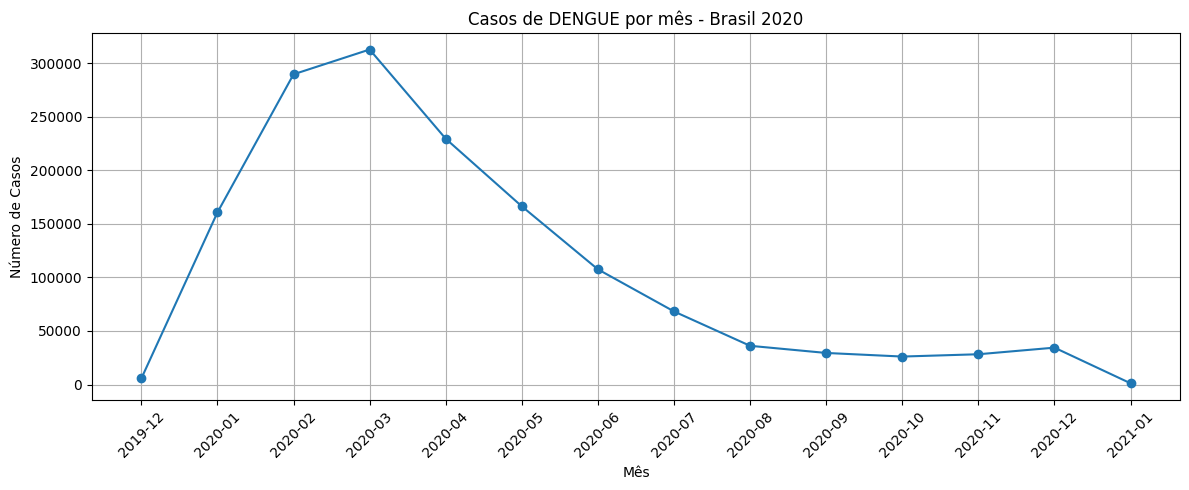

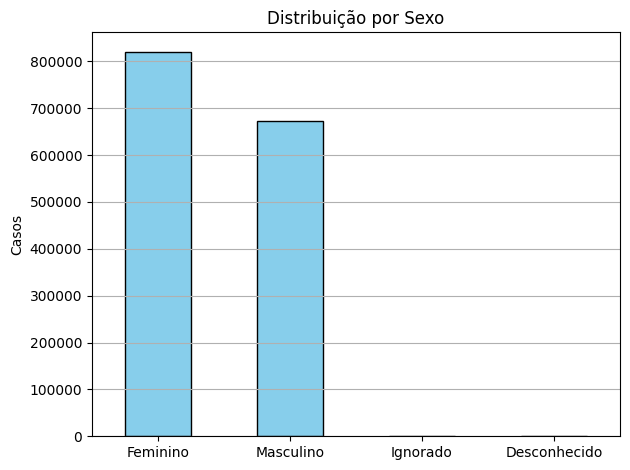

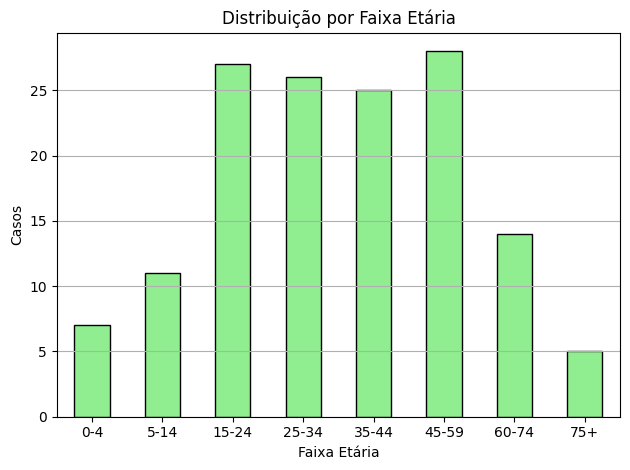

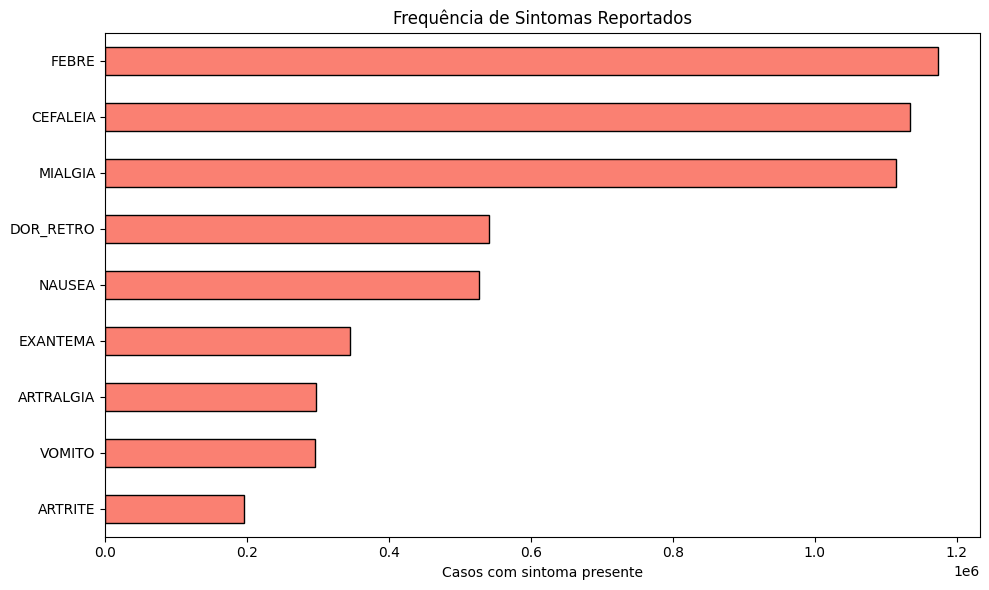

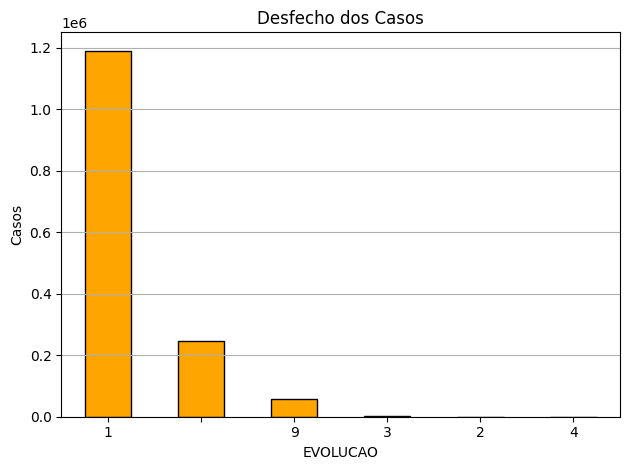

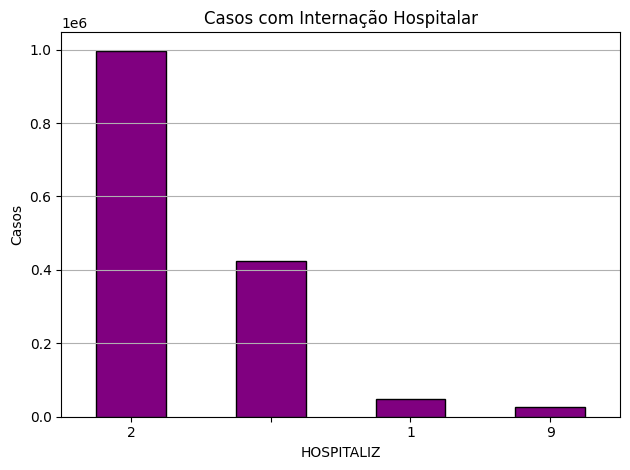

In [1]:
# 2. Importações iniciais
import pandas as pd
import matplotlib.pyplot as plt
from pysus.online_data.SINAN import download

# 3. Download e conversão dos dados
dados = download("DENG", 2020)
df = dados.to_dataframe()

# 4. Preparação e conversões de variáveis

# Datas importantes
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce')
df['DT_SIN_PRI'] = pd.to_datetime(df['DT_SIN_PRI'], errors='coerce')
df['DT_OBITO'] = pd.to_datetime(df['DT_OBITO'], errors='coerce')

# Idade em faixas
df['NU_IDADE_N'] = pd.to_numeric(df['NU_IDADE_N'], errors='coerce')
df['faixa_etaria'] = pd.cut(df['NU_IDADE_N'],
    bins=[0, 5, 14, 24, 34, 44, 59, 74, 120],
    labels=['0-4', '5-14', '15-24', '25-34', '35-44', '45-59', '60-74', '75+'])

# 5. Evolução temporal dos casos
casos_mensais = df['DT_NOTIFIC'].dt.to_period('M').value_counts().sort_index()
casos_mensais = casos_mensais.rename_axis('Mes').reset_index(name='Casos')

plt.figure(figsize=(12,5))
plt.plot(casos_mensais['Mes'].astype(str), casos_mensais['Casos'], marker='o')
plt.title("Casos de DENGUE por mês - Brasil 2020")
plt.xlabel("Mês")
plt.ylabel("Número de Casos")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Distribuição por sexo
sexo_counts = df['CS_SEXO'].value_counts(dropna=False)
sexo_labels = {'M': 'Masculino', 'F': 'Feminino', 'I': 'Ignorado'}
sexo_counts.index = [sexo_labels.get(s, 'Desconhecido') for s in sexo_counts.index]

sexo_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribuição por Sexo")
plt.ylabel("Casos")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 7. Distribuição por faixa etária
faixa_counts = df['faixa_etaria'].value_counts().sort_index()
faixa_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Distribuição por Faixa Etária")
plt.ylabel("Casos")
plt.xlabel("Faixa Etária")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 8. Frequência de sintomas mais comuns (corrigido)
sintomas = ['FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'NAUSEA', 'VOMITO', 'ARTRITE', 'ARTRALGIA', 'DOR_RETRO']

# Converte sintomas para 1/0 (presente/ausente)
df_corrigido = df.copy()
# Conversão robusta sem replace (evita FutureWarning)
for col in sintomas:
    df_corrigido[col] = df_corrigido[col].astype(str).str.strip().map({
        '1': 1,  # presente
        '2': 0,  # ausente
        '9': 0,  # ignorado
        '': 0    # vazio
    }).fillna(0).astype(int)

# Soma frequência dos sintomas
sintomas_freq = df_corrigido[sintomas].sum().sort_values()

# Plota
sintomas_freq.plot(kind='barh', figsize=(10,6), color='salmon', edgecolor='black')
plt.title("Frequência de Sintomas Reportados")
plt.xlabel("Casos com sintoma presente")
plt.tight_layout()
plt.show()


# 9. Desfecho dos casos
if 'EVOLUCAO' in df.columns:
    df['EVOLUCAO'].value_counts(dropna=False).plot(kind='bar', color='orange', edgecolor='black')
    plt.title("Desfecho dos Casos")
    plt.ylabel("Casos")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 10. Internação hospitalar
if 'HOSPITALIZ' in df.columns:
    df['HOSPITALIZ'].value_counts(dropna=False).plot(kind='bar', color='purple', edgecolor='black')
    plt.title("Casos com Internação Hospitalar")
    plt.ylabel("Casos")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


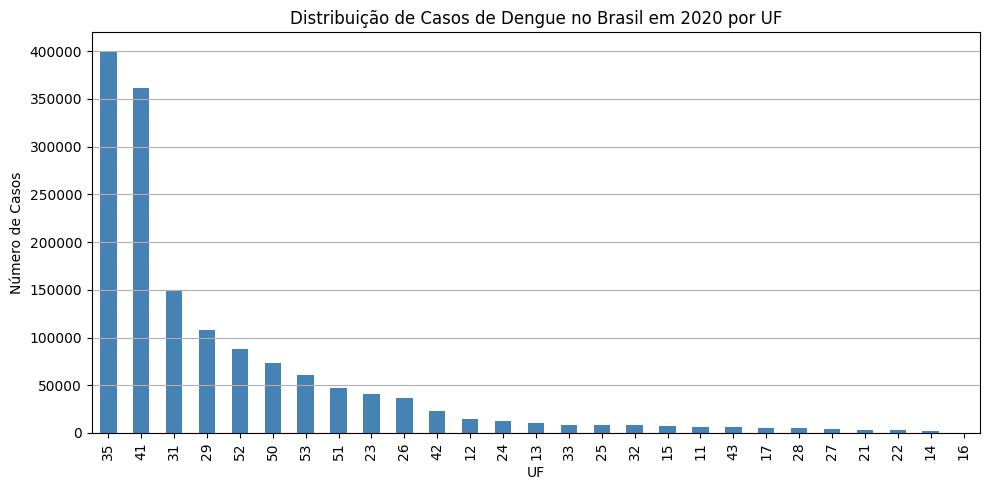

In [5]:
df['SG_UF'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(10,5), color='steelblue')
plt.title("Distribuição de Casos de Dengue no Brasil em 2020 por UF")
plt.xlabel("UF")
plt.ylabel("Número de Casos")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


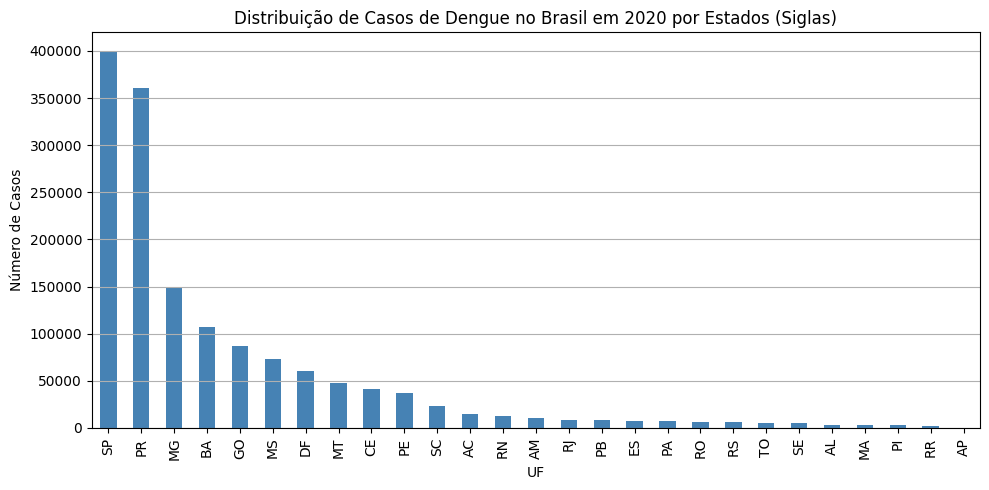

In [7]:
# Dicionário de mapeamento
mapa_uf = {
    11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
    21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL', 28: 'SE', 29: 'BA',
    31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP',
    41: 'PR', 42: 'SC', 43: 'RS',
    50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'
}

# Converte SG_UF para int antes de mapear
uf_counts = df['SG_UF'].astype(int).value_counts().sort_values(ascending=False)
uf_counts.index = uf_counts.index.map(mapa_uf)

# Plota
uf_counts.plot(kind='bar', figsize=(10,5), color='steelblue')
plt.title("Distribuição de Casos de Dengue no Brasil em 2020 por Estados (Siglas)")
plt.xlabel("UF")
plt.ylabel("Número de Casos")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


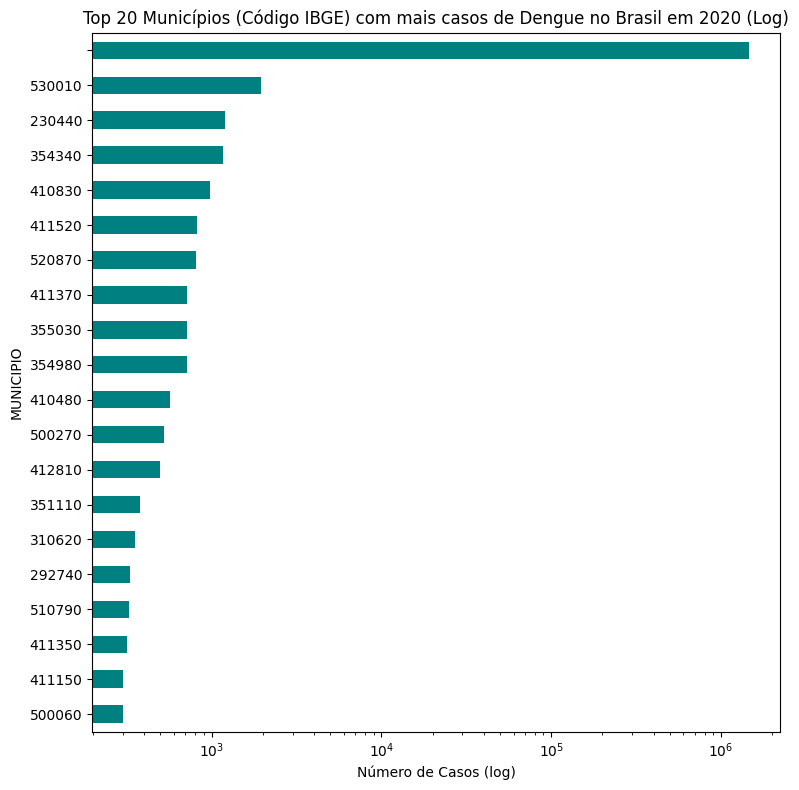

In [10]:
df['MUNICIPIO'].dropna().value_counts().head(20).plot(
    kind='barh', figsize=(8,8), color='teal', logx=True
)

plt.title("Top 20 Municípios (Código IBGE) com mais casos de Dengue no Brasil em 2020 (Log)")
plt.xlabel("Número de Casos (log)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()



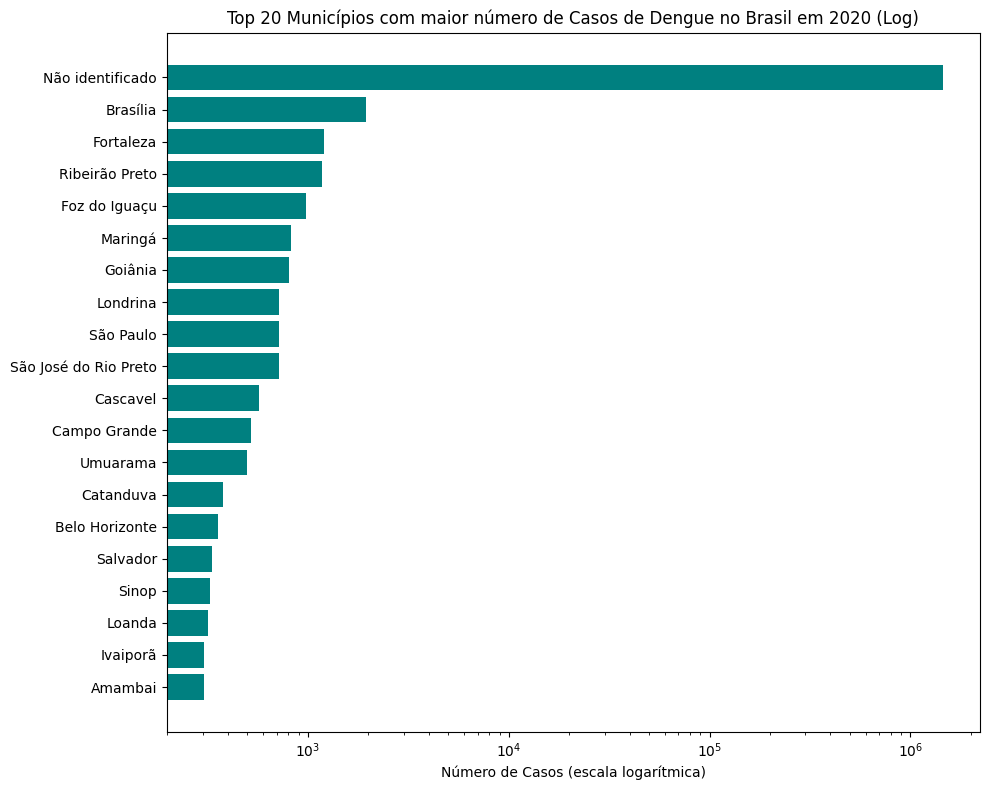

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Obter os top 20 municípios da base SINAN (ajuste se necessário)
top_municipios = df['MUNICIPIO'].dropna().astype(str).str.zfill(6).value_counts().head(20).reset_index()
top_municipios.columns = ['CODUFMUN', 'N_CASOS']

# 2. Baixar a tabela oficial de municípios do repositório PySUS
url = 'https://github.com/cartaproale/PySUS/raw/main/tabelas/municipios.csv'
mun_df = pd.read_csv(url, sep=';', encoding='utf-8', dtype=str)

# 3. Padronizar colunas
mun_df = mun_df.rename(columns={
    'CÓDIGO DO MUNICÍPIO - IBGE': 'CODUFMUN',
    'MUNICÍPIO - IBGE': 'municipio_nome'
})
mun_df['CODUFMUN'] = mun_df['CODUFMUN'].str.strip().str.slice(0,6)

# 4. Merge com nomes legíveis
top_municipios = top_municipios.merge(mun_df[['CODUFMUN', 'municipio_nome']], on='CODUFMUN', how='left')

# 5. Substituir NaN por rótulo genérico
top_municipios['municipio_nome'] = top_municipios['municipio_nome'].fillna('Não identificado')

# 6. Gráfico com escala log e nome genérico para ausentes
plt.figure(figsize=(10,8))
plt.barh(top_municipios['municipio_nome'], top_municipios['N_CASOS'], color='teal')
plt.xscale('log')
plt.xlabel("Número de Casos (escala logarítmica)")
plt.title("Top 20 Municípios com maior número de Casos de Dengue no Brasil em 2020 (Log)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()




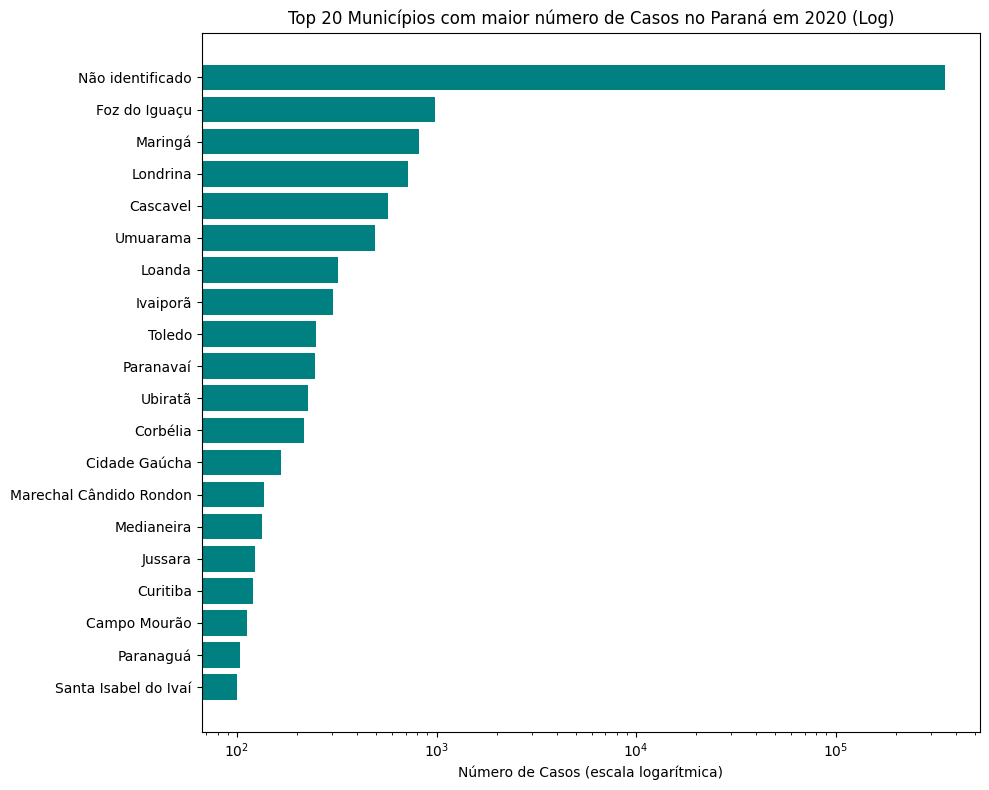

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define o código da UF desejada (Paraná = 41)
codigo_uf = '41'

# 2. Filtra o DataFrame para o estado selecionado
df_estado = df[df['SG_UF'] == codigo_uf].copy()

# 3. Agrupa os 20 municípios com mais casos no estado
top_municipios_estado = (
    df_estado['MUNICIPIO']
    .dropna()
    .astype(str)
    .str.zfill(6)
    .value_counts()
    .head(20)
    .reset_index()
)
top_municipios_estado.columns = ['CODUFMUN', 'N_CASOS']

# 4. Baixa a tabela oficial de municípios do repositório PySUS
url = 'https://github.com/cartaproale/PySUS/raw/main/tabelas/municipios.csv'
mun_df = pd.read_csv(url, sep=';', encoding='utf-8', dtype=str)

# 5. Padroniza e limpa colunas
mun_df = mun_df.rename(columns={
    'CÓDIGO DO MUNICÍPIO - IBGE': 'CODUFMUN',
    'MUNICÍPIO - IBGE': 'municipio_nome'
})
mun_df['CODUFMUN'] = mun_df['CODUFMUN'].str.strip().str.slice(0,6)

# 6. Faz merge com nomes legíveis
top_municipios_estado = top_municipios_estado.merge(
    mun_df[['CODUFMUN', 'municipio_nome']],
    on='CODUFMUN',
    how='left'
)

# 7. Substitui ausentes
top_municipios_estado['municipio_nome'] = top_municipios_estado['municipio_nome'].fillna('Não identificado')

# 8. Plota gráfico horizontal com escala logarítmica
plt.figure(figsize=(10,8))
plt.barh(top_municipios_estado['municipio_nome'], top_municipios_estado['N_CASOS'], color='teal')
plt.xscale('log')
plt.xlabel("Número de Casos (escala logarítmica)")
plt.title("Top 20 Municípios com maior número de Casos no Paraná em 2020 (Log)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


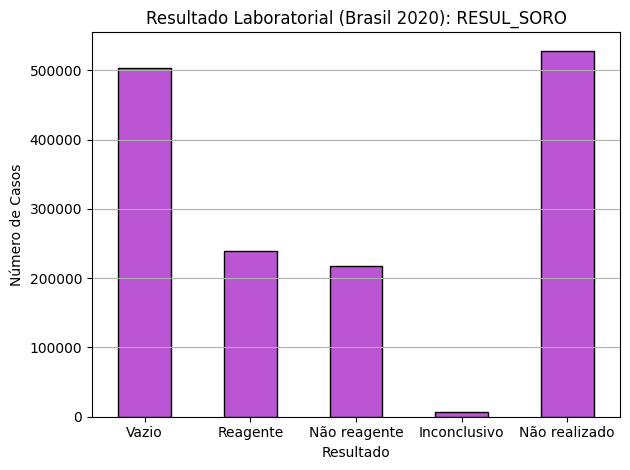

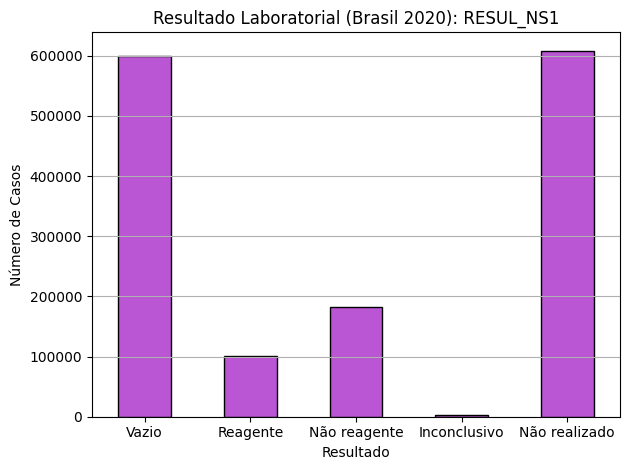

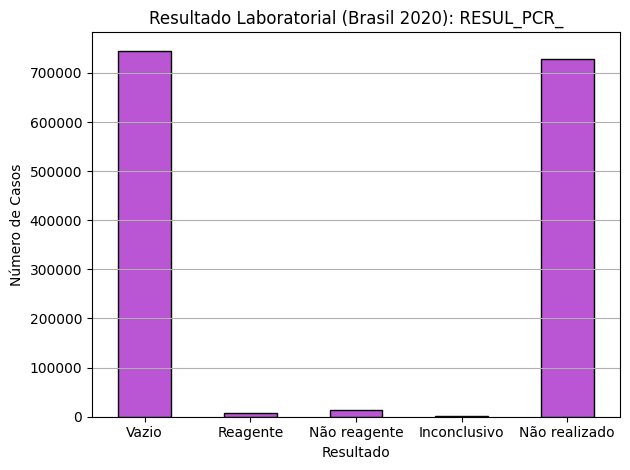

In [ ]:
# Mapeamento de códigos padronizados como strings
mapa_resposta = {
    '1': 'Reagente',
    '2': 'Não reagente',
    '3': 'Inconclusivo',
    '4': 'Não realizado',
    '9': 'Ignorado',
    '': 'Vazio',
    'nan': 'Não informado'
}

# Lista de variáveis de teste
testes = ['RESUL_SORO', 'RESUL_NS1', 'RESUL_PCR_']

# Loop com conversão segura
for teste in testes:
    if teste in df.columns:
        # Converte todos os valores para string e normaliza
        valores = df[teste].astype(str).str.strip().replace('nan', 'nan').value_counts(dropna=False).sort_index()
        valores.index = [mapa_resposta.get(v, f'Código {v}') for v in valores.index]

        # Gráfico
        valores.plot(kind='bar', color='mediumorchid', edgecolor='black')
        plt.title(f"Resultado Laboratorial (Brasil 2020): {teste}")
        plt.xlabel("Resultado")
        plt.ylabel("Número de Casos")
        plt.xticks(rotation=0)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()



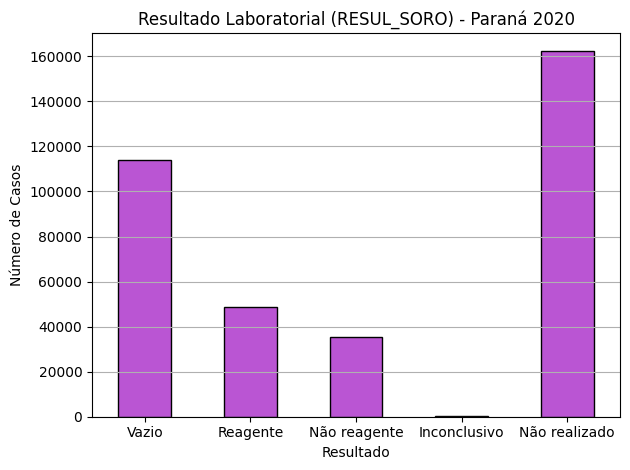

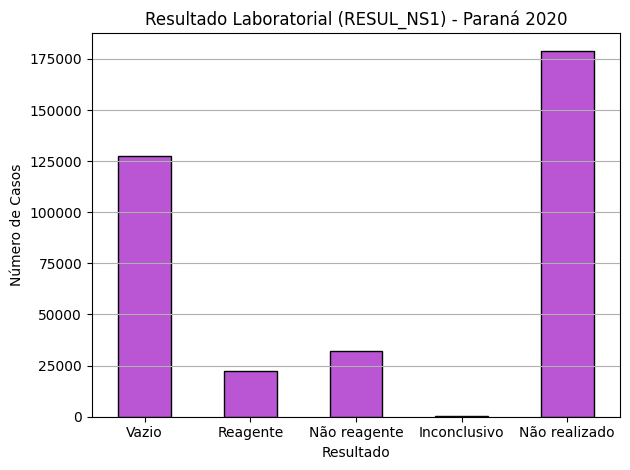

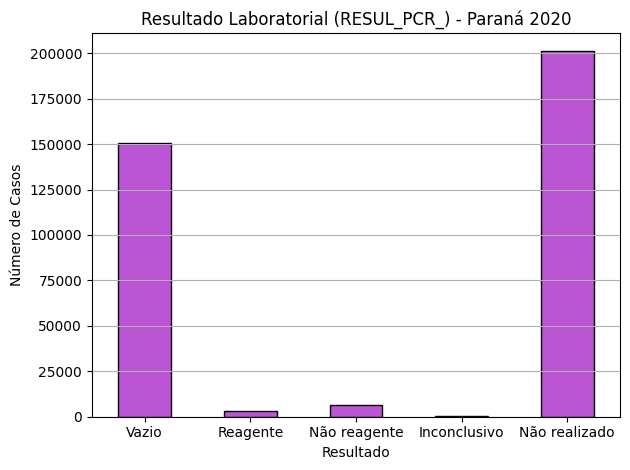

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Código do estado desejado (Paraná = '41')
codigo_uf = '41'

# 2. Filtra os dados para o estado
df_estado = df[df['SG_UF'] == codigo_uf].copy()

# 3. Mapeamento de códigos padronizados como strings
mapa_resposta = {
    '1': 'Reagente',
    '2': 'Não reagente',
    '3': 'Inconclusivo',
    '4': 'Não realizado',
    '9': 'Ignorado',
    '': 'Vazio',
    'nan': 'Não informado'
}

# 4. Lista de variáveis de teste
testes = ['RESUL_SORO', 'RESUL_NS1', 'RESUL_PCR_']

# 5. Loop com conversão e visualização por variável
for teste in testes:
    if teste in df_estado.columns:
        # Converte todos os valores para string e normaliza
        valores = df_estado[teste].astype(str).str.strip().replace('nan', 'nan').value_counts(dropna=False).sort_index()

        # Aplica mapeamento para rótulos compreensíveis
        valores.index = [mapa_resposta.get(v, f'Código {v}') for v in valores.index]

        # Gera gráfico
        valores.plot(kind='bar', color='mediumorchid', edgecolor='black')
        plt.title(f"Resultado Laboratorial ({teste}) - Paraná 2020")
        plt.xlabel("Resultado")
        plt.ylabel("Número de Casos")
        plt.xticks(rotation=0)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()


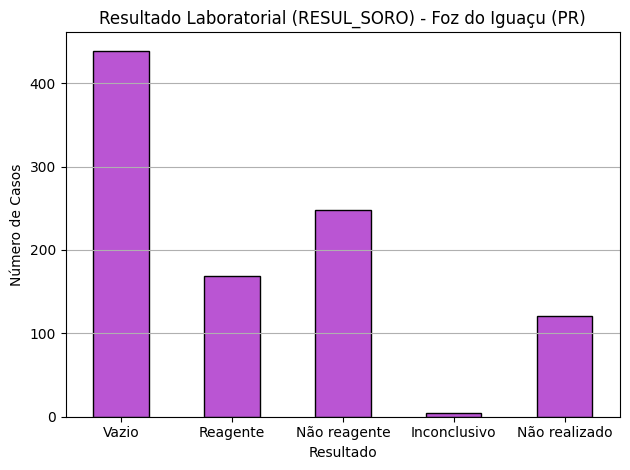

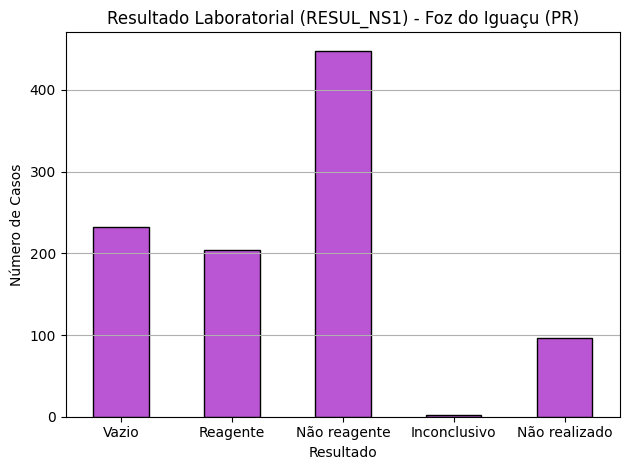

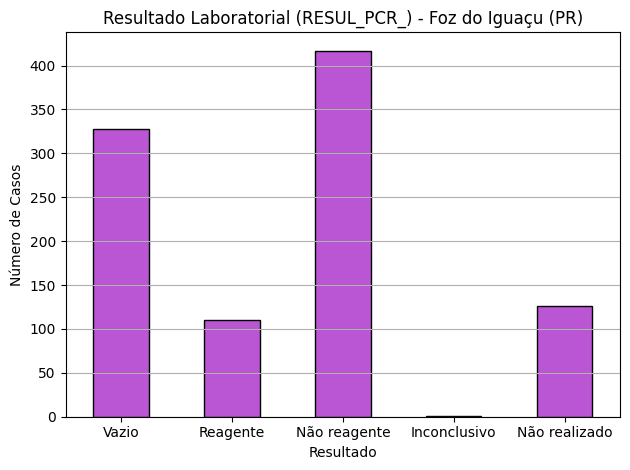

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Código IBGE do município de Foz do Iguaçu
codigo_municipio = '410830'

# 2. Filtra os dados apenas para Foz do Iguaçu
df_municipio = df[df['MUNICIPIO'].astype(str).str.zfill(6) == codigo_municipio].copy()

# 3. Mapeamento de códigos padronizados
mapa_resposta = {
    '1': 'Reagente',
    '2': 'Não reagente',
    '3': 'Inconclusivo',
    '4': 'Não realizado',
    '9': 'Ignorado',
    '': 'Vazio',
    'nan': 'Não informado'
}

# 4. Lista de variáveis de teste
testes = ['RESUL_SORO', 'RESUL_NS1', 'RESUL_PCR_']

# 5. Loop por teste
for teste in testes:
    if teste in df_municipio.columns:
        valores = df_municipio[teste].astype(str).str.strip().replace('nan', 'nan').value_counts(dropna=False).sort_index()
        valores.index = [mapa_resposta.get(v, f'Código {v}') for v in valores.index]

        # Gráfico
        valores.plot(kind='bar', color='mediumorchid', edgecolor='black')
        plt.title(f"Resultado Laboratorial ({teste}) - Foz do Iguaçu (PR)")
        plt.xlabel("Resultado")
        plt.ylabel("Número de Casos")
        plt.xticks(rotation=0)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()


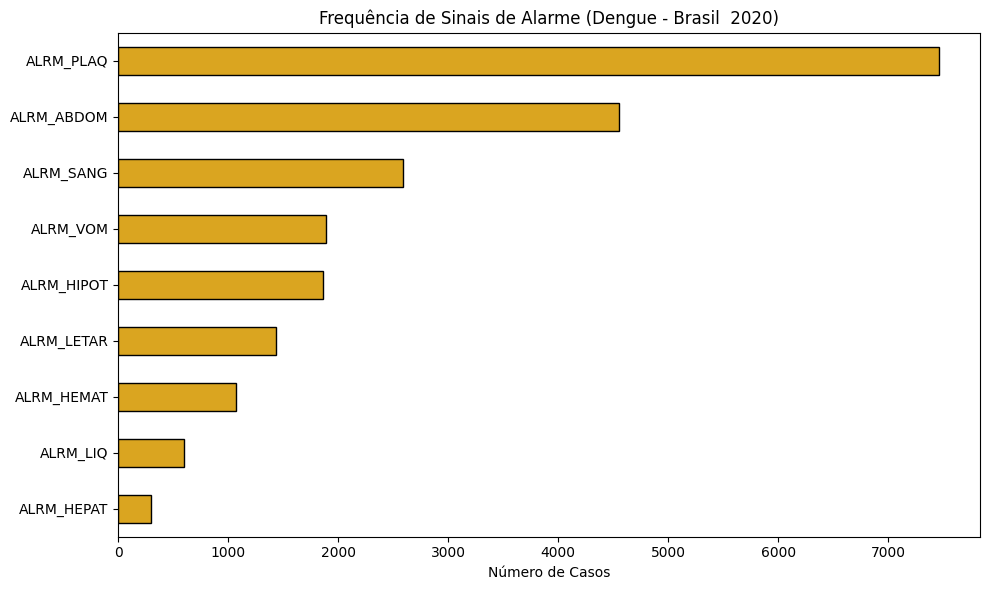

In [ ]:
import matplotlib.pyplot as plt

# 1. Seleciona colunas de sinais de alarme
alarmes = [col for col in df.columns if col.startswith("ALRM_")]
df_alarme = df[alarmes].copy()

# 2. Conversão robusta: '1' → 1, outros valores ou vazios → 0
for col in alarmes:
    df_alarme[col] = df_alarme[col].astype(str).str.strip()
    df_alarme[col] = df_alarme[col].apply(lambda x: 1 if x == '1' else 0)

# 3. Conta a frequência de cada sinal (presença = 1)
frequencia = df_alarme.apply(sum).sort_values()

# 4. Gráfico final
plt.figure(figsize=(10,6))
frequencia.plot(kind='barh', color='goldenrod', edgecolor='black')
plt.title("Frequência de Sinais de Alarme (Dengue - Brasil  2020)")
plt.xlabel("Número de Casos")
plt.tight_layout()
plt.show()



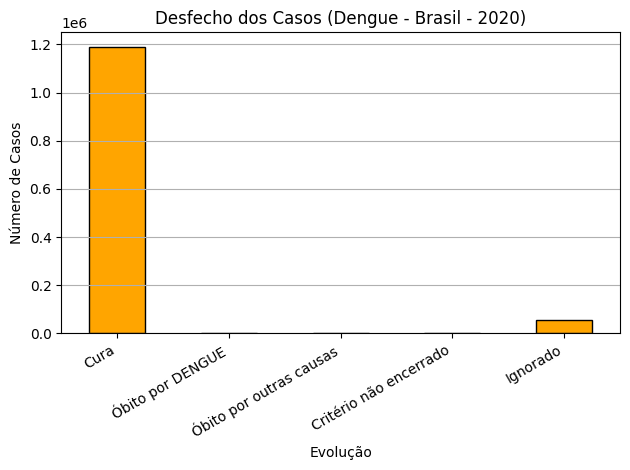

In [ ]:
# Mapeamento de códigos da variável EVOLUCAO
evolucao_labels = {
    1: 'Cura',
    2: 'Óbito por DENGUE',
    3: 'Óbito por outras causas',
    4: 'Critério não encerrado',
    9: 'Ignorado'
}

# Corrigir e limpar a coluna antes de contar
evolucao_freq = (
    df['EVOLUCAO']
    .replace('', pd.NA)              # Substitui strings vazias por NA
    .dropna()                        # Remove ausentes
    .astype('Int64')                 # Converte com segurança
    .value_counts()
    .sort_index()
)

# Mapear os rótulos descritivos
evolucao_freq.index = evolucao_freq.index.map(lambda x: evolucao_labels.get(x, f'Cód {x}'))

# Plotar o gráfico
evolucao_freq.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Desfecho dos Casos (Dengue - Brasil - 2020)")
plt.xlabel("Evolução")
plt.ylabel("Número de Casos")
plt.xticks(rotation=30, ha='right')  # ângulo de 30°, alinhamento à direita
plt.grid(axis='y')
plt.tight_layout()
plt.show()






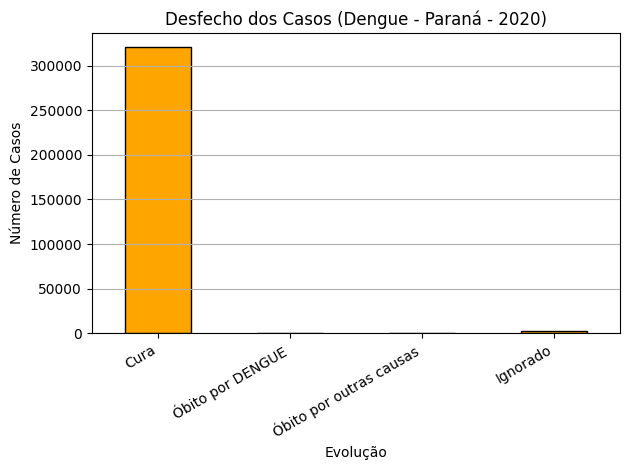

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define o código do Paraná (SG_UF = '41')
df_estado = df[df['SG_UF'] == '41'].copy()

# 2. Mapeamento de códigos da variável EVOLUCAO
evolucao_labels = {
    1: 'Cura',
    2: 'Óbito por DENGUE',
    3: 'Óbito por outras causas',
    4: 'Critério não encerrado',
    9: 'Ignorado'
}

# 3. Corrige e contabiliza a variável EVOLUCAO para o estado
evolucao_freq = (
    df_estado['EVOLUCAO']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts()
    .sort_index()
)

# 4. Aplica os rótulos compreensíveis
evolucao_freq.index = evolucao_freq.index.map(lambda x: evolucao_labels.get(x, f'Cód {x}'))

# 5. Gera o gráfico
evolucao_freq.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Desfecho dos Casos (Dengue - Paraná - 2020)")
plt.xlabel("Evolução")
plt.ylabel("Número de Casos")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


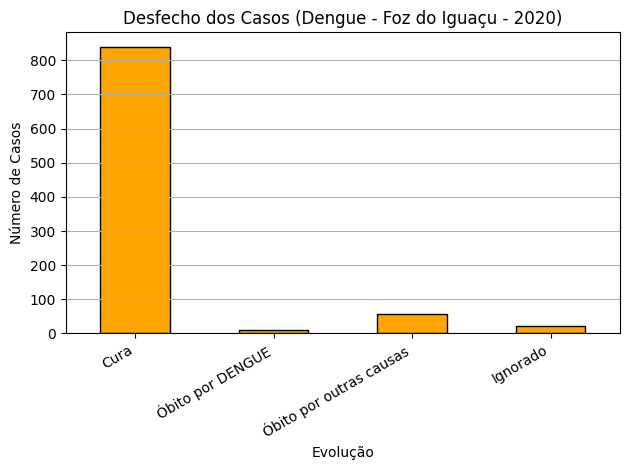

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra o estado do Paraná (SG_UF = '41')
df_estado = df[df['SG_UF'] == '41'].copy()

# 2. Filtra o município de Foz do Iguaçu (código IBGE 410830, como string zeropadded)
df_foz = df_estado[df_estado['MUNICIPIO'].astype(str).str.zfill(6) == '410830'].copy()

# 3. Mapeamento de códigos da variável EVOLUCAO
evolucao_labels = {
    1: 'Cura',
    2: 'Óbito por DENGUE',
    3: 'Óbito por outras causas',
    4: 'Critério não encerrado',
    9: 'Ignorado'
}

# 4. Corrige e contabiliza a variável EVOLUCAO
evolucao_freq = (
    df_foz['EVOLUCAO']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts()
    .sort_index()
)

# 5. Aplica os rótulos compreensíveis
evolucao_freq.index = evolucao_freq.index.map(lambda x: evolucao_labels.get(x, f'Cód {x}'))

# 6. Gera o gráfico
evolucao_freq.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Desfecho dos Casos (Dengue - Foz do Iguaçu - 2020)")
plt.xlabel("Evolução")
plt.ylabel("Número de Casos")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

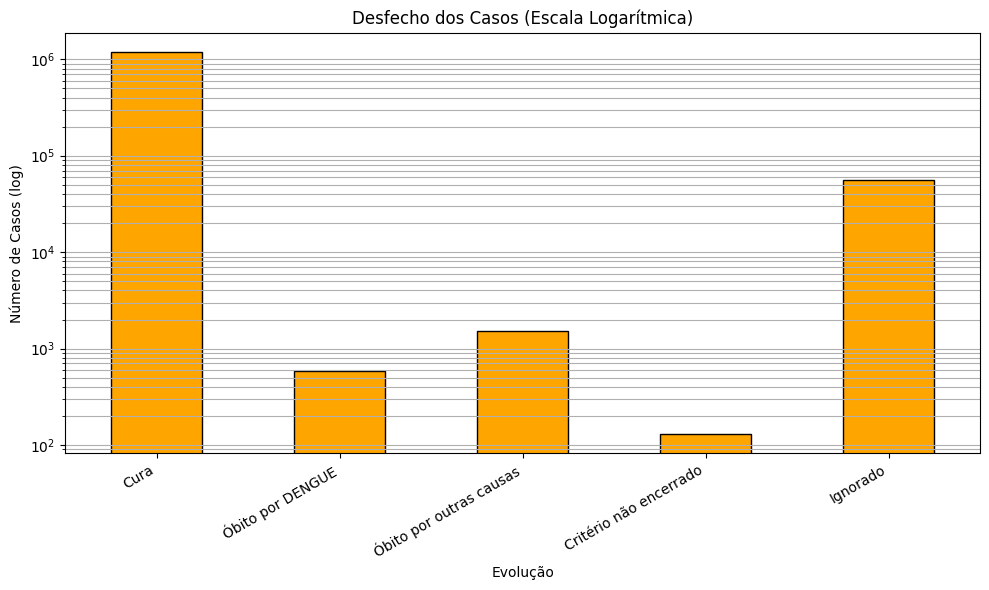

In [ ]:
# Gráfico com escala logarítmica no eixo Y
plt.figure(figsize=(10,6))
evolucao_freq.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Desfecho dos Casos (Escala Logarítmica - Brasil 2020)")
plt.xlabel("Evolução")
plt.ylabel("Número de Casos (log)")
plt.yscale('log')  # Escala log no eixo Y
plt.xticks(rotation=30, ha='right')
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.show()


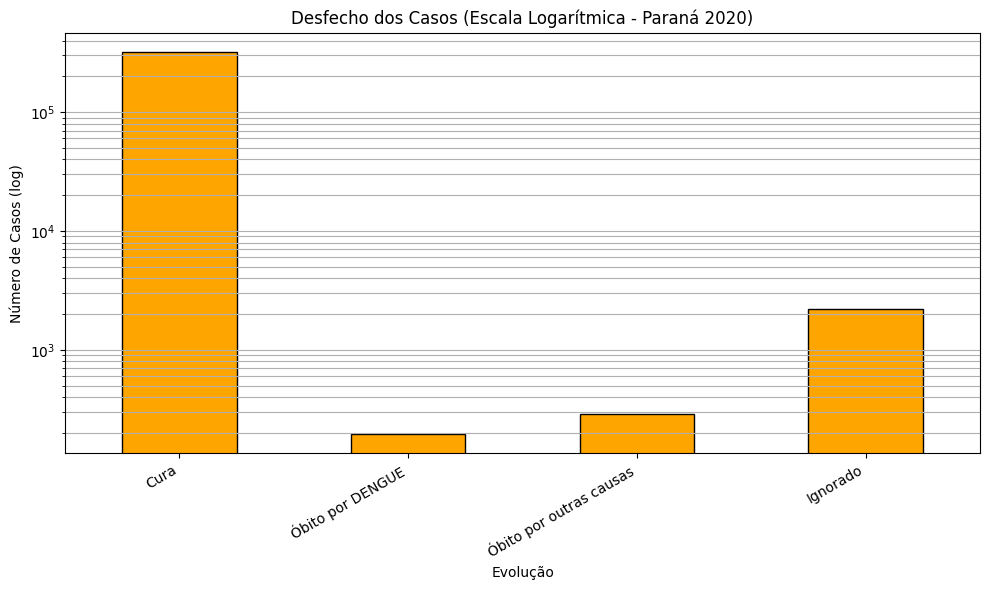

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtrar apenas o estado do Paraná
df_estado = df[df['SG_UF'] == '41'].copy()

# 2. Mapeamento dos rótulos da variável EVOLUCAO
evolucao_labels = {
    1: 'Cura',
    2: 'Óbito por DENGUE',
    3: 'Óbito por outras causas',
    4: 'Critério não encerrado',
    9: 'Ignorado'
}

# 3. Contar os valores de EVOLUCAO no Paraná com tratamento
evolucao_freq = (
    df_estado['EVOLUCAO']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts()
    .sort_index()
)

# 4. Aplicar rótulos descritivos
evolucao_freq.index = evolucao_freq.index.map(lambda x: evolucao_labels.get(x, f'Cód {x}'))

# 5. Gerar gráfico com escala logarítmica
plt.figure(figsize=(10,6))
evolucao_freq.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Desfecho dos Casos (Escala Logarítmica - Paraná 2020)")
plt.xlabel("Evolução")
plt.ylabel("Número de Casos (log)")
plt.yscale('log')  # Escala log no eixo Y
plt.xticks(rotation=30, ha='right')
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.show()


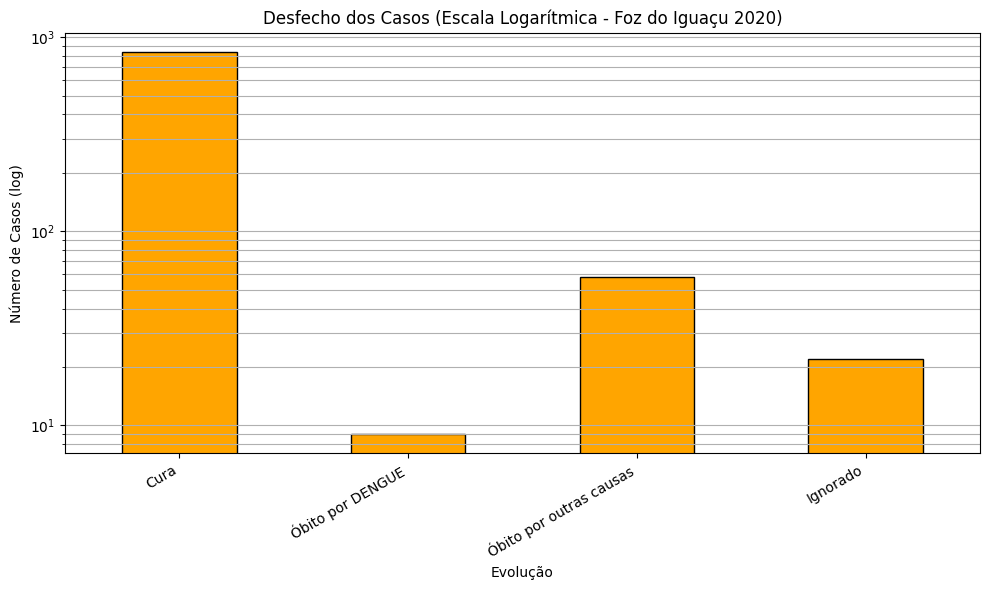

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtrar apenas registros do município de Foz do Iguaçu (SG_UF='41' e município código '410830')
df_foz = df[(df['SG_UF'] == '41') & (df['MUNICIPIO'] == '410830')].copy()

# 2. Mapeamento dos rótulos da variável EVOLUCAO
evolucao_labels = {
    1: 'Cura',
    2: 'Óbito por DENGUE',
    3: 'Óbito por outras causas',
    4: 'Critério não encerrado',
    9: 'Ignorado'
}

# 3. Contar os valores da coluna EVOLUCAO com tratamento
evolucao_freq = (
    df_foz['EVOLUCAO']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts()
    .sort_index()
)

# 4. Aplicar rótulos compreensíveis
evolucao_freq.index = evolucao_freq.index.map(lambda x: evolucao_labels.get(x, f'Cód {x}'))

# 5. Gráfico com escala logarítmica no eixo Y
plt.figure(figsize=(10,6))
evolucao_freq.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Desfecho dos Casos (Escala Logarítmica - Foz do Iguaçu 2020)")
plt.xlabel("Evolução")
plt.ylabel("Número de Casos (log)")
plt.yscale('log')  # Escala log no eixo Y
plt.xticks(rotation=30, ha='right')
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.show()


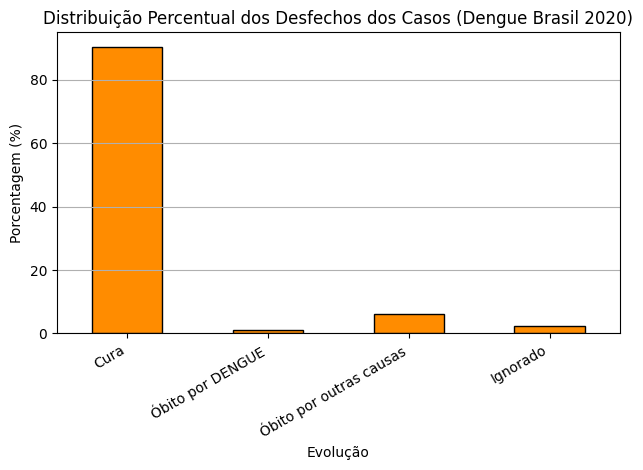

In [ ]:
# Contagem relativa por tipo de evolução
evolucao_percent = evolucao_freq / evolucao_freq.sum() * 100

# Gráfico em percentual
evolucao_percent.plot(kind='bar', color='darkorange', edgecolor='black')
plt.title("Distribuição Percentual dos Desfechos dos Casos (Dengue Brasil 2020)")
plt.xlabel("Evolução")
plt.ylabel("Porcentagem (%)")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


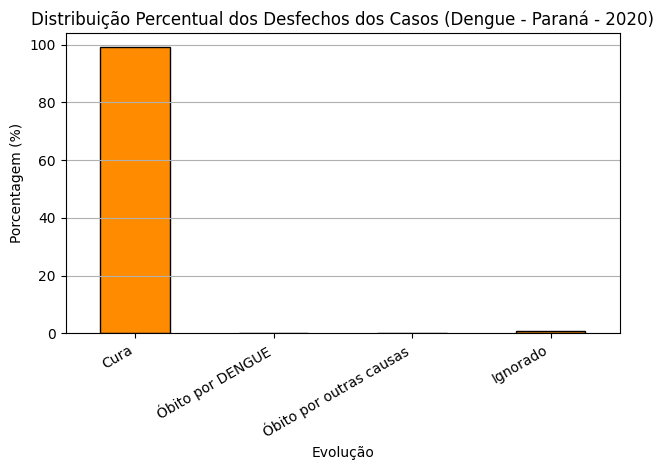

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra os dados para o Paraná (SG_UF = '41')
df_parana = df[df['SG_UF'] == '41'].copy()

# 2. Mapeamento dos rótulos da variável EVOLUCAO
evolucao_labels = {
    1: 'Cura',
    2: 'Óbito por DENGUE',
    3: 'Óbito por outras causas',
    4: 'Critério não encerrado',
    9: 'Ignorado'
}

# 3. Contagem absoluta por desfecho
evolucao_freq = (
    df_parana['EVOLUCAO']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts()
    .sort_index()
)

# 4. Mapeia os índices para rótulos compreensíveis
evolucao_freq.index = evolucao_freq.index.map(lambda x: evolucao_labels.get(x, f'Cód {x}'))

# 5. Calcula os percentuais
evolucao_percent = evolucao_freq / evolucao_freq.sum() * 100

# 6. Gráfico percentual
evolucao_percent.plot(kind='bar', color='darkorange', edgecolor='black')
plt.title("Distribuição Percentual dos Desfechos dos Casos (Dengue - Paraná - 2020)")
plt.xlabel("Evolução")
plt.ylabel("Porcentagem (%)")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


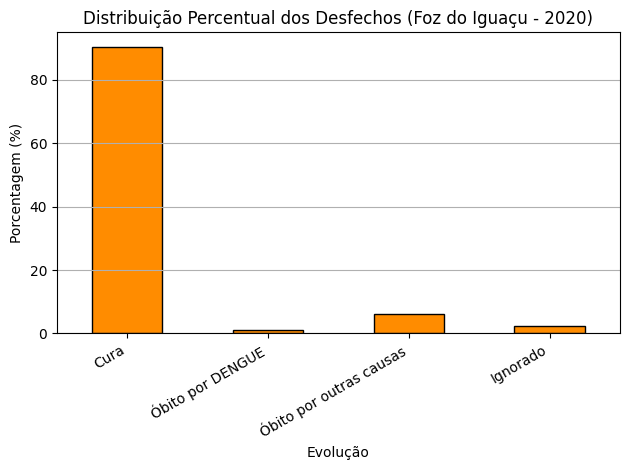

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra os dados apenas para Foz do Iguaçu (SG_UF = '41' e MUNICIPIO = '410830')
df_foz = df[
    (df['SG_UF'] == '41') &
    (df['MUNICIPIO'].astype(str).str.zfill(6) == '410830')
].copy()

# 2. Mapeamento dos códigos de evolução
evolucao_labels = {
    1: 'Cura',
    2: 'Óbito por DENGUE',
    3: 'Óbito por outras causas',
    4: 'Critério não encerrado',
    9: 'Ignorado'
}

# 3. Contagem absoluta por tipo de evolução
evolucao_freq = (
    df_foz['EVOLUCAO']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts()
    .sort_index()
)

# 4. Mapeia rótulos descritivos
evolucao_freq.index = evolucao_freq.index.map(lambda x: evolucao_labels.get(x, f'Cód {x}'))

# 5. Calcula proporções percentuais
evolucao_percent = evolucao_freq / evolucao_freq.sum() * 100

# 6. Gera o gráfico
evolucao_percent.plot(kind='bar', color='darkorange', edgecolor='black')
plt.title("Distribuição Percentual dos Desfechos (Foz do Iguaçu - 2020)")
plt.xlabel("Evolução")
plt.ylabel("Porcentagem (%)")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


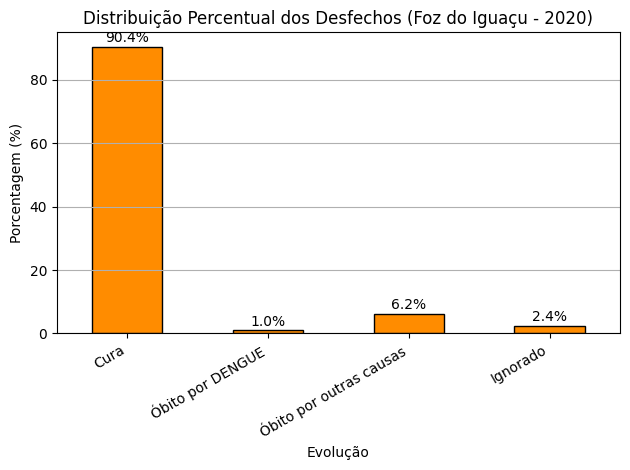

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra os dados para Foz do Iguaçu
df_foz = df[
    (df['SG_UF'] == '41') &
    (df['MUNICIPIO'].astype(str).str.zfill(6) == '410830')
].copy()

# 2. Mapeamento dos códigos da coluna EVOLUCAO
evolucao_labels = {
    1: 'Cura',
    2: 'Óbito por DENGUE',
    3: 'Óbito por outras causas',
    4: 'Critério não encerrado',
    9: 'Ignorado'
}

# 3. Frequência absoluta
evolucao_freq = (
    df_foz['EVOLUCAO']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts()
    .sort_index()
)

# 4. Mapeia os rótulos compreensíveis
evolucao_freq.index = evolucao_freq.index.map(lambda x: evolucao_labels.get(x, f'Cód {x}'))

# 5. Calcula os percentuais
evolucao_percent = evolucao_freq / evolucao_freq.sum() * 100

# 6. Gera o gráfico com os percentuais no topo das barras
ax = evolucao_percent.plot(kind='bar', color='darkorange', edgecolor='black')
plt.title("Distribuição Percentual dos Desfechos (Foz do Iguaçu - 2020)")
plt.xlabel("Evolução")
plt.ylabel("Porcentagem (%)")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y')
plt.tight_layout()

# 7. Adiciona os rótulos nas barras
for i, valor in enumerate(evolucao_percent):
    ax.text(i, valor + 0.5, f'{valor:.1f}%', ha='center', va='bottom', fontsize=10)

plt.show()


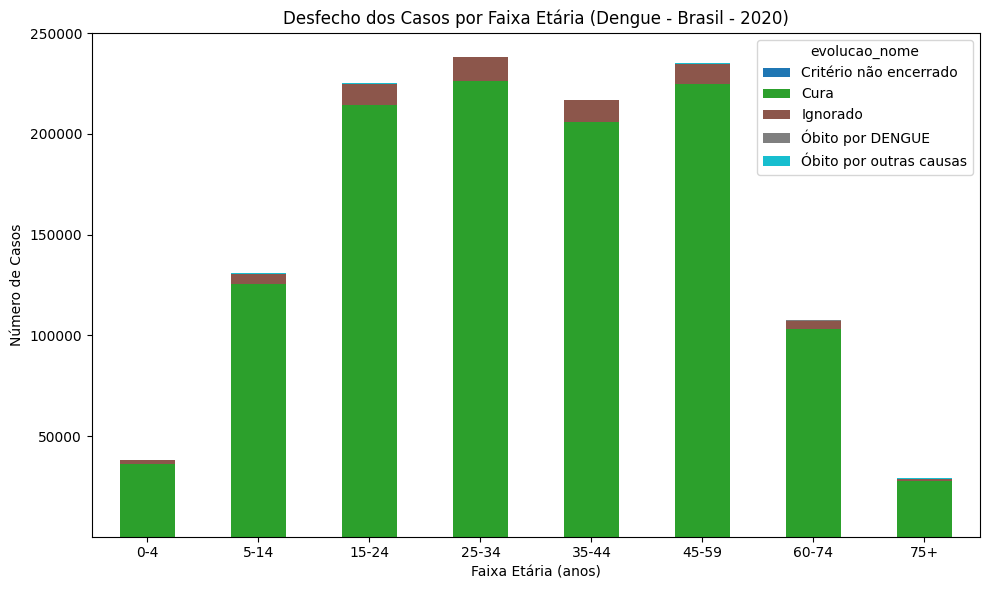

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Converte datas de nascimento e notificação
df['DT_NASC'] = pd.to_datetime(df['DT_NASC'], format='%Y%m%d', errors='coerce')
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce')

# 2. Calcula idade com base nas datas (método robusto)
def calcular_idade(row):
    if pd.isna(row['DT_NASC']) or pd.isna(row['DT_NOTIFIC']):
        return np.nan
    idade = row['DT_NOTIFIC'].year - row['DT_NASC'].year
    if (row['DT_NOTIFIC'].month, row['DT_NOTIFIC'].day) < (row['DT_NASC'].month, row['DT_NASC'].day):
        idade -= 1
    return idade

df['IDADE_CALCULADA'] = df.apply(calcular_idade, axis=1)

# 3. Cria faixas etárias com base na idade calculada
df['faixa_etaria'] = pd.cut(
    df['IDADE_CALCULADA'],
    bins=[0, 4, 14, 24, 34, 44, 59, 74, 120],
    labels=['0-4', '5-14', '15-24', '25-34', '35-44', '45-59', '60-74', '75+']
)

# 4. Limpa e mapeia a variável EVOLUCAO
df['EVOLUCAO_LIMPA'] = df['EVOLUCAO'].replace('', pd.NA).astype('Int64')
df['evolucao_nome'] = df['EVOLUCAO_LIMPA'].map({
    1: 'Cura',
    2: 'Óbito por DENGUE',
    3: 'Óbito por outras causas',
    4: 'Critério não encerrado',
    9: 'Ignorado'
})

# 5. Tabela cruzada faixa × desfecho
tabela = pd.crosstab(df['faixa_etaria'], df['evolucao_nome'])

# 6. Gráfico empilhado
tabela.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab10')
plt.title("Desfecho dos Casos por Faixa Etária (Dengue - Brasil - 2020)")
plt.xlabel("Faixa Etária (anos)")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



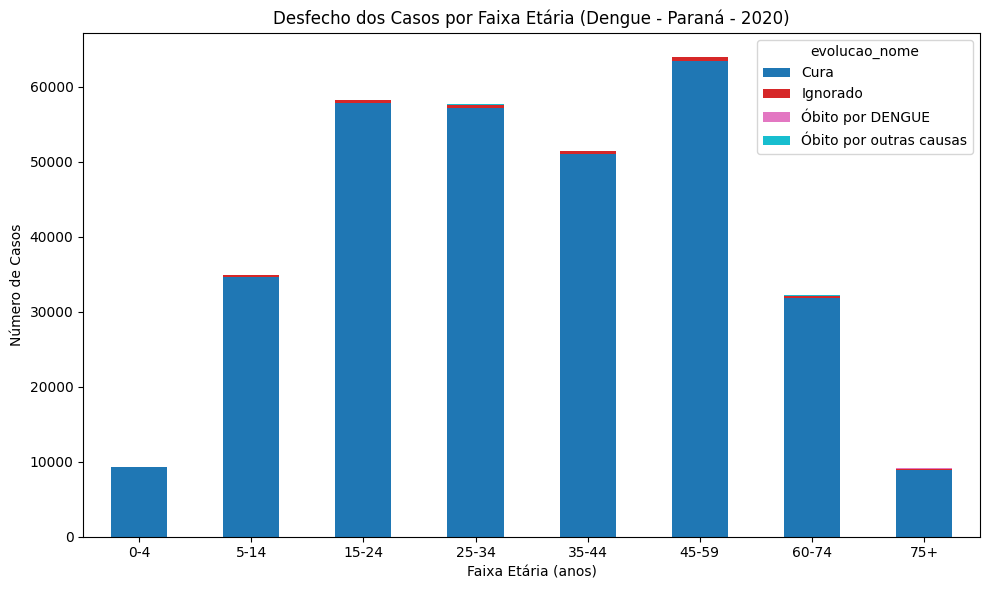

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Filtra os dados do Paraná
df_parana = df[df['SG_UF'] == '41'].copy()

# 2. Converte as datas de nascimento e notificação
df_parana['DT_NASC'] = pd.to_datetime(df_parana['DT_NASC'], format='%Y%m%d', errors='coerce')
df_parana['DT_NOTIFIC'] = pd.to_datetime(df_parana['DT_NOTIFIC'], errors='coerce')

# 3. Calcula a idade corretamente com base nas datas
def calcular_idade(row):
    if pd.isna(row['DT_NASC']) or pd.isna(row['DT_NOTIFIC']):
        return np.nan
    idade = row['DT_NOTIFIC'].year - row['DT_NASC'].year
    if (row['DT_NOTIFIC'].month, row['DT_NOTIFIC'].day) < (row['DT_NASC'].month, row['DT_NASC'].day):
        idade -= 1
    return idade

df_parana['IDADE_CALCULADA'] = df_parana.apply(calcular_idade, axis=1)

# 4. Cria faixa etária com base na idade calculada
df_parana['faixa_etaria'] = pd.cut(
    df_parana['IDADE_CALCULADA'],
    bins=[0, 4, 14, 24, 34, 44, 59, 74, 120],
    labels=['0-4', '5-14', '15-24', '25-34', '35-44', '45-59', '60-74', '75+']
)

# 5. Mapeia a variável EVOLUCAO
df_parana['EVOLUCAO_LIMPA'] = df_parana['EVOLUCAO'].replace('', pd.NA).astype('Int64')
df_parana['evolucao_nome'] = df_parana['EVOLUCAO_LIMPA'].map({
    1: 'Cura',
    2: 'Óbito por DENGUE',
    3: 'Óbito por outras causas',
    4: 'Critério não encerrado',
    9: 'Ignorado'
})

# 6. Gera tabela cruzada: faixa etária × desfecho
tabela = pd.crosstab(df_parana['faixa_etaria'], df_parana['evolucao_nome'])

# 7. Gráfico empilhado
tabela.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab10')
plt.title("Desfecho dos Casos por Faixa Etária (Dengue - Paraná - 2020)")
plt.xlabel("Faixa Etária (anos)")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



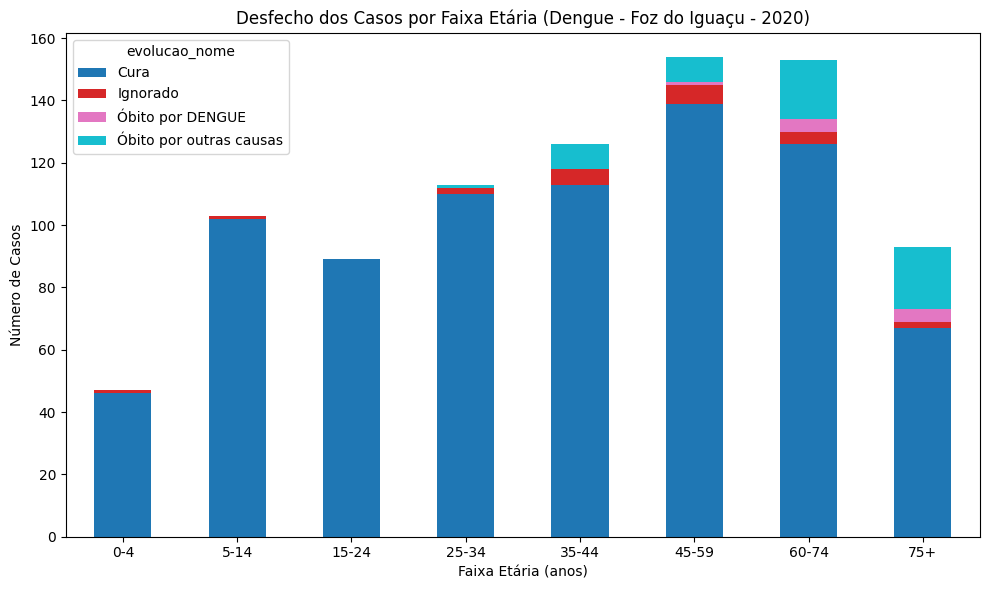

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Filtra os dados para Foz do Iguaçu (SG_UF = '41', MUNICIPIO = '410830')
df_foz = df[
    (df['SG_UF'] == '41') &
    (df['MUNICIPIO'].astype(str).str.zfill(6) == '410830')
].copy()

# 2. Converte DT_NASC e DT_NOTIFIC para datetime
df_foz['DT_NASC'] = pd.to_datetime(df_foz['DT_NASC'], format='%Y%m%d', errors='coerce')
df_foz['DT_NOTIFIC'] = pd.to_datetime(df_foz['DT_NOTIFIC'], errors='coerce')

# 3. Calcula a idade com base nas datas
def calcular_idade(row):
    if pd.isna(row['DT_NASC']) or pd.isna(row['DT_NOTIFIC']):
        return np.nan
    idade = row['DT_NOTIFIC'].year - row['DT_NASC'].year
    if (row['DT_NOTIFIC'].month, row['DT_NOTIFIC'].day) < (row['DT_NASC'].month, row['DT_NASC'].day):
        idade -= 1
    return idade

df_foz['IDADE_CALCULADA'] = df_foz.apply(calcular_idade, axis=1)

# 4. Cria faixa etária com base na idade calculada
df_foz['faixa_etaria'] = pd.cut(
    df_foz['IDADE_CALCULADA'],
    bins=[0, 4, 14, 24, 34, 44, 59, 74, 120],
    labels=['0-4', '5-14', '15-24', '25-34', '35-44', '45-59', '60-74', '75+']
)

# 5. Limpa e mapeia EVOLUCAO
df_foz['EVOLUCAO_LIMPA'] = df_foz['EVOLUCAO'].replace('', pd.NA).astype('Int64')
df_foz['evolucao_nome'] = df_foz['EVOLUCAO_LIMPA'].map({
    1: 'Cura',
    2: 'Óbito por DENGUE',
    3: 'Óbito por outras causas',
    4: 'Critério não encerrado',
    9: 'Ignorado'
})

# 6. Tabela cruzada: faixa etária × desfecho
tabela = pd.crosstab(df_foz['faixa_etaria'], df_foz['evolucao_nome']).fillna(0)

# 7. Verifica se há dados e plota
if not tabela.empty and tabela.select_dtypes(include='number').sum().sum() > 0:
    tabela.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab10')
    plt.title("Desfecho dos Casos por Faixa Etária (Dengue - Foz do Iguaçu - 2020)")
    plt.xlabel("Faixa Etária (anos)")
    plt.ylabel("Número de Casos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Nenhum dado disponível para Foz do Iguaçu com desfecho e faixa etária definidos.")




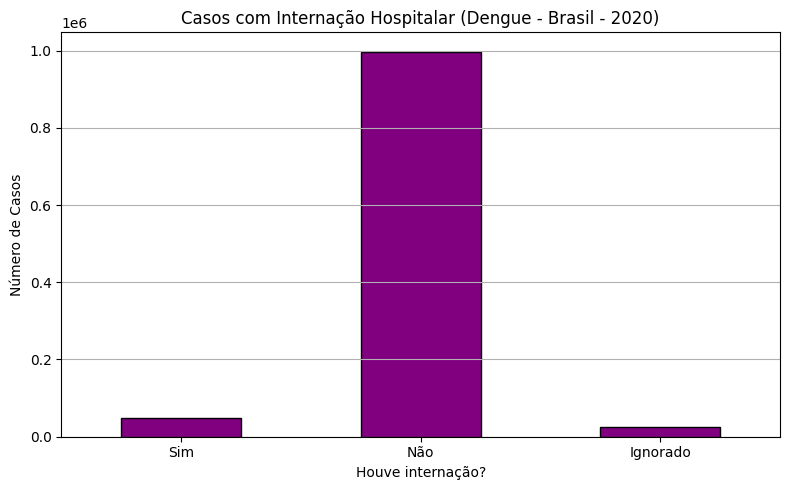

In [32]:
# Mapeamento dos códigos
hosp_labels = {
    1: 'Sim',
    2: 'Não',
    9: 'Ignorado'
}

# Contagem e mapeamento
hosp_freq = df['HOSPITALIZ'].replace('', pd.NA).dropna().astype('Int64').value_counts().sort_index()
hosp_freq.index = hosp_freq.index.map(lambda x: hosp_labels.get(x, f'Cód {x}'))

# Gráfico com rótulos legíveis
plt.figure(figsize=(8,5))
hosp_freq.plot(kind='bar', color='purple', edgecolor='black')
plt.title("Casos com Internação Hospitalar (Dengue - Brasil - 2020)")
plt.xlabel("Houve internação?")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


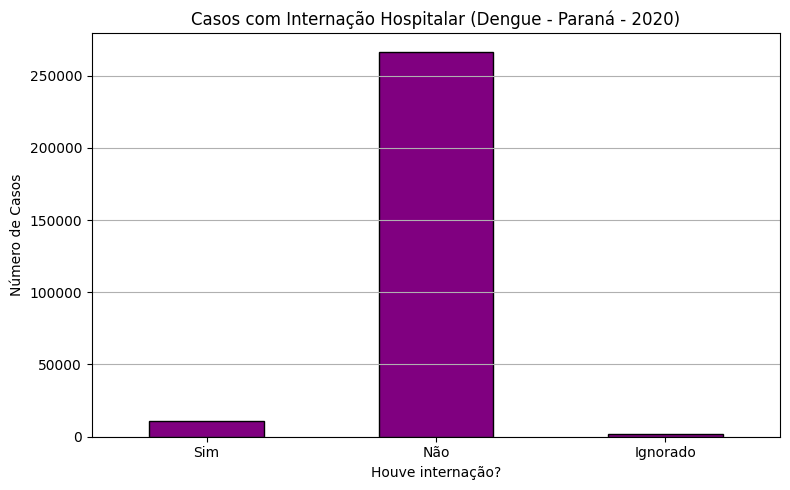

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtrar os dados do Paraná
df_parana = df[df['SG_UF'] == '41'].copy()

# 2. Mapeamento dos códigos de hospitalização
hosp_labels = {
    1: 'Sim',
    2: 'Não',
    9: 'Ignorado'
}

# 3. Contagem com limpeza e mapeamento
hosp_freq = (
    df_parana['HOSPITALIZ']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts()
    .sort_index()
)
hosp_freq.index = hosp_freq.index.map(lambda x: hosp_labels.get(x, f'Cód {x}'))

# 4. Gráfico
plt.figure(figsize=(8,5))
hosp_freq.plot(kind='bar', color='purple', edgecolor='black')
plt.title("Casos com Internação Hospitalar (Dengue - Paraná - 2020)")
plt.xlabel("Houve internação?")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


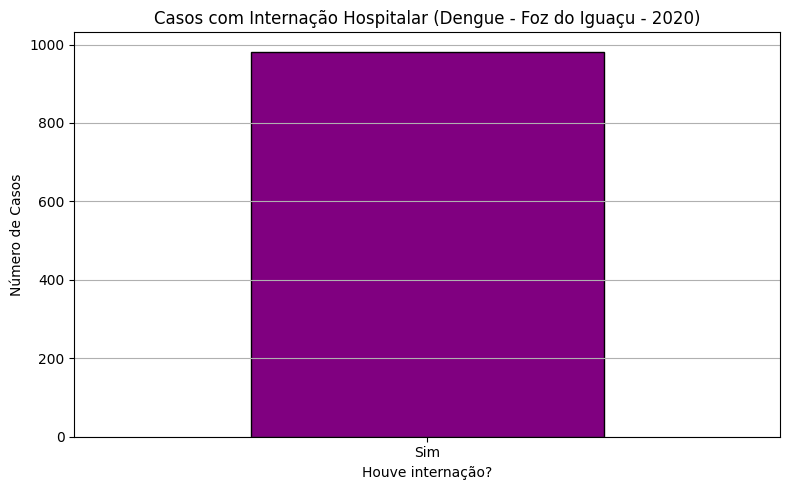

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtrar os dados para Foz do Iguaçu (SG_UF = '41' e MUNICIPIO = '410830')
df_foz = df[
    (df['SG_UF'] == '41') &
    (df['MUNICIPIO'].astype(str).str.zfill(6) == '410830')
].copy()

# 2. Mapeamento dos códigos de hospitalização
hosp_labels = {
    1: 'Sim',
    2: 'Não',
    9: 'Ignorado'
}

# 3. Contagem e mapeamento da variável HOSPITALIZ
hosp_freq = (
    df_foz['HOSPITALIZ']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts()
    .sort_index()
)
hosp_freq.index = hosp_freq.index.map(lambda x: hosp_labels.get(x, f'Cód {x}'))

# 4. Gráfico com rótulos legíveis
plt.figure(figsize=(8,5))
hosp_freq.plot(kind='bar', color='purple', edgecolor='black')
plt.title("Casos com Internação Hospitalar (Dengue - Foz do Iguaçu - 2020)")
plt.xlabel("Houve internação?")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


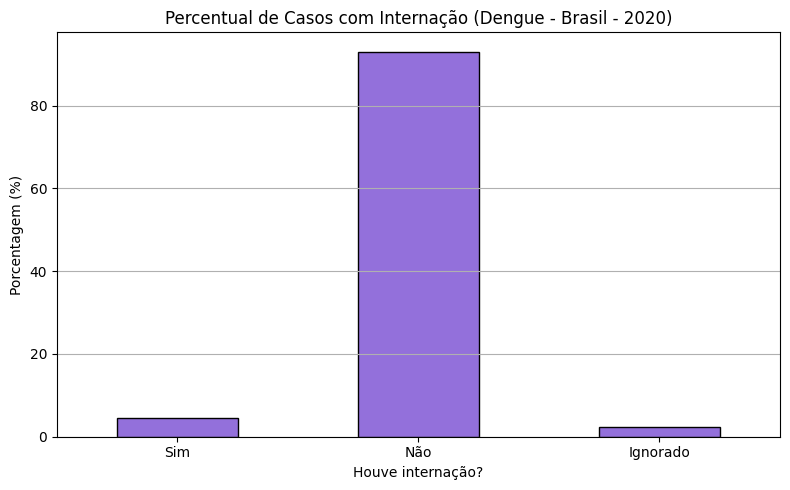

In [ ]:
# Mapeamento de rótulos
hosp_labels = {
    1: 'Sim',
    2: 'Não',
    9: 'Ignorado'
}

# Contagem relativa em percentual
hosp_percent = (
    df['HOSPITALIZ']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts(normalize=True) * 100
).sort_index()

# Aplicar rótulos
hosp_percent.index = hosp_percent.index.map(lambda x: hosp_labels.get(x, f'Cód {x}'))

# Gráfico percentual
plt.figure(figsize=(8,5))
hosp_percent.plot(kind='bar', color='mediumpurple', edgecolor='black')
plt.title("Percentual de Casos com Internação (Dengue - Brasil - 2020)")
plt.xlabel("Houve internação?")
plt.ylabel("Porcentagem (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


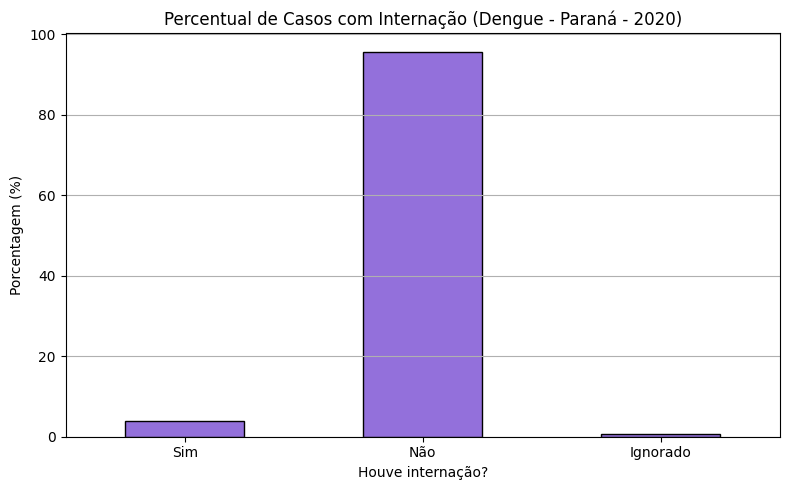

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra os dados para o Estado do Paraná
df_parana = df[df['SG_UF'] == '41'].copy()

# 2. Mapeamento dos rótulos de hospitalização
hosp_labels = {
    1: 'Sim',
    2: 'Não',
    9: 'Ignorado'
}

# 3. Contagem relativa (percentual)
hosp_percent = (
    df_parana['HOSPITALIZ']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts(normalize=True) * 100
).sort_index()

# 4. Aplica rótulos descritivos
hosp_percent.index = hosp_percent.index.map(lambda x: hosp_labels.get(x, f'Cód {x}'))

# 5. Gráfico percentual
plt.figure(figsize=(8,5))
hosp_percent.plot(kind='bar', color='mediumpurple', edgecolor='black')
plt.title("Percentual de Casos com Internação (Dengue - Paraná - 2020)")
plt.xlabel("Houve internação?")
plt.ylabel("Porcentagem (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


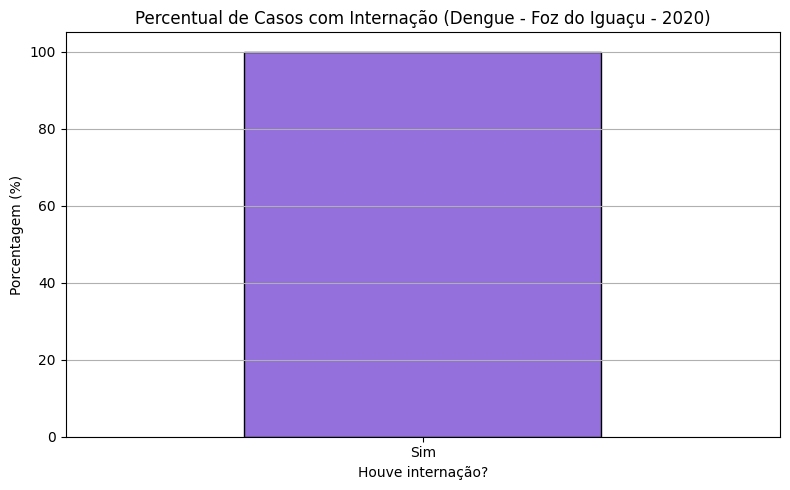

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra os dados para Foz do Iguaçu (SG_UF = '41' e MUNICIPIO = '410830')
df_foz = df[
    (df['SG_UF'] == '41') &
    (df['MUNICIPIO'].astype(str).str.zfill(6) == '410830')
].copy()

# 2. Mapeamento dos rótulos de hospitalização
hosp_labels = {
    1: 'Sim',
    2: 'Não',
    9: 'Ignorado'
}

# 3. Contagem relativa (percentual)
hosp_percent = (
    df_foz['HOSPITALIZ']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts(normalize=True) * 100
).sort_index()

# 4. Aplica rótulos descritivos
hosp_percent.index = hosp_percent.index.map(lambda x: hosp_labels.get(x, f'Cód {x}'))

# 5. Gráfico percentual
plt.figure(figsize=(8,5))
hosp_percent.plot(kind='bar', color='mediumpurple', edgecolor='black')
plt.title("Percentual de Casos com Internação (Dengue - Foz do Iguaçu - 2020)")
plt.xlabel("Houve internação?")
plt.ylabel("Porcentagem (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


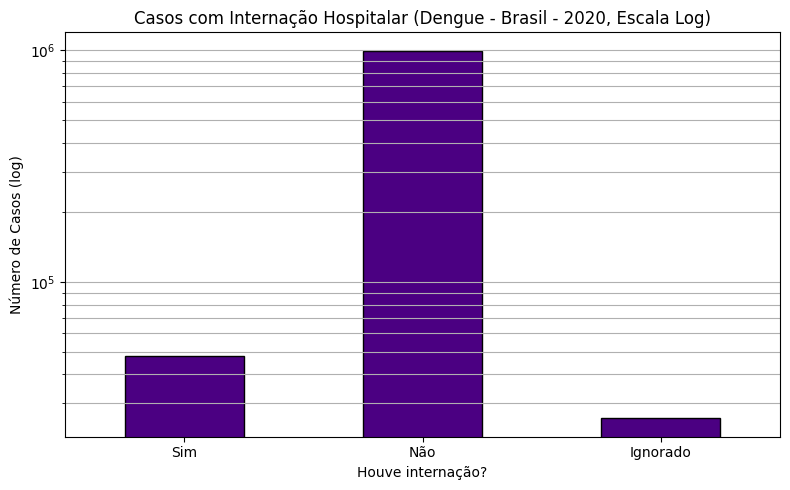

In [ ]:
hosp_freq_log = (
    df['HOSPITALIZ']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts()
    .sort_index()
)

hosp_freq_log.index = hosp_freq_log.index.map(lambda x: hosp_labels.get(x, f'Cód {x}'))

plt.figure(figsize=(8,5))
hosp_freq_log.plot(kind='bar', color='indigo', edgecolor='black')
plt.yscale('log')
plt.title("Casos com Internação Hospitalar (Dengue - Brasil - 2020, Escala Log)")
plt.xlabel("Houve internação?")
plt.ylabel("Número de Casos (log)")
plt.xticks(rotation=0)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.show()


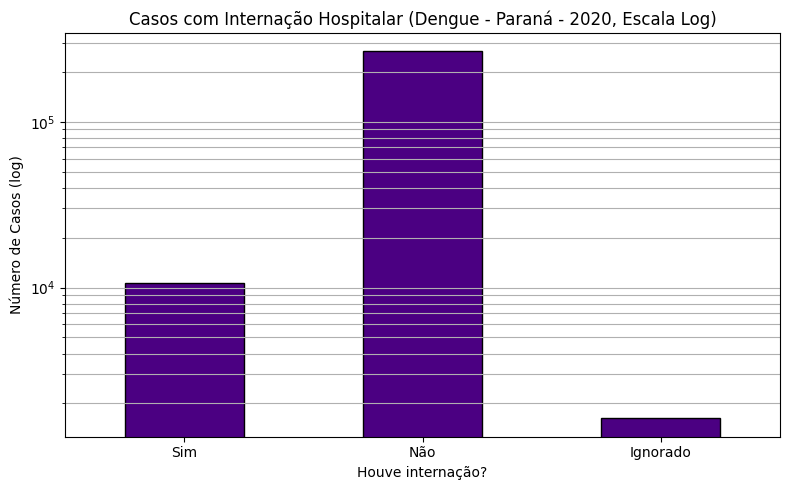

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra os dados para o Estado do Paraná
df_parana = df[df['SG_UF'] == '41'].copy()

# 2. Mapeamento dos rótulos de hospitalização
hosp_labels = {
    1: 'Sim',
    2: 'Não',
    9: 'Ignorado'
}

# 3. Frequência absoluta com tratamento
hosp_freq_log = (
    df_parana['HOSPITALIZ']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts()
    .sort_index()
)

# 4. Aplica rótulos legíveis
hosp_freq_log.index = hosp_freq_log.index.map(lambda x: hosp_labels.get(x, f'Cód {x}'))

# 5. Gráfico com escala logarítmica
plt.figure(figsize=(8,5))
hosp_freq_log.plot(kind='bar', color='indigo', edgecolor='black')
plt.yscale('log')
plt.title("Casos com Internação Hospitalar (Dengue - Paraná - 2020, Escala Log)")
plt.xlabel("Houve internação?")
plt.ylabel("Número de Casos (log)")
plt.xticks(rotation=0)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.show()


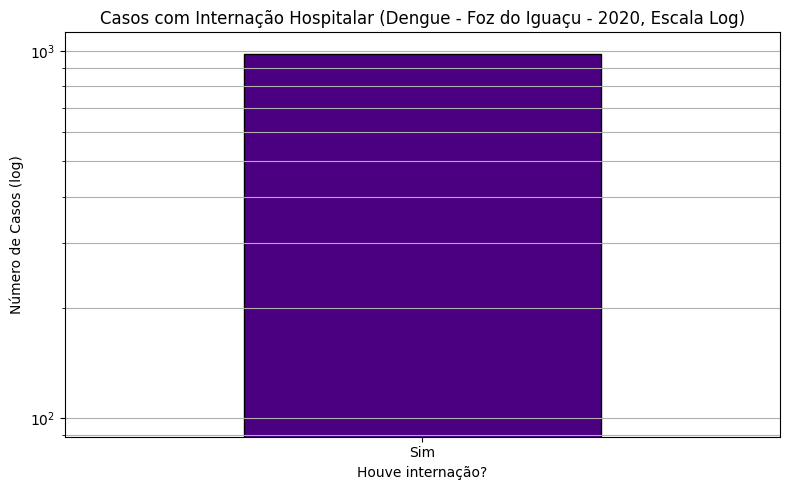

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra os dados para Foz do Iguaçu
df_foz = df[
    (df['SG_UF'] == '41') &
    (df['MUNICIPIO'].astype(str).str.zfill(6) == '410830')
].copy()

# 2. Mapeamento dos rótulos de hospitalização
hosp_labels = {
    1: 'Sim',
    2: 'Não',
    9: 'Ignorado'
}

# 3. Frequência absoluta com tratamento
hosp_freq_log = (
    df_foz['HOSPITALIZ']
    .replace('', pd.NA)
    .dropna()
    .astype('Int64')
    .value_counts()
    .sort_index()
)

# 4. Aplica rótulos legíveis
hosp_freq_log.index = hosp_freq_log.index.map(lambda x: hosp_labels.get(x, f'Cód {x}'))

# 5. Gráfico com escala logarítmica
plt.figure(figsize=(8,5))
hosp_freq_log.plot(kind='bar', color='indigo', edgecolor='black')
plt.yscale('log')
plt.title("Casos com Internação Hospitalar (Dengue - Foz do Iguaçu - 2020, Escala Log)")
plt.xlabel("Houve internação?")
plt.ylabel("Número de Casos (log)")
plt.xticks(rotation=0)
plt.grid(True, which='both', axis='y')
plt.tight_layout()
plt.show()


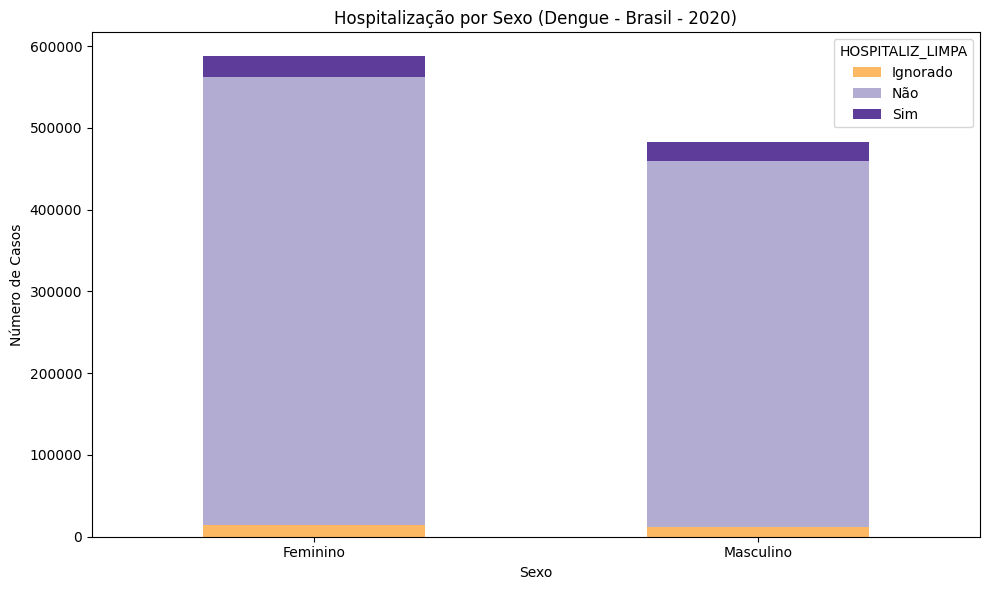

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra apenas registros com sexo conhecido (M ou F)
df_filtrado = df[df['CS_SEXO'].isin(['M', 'F'])].copy()

# 2. Limpa e mapeia as variáveis
df_filtrado['HOSPITALIZ_LIMPA'] = (
    df_filtrado['HOSPITALIZ']
    .replace('', pd.NA)
    .astype('Int64')
    .map({1: 'Sim', 2: 'Não', 9: 'Ignorado'})
)

df_filtrado['CS_SEXO_LIMPO'] = df_filtrado['CS_SEXO'].map({
    'M': 'Masculino',
    'F': 'Feminino'
})

# 3. Gera a tabela cruzada
tabela = pd.crosstab(df_filtrado['CS_SEXO_LIMPO'], df_filtrado['HOSPITALIZ_LIMPA'])

# 4. Gráfico com cores manuais
cores_personalizadas = ['#fdb863', '#b2abd2', '#5e3c99']  # Ignorado, Não, Sim

tabela.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    color=cores_personalizadas
)
plt.title("Hospitalização por Sexo (Dengue - Brasil - 2020)")
plt.xlabel("Sexo")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()




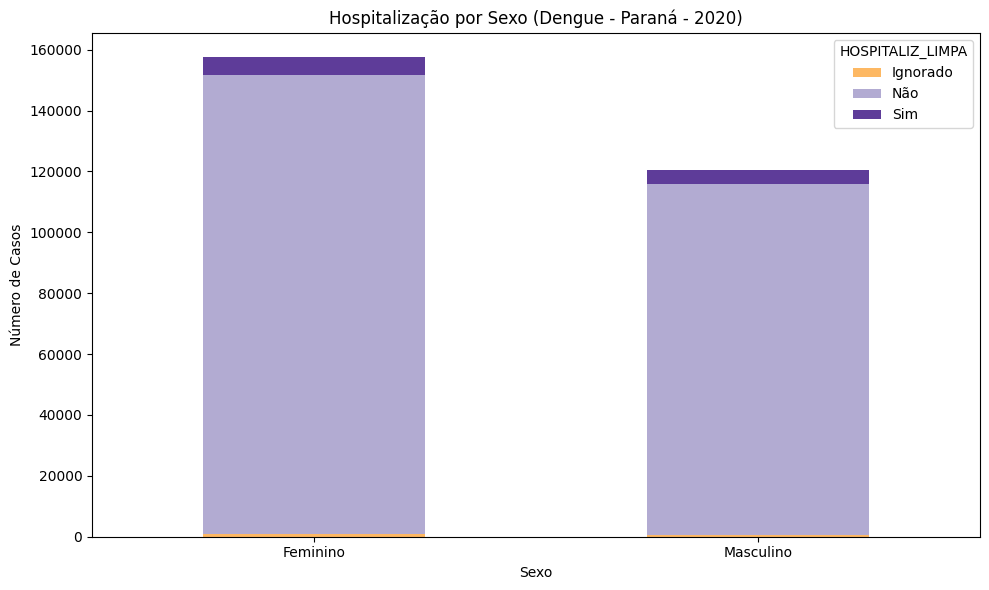

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra dados do Paraná com sexo conhecido
df_parana = df[(df['SG_UF'] == '41') & (df['CS_SEXO'].isin(['M', 'F']))].copy()

# 2. Limpa e mapeia as variáveis
df_parana['HOSPITALIZ_LIMPA'] = (
    df_parana['HOSPITALIZ']
    .replace('', pd.NA)
    .astype('Int64')
    .map({1: 'Sim', 2: 'Não', 9: 'Ignorado'})
)

df_parana['CS_SEXO_LIMPO'] = df_parana['CS_SEXO'].map({
    'M': 'Masculino',
    'F': 'Feminino'
})

# 3. Gera a tabela cruzada
tabela = pd.crosstab(df_parana['CS_SEXO_LIMPO'], df_parana['HOSPITALIZ_LIMPA'])

# 4. Gráfico com cores manuais
cores_personalizadas = ['#fdb863', '#b2abd2', '#5e3c99']  # Ignorado, Não, Sim

tabela.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    color=cores_personalizadas
)
plt.title("Hospitalização por Sexo (Dengue - Paraná - 2020)")
plt.xlabel("Sexo")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



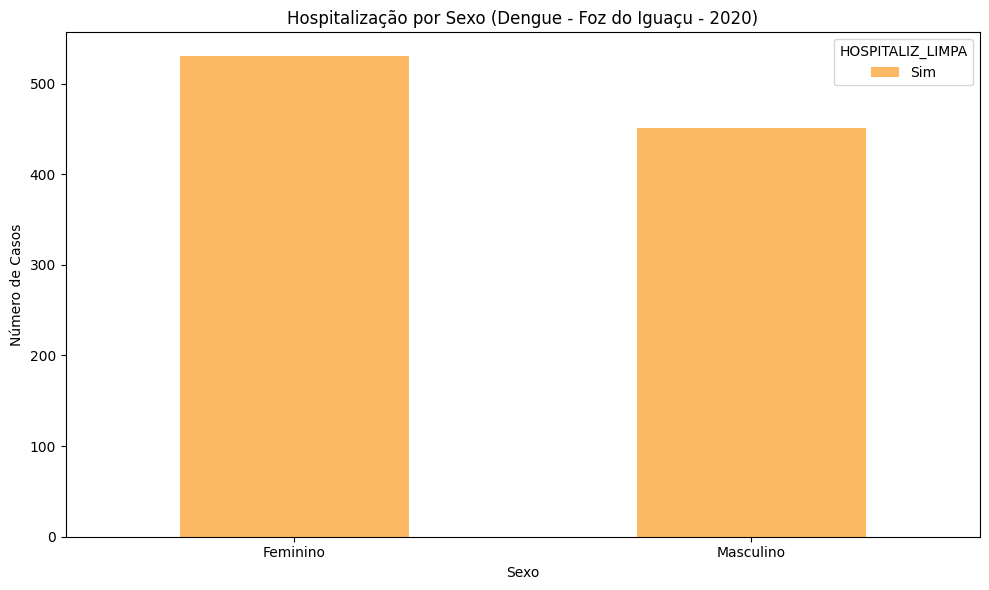

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra dados de Foz do Iguaçu com sexo conhecido
df_foz = df[(df['SG_UF'] == '41') & (df['MUNICIPIO'] == '410830') & (df['CS_SEXO'].isin(['M', 'F']))].copy()

# 2. Limpa e mapeia as variáveis
df_foz['HOSPITALIZ_LIMPA'] = (
    df_foz['HOSPITALIZ']
    .replace('', pd.NA)
    .astype('Int64')
    .map({1: 'Sim', 2: 'Não', 9: 'Ignorado'})
)

df_foz['CS_SEXO_LIMPO'] = df_foz['CS_SEXO'].map({
    'M': 'Masculino',
    'F': 'Feminino'
})

# 3. Gera a tabela cruzada
tabela = pd.crosstab(df_foz['CS_SEXO_LIMPO'], df_foz['HOSPITALIZ_LIMPA'])

# 4. Gráfico com cores manuais
cores_personalizadas = ['#fdb863', '#b2abd2', '#5e3c99']  # Ignorado, Não, Sim

tabela.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    color=cores_personalizadas
)
plt.title("Hospitalização por Sexo (Dengue - Foz do Iguaçu - 2020)")
plt.xlabel("Sexo")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


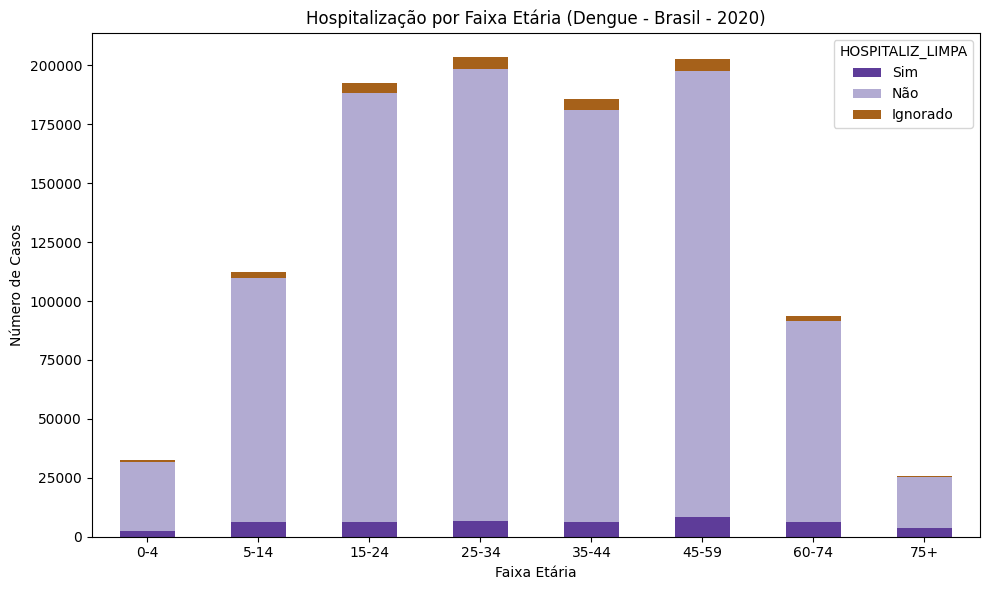

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Converte datas de nascimento e notificação
df['DT_NASC'] = pd.to_datetime(df['DT_NASC'], format='%Y%m%d', errors='coerce')
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce')

# 2. Calcula idade com base em datas (método robusto)
def calcular_idade(row):
    if pd.isna(row['DT_NASC']) or pd.isna(row['DT_NOTIFIC']):
        return np.nan
    idade = row['DT_NOTIFIC'].year - row['DT_NASC'].year
    if (row['DT_NOTIFIC'].month, row['DT_NOTIFIC'].day) < (row['DT_NASC'].month, row['DT_NASC'].day):
        idade -= 1
    return idade

df['IDADE_CALCULADA'] = df.apply(calcular_idade, axis=1)

# 3. Cria faixas etárias a partir da idade calculada
df['faixa_etaria'] = pd.cut(
    df['IDADE_CALCULADA'],
    bins=[0, 4, 14, 24, 34, 44, 59, 74, 120],
    labels=['0-4', '5-14', '15-24', '25-34', '35-44', '45-59', '60-74', '75+']
)

# 4. Cria variável hospitalização legível
df['HOSPITALIZ_LIMPA'] = (
    df['HOSPITALIZ']
    .replace('', pd.NA)
    .astype('Int64')
    .map({1: 'Sim', 2: 'Não', 9: 'Ignorado'})
)

# 5. Tabela cruzada faixa etária × hospitalização
tabela = pd.crosstab(df['faixa_etaria'], df['HOSPITALIZ_LIMPA'])

# 6. Define cores personalizadas
cores_personalizadas = {
    'Sim': '#5e3c99',
    'Não': '#b2abd2',
    'Ignorado': '#a6611a'  # cor mais escura para visibilidade
}

# 7. Reorganiza colunas conforme ordem de cores
tabela = tabela[[col for col in cores_personalizadas if col in tabela.columns]]

# 8. Gráfico empilhado
tabela.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    color=[cores_personalizadas[col] for col in tabela.columns]
)
plt.title("Hospitalização por Faixa Etária (Dengue - Brasil - 2020)")
plt.xlabel("Faixa Etária")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



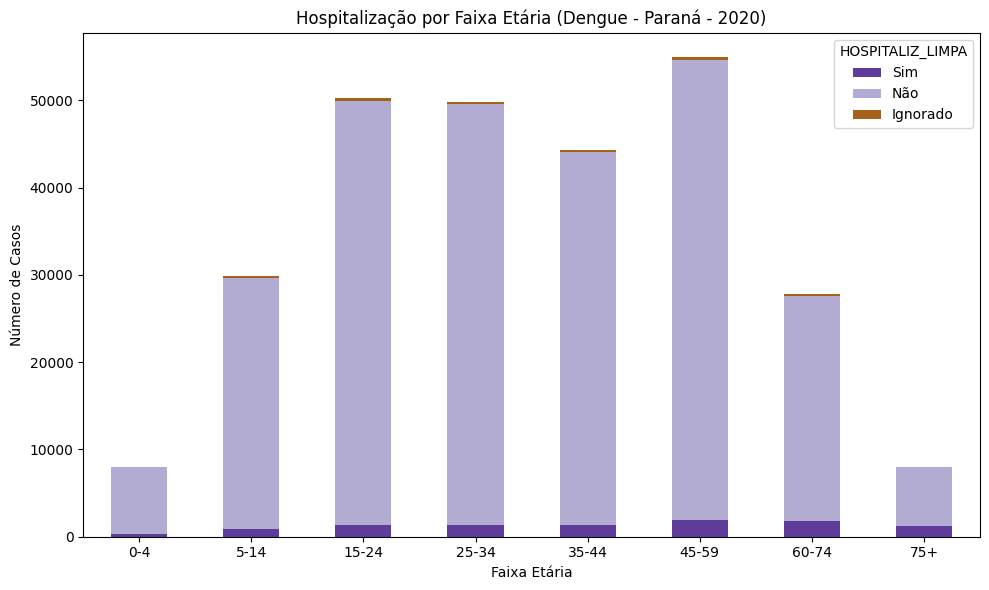

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Filtra dados do Paraná
df_parana = df[df['SG_UF'] == '41'].copy()

# 2. Converte datas de nascimento e notificação
df_parana['DT_NASC'] = pd.to_datetime(df_parana['DT_NASC'], format='%Y%m%d', errors='coerce')
df_parana['DT_NOTIFIC'] = pd.to_datetime(df_parana['DT_NOTIFIC'], errors='coerce')

# 3. Calcula idade de forma robusta
def calcular_idade(row):
    if pd.isna(row['DT_NASC']) or pd.isna(row['DT_NOTIFIC']):
        return np.nan
    idade = row['DT_NOTIFIC'].year - row['DT_NASC'].year
    if (row['DT_NOTIFIC'].month, row['DT_NOTIFIC'].day) < (row['DT_NASC'].month, row['DT_NASC'].day):
        idade -= 1
    return idade

df_parana['IDADE_CALCULADA'] = df_parana.apply(calcular_idade, axis=1)

# 4. Cria faixas etárias
df_parana['faixa_etaria'] = pd.cut(
    df_parana['IDADE_CALCULADA'],
    bins=[0, 4, 14, 24, 34, 44, 59, 74, 120],
    labels=['0-4', '5-14', '15-24', '25-34', '35-44', '45-59', '60-74', '75+']
)

# 5. Cria variável legível para hospitalização
df_parana['HOSPITALIZ_LIMPA'] = (
    df_parana['HOSPITALIZ']
    .replace('', pd.NA)
    .astype('Int64')
    .map({1: 'Sim', 2: 'Não', 9: 'Ignorado'})
)

# 6. Gera a tabela cruzada
tabela = pd.crosstab(df_parana['faixa_etaria'], df_parana['HOSPITALIZ_LIMPA'])

# 7. Cores personalizadas
cores_personalizadas = {
    'Sim': '#5e3c99',
    'Não': '#b2abd2',
    'Ignorado': '#a6611a'
}
tabela = tabela[[col for col in cores_personalizadas if col in tabela.columns]]

# 8. Gráfico empilhado
tabela.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    color=[cores_personalizadas[col] for col in tabela.columns]
)
plt.title("Hospitalização por Faixa Etária (Dengue - Paraná - 2020)")
plt.xlabel("Faixa Etária")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



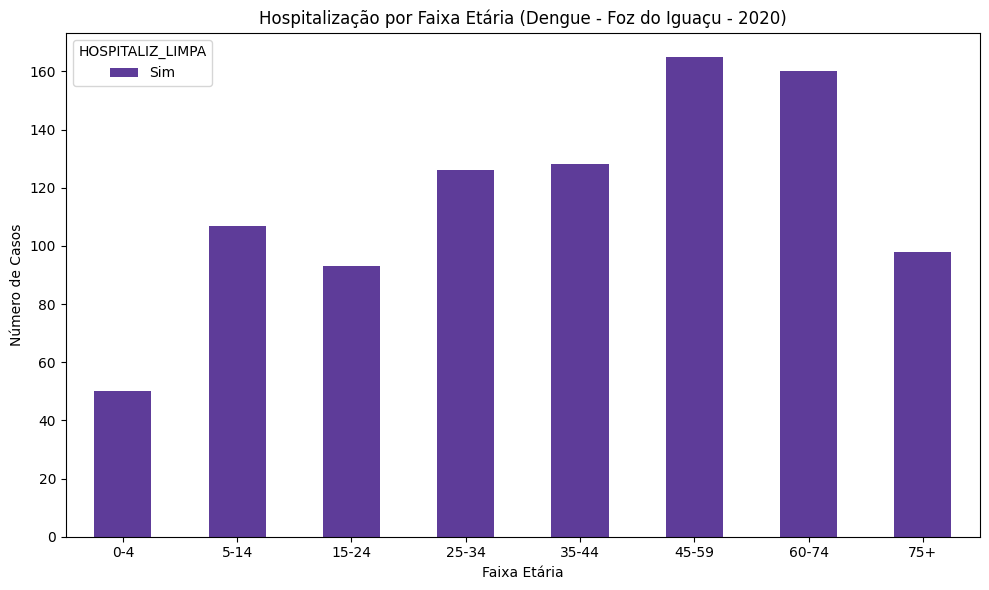

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Filtro para Foz do Iguaçu
df_foz = df[(df['SG_UF'] == '41') & (df['MUNICIPIO'] == '410830')].copy()

# 2. Conversão de datas
df_foz['DT_NASC'] = pd.to_datetime(df_foz['DT_NASC'], format='%Y%m%d', errors='coerce')
df_foz['DT_NOTIFIC'] = pd.to_datetime(df_foz['DT_NOTIFIC'], errors='coerce')

# 3. Cálculo da idade
def calcular_idade(row):
    if pd.isna(row['DT_NASC']) or pd.isna(row['DT_NOTIFIC']):
        return np.nan
    idade = row['DT_NOTIFIC'].year - row['DT_NASC'].year
    if (row['DT_NOTIFIC'].month, row['DT_NOTIFIC'].day) < (row['DT_NASC'].month, row['DT_NASC'].day):
        idade -= 1
    return idade

df_foz['IDADE_CALCULADA'] = df_foz.apply(calcular_idade, axis=1)

# 4. Faixas etárias com base em idade válida
df_foz['faixa_etaria'] = pd.cut(
    df_foz['IDADE_CALCULADA'],
    bins=[0, 4, 14, 24, 34, 44, 59, 74, 120],
    labels=['0-4', '5-14', '15-24', '25-34', '35-44', '45-59', '60-74', '75+']
)

# 5. Hospitalização
df_foz['HOSPITALIZ_LIMPA'] = (
    df_foz['HOSPITALIZ']
    .replace('', pd.NA)
    .astype('Int64')
    .map({1: 'Sim', 2: 'Não', 9: 'Ignorado'})
)

# 6. Tabela cruzada
tabela = pd.crosstab(df_foz['faixa_etaria'], df_foz['HOSPITALIZ_LIMPA'])

# 7. Cores visíveis
cores_personalizadas = {
    'Sim': '#5e3c99',
    'Não': '#b2abd2',
    'Ignorado': '#a6611a'
}
tabela = tabela[[col for col in cores_personalizadas if col in tabela.columns]]

# 8. Gráfico empilhado
tabela.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    color=[cores_personalizadas[col] for col in tabela.columns]
)
plt.title("Hospitalização por Faixa Etária (Dengue - Foz do Iguaçu - 2020)")
plt.xlabel("Faixa Etária")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()




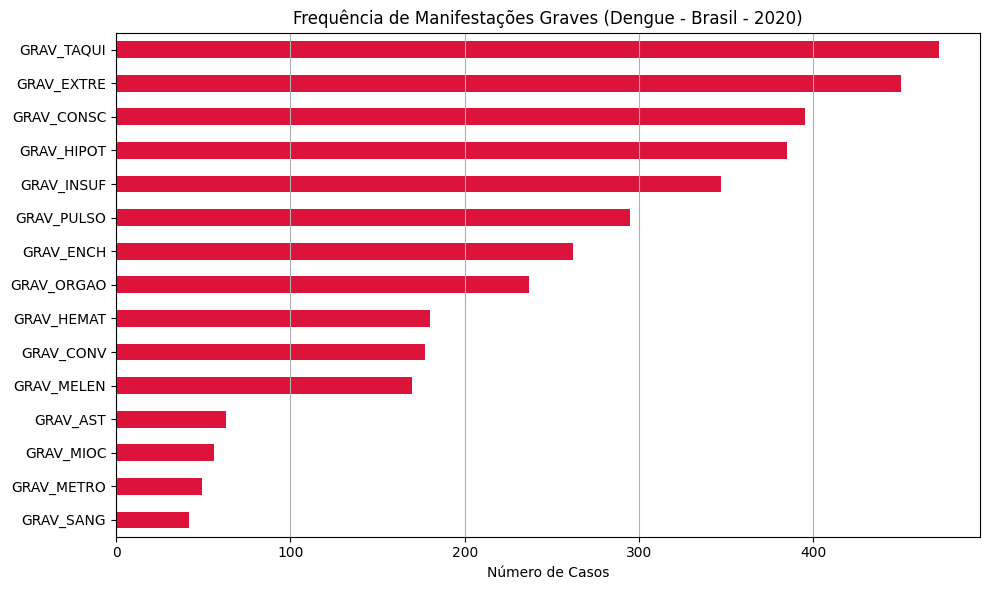

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Identifica as colunas de manifestações graves
graves = [col for col in df.columns if col.startswith("GRAV_")]

# 2. Corrige contagem procurando por string '1'
graves_freq = df[graves].apply(lambda x: x.fillna('').astype(str).str.strip().eq('1').sum()).sort_values()

# 3. Gera gráfico
graves_freq.plot(kind='barh', figsize=(10,6), color='crimson')
plt.title("Frequência de Manifestações Graves (Dengue - Brasil - 2020)")
plt.xlabel("Número de Casos")
plt.grid(axis='x')
plt.tight_layout()
plt.show()



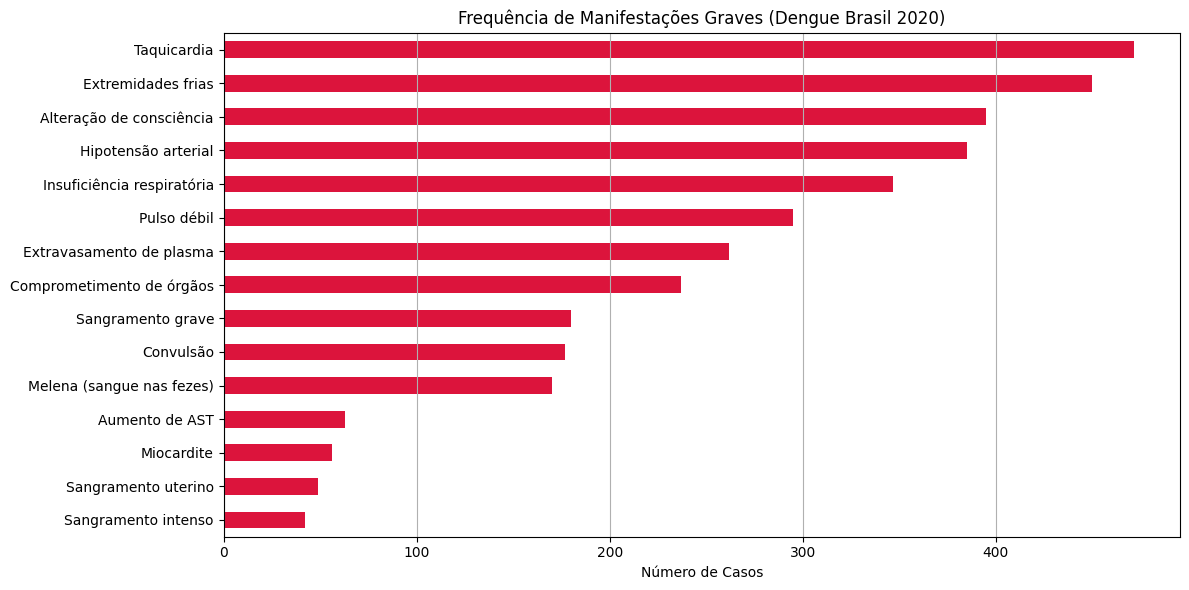

In [38]:
labels_legiveis = {
    'GRAV_PULSO': 'Pulso débil',
    'GRAV_CONV': 'Convulsão',
    'GRAV_ENCH': 'Extravasamento de plasma',
    'GRAV_INSUF': 'Insuficiência respiratória',
    'GRAV_TAQUI': 'Taquicardia',
    'GRAV_EXTRE': 'Extremidades frias',
    'GRAV_HIPOT': 'Hipotensão arterial',
    'GRAV_HEMAT': 'Sangramento grave',
    'GRAV_MELEN': 'Melena (sangue nas fezes)',
    'GRAV_METRO': 'Sangramento uterino',
    'GRAV_SANG': 'Sangramento intenso',
    'GRAV_AST': 'Aumento de AST',
    'GRAV_MIOC': 'Miocardite',
    'GRAV_CONSC': 'Alteração de consciência',
    'GRAV_ORGAO': 'Comprometimento de órgãos'
}
# Aplicar o dicionário para trocar os nomes
graves_freq_legenda = graves_freq.copy()
graves_freq_legenda.index = graves_freq_legenda.index.map(lambda x: labels_legiveis.get(x, x))

# Novo gráfico com rótulos legíveis
graves_freq_legenda.plot(kind='barh', figsize=(12,6), color='crimson')
plt.title("Frequência de Manifestações Graves (Dengue Brasil 2020)")
plt.xlabel("Número de Casos")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

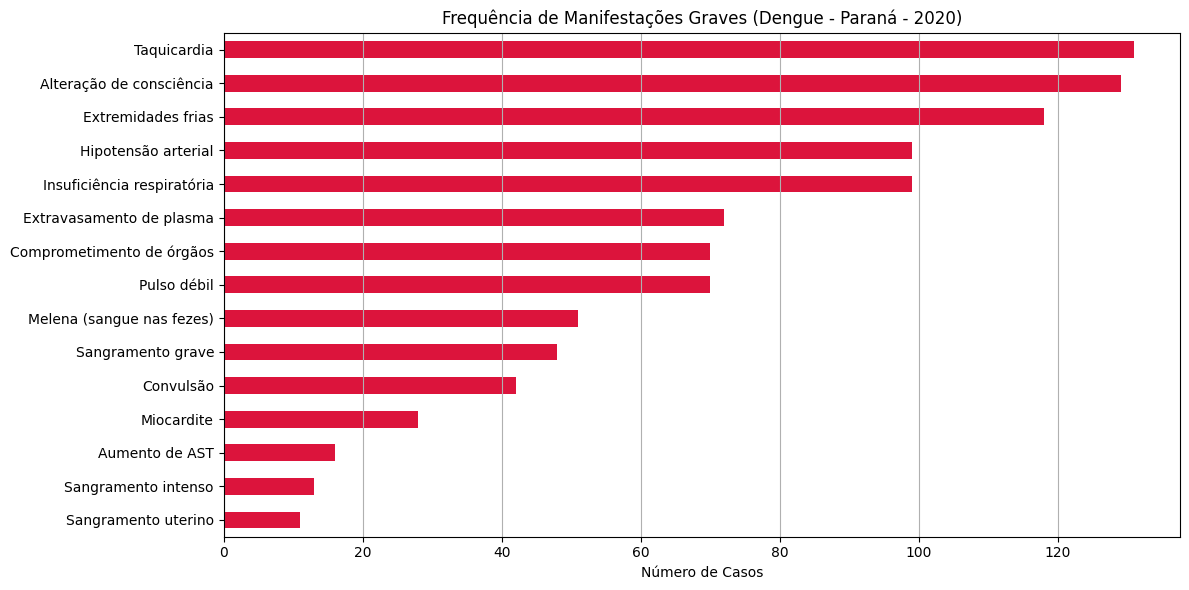

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra dados do Paraná
df_parana = df[df['SG_UF'] == '41'].copy()

# 2. Identifica colunas de manifestações graves
graves = [col for col in df_parana.columns if col.startswith("GRAV_")]

# 3. Conta presença de manifestações graves (valor '1')
graves_freq = df_parana[graves].apply(
    lambda x: x.fillna('').astype(str).str.strip().eq('1').sum()
).sort_values()

# 4. Dicionário de rótulos legíveis
labels_legiveis = {
    'GRAV_PULSO': 'Pulso débil',
    'GRAV_CONV': 'Convulsão',
    'GRAV_ENCH': 'Extravasamento de plasma',
    'GRAV_INSUF': 'Insuficiência respiratória',
    'GRAV_TAQUI': 'Taquicardia',
    'GRAV_EXTRE': 'Extremidades frias',
    'GRAV_HIPOT': 'Hipotensão arterial',
    'GRAV_HEMAT': 'Sangramento grave',
    'GRAV_MELEN': 'Melena (sangue nas fezes)',
    'GRAV_METRO': 'Sangramento uterino',
    'GRAV_SANG': 'Sangramento intenso',
    'GRAV_AST': 'Aumento de AST',
    'GRAV_MIOC': 'Miocardite',
    'GRAV_CONSC': 'Alteração de consciência',
    'GRAV_ORGAO': 'Comprometimento de órgãos'
}

# 5. Aplica legenda nos índices
graves_freq_legenda = graves_freq.copy()
graves_freq_legenda.index = graves_freq_legenda.index.map(lambda x: labels_legiveis.get(x, x))

# 6. Gera o gráfico
graves_freq_legenda.plot(kind='barh', figsize=(12,6), color='crimson')
plt.title("Frequência de Manifestações Graves (Dengue - Paraná - 2020)")
plt.xlabel("Número de Casos")
plt.tight_layout()
plt.grid(axis='x')
plt.show()


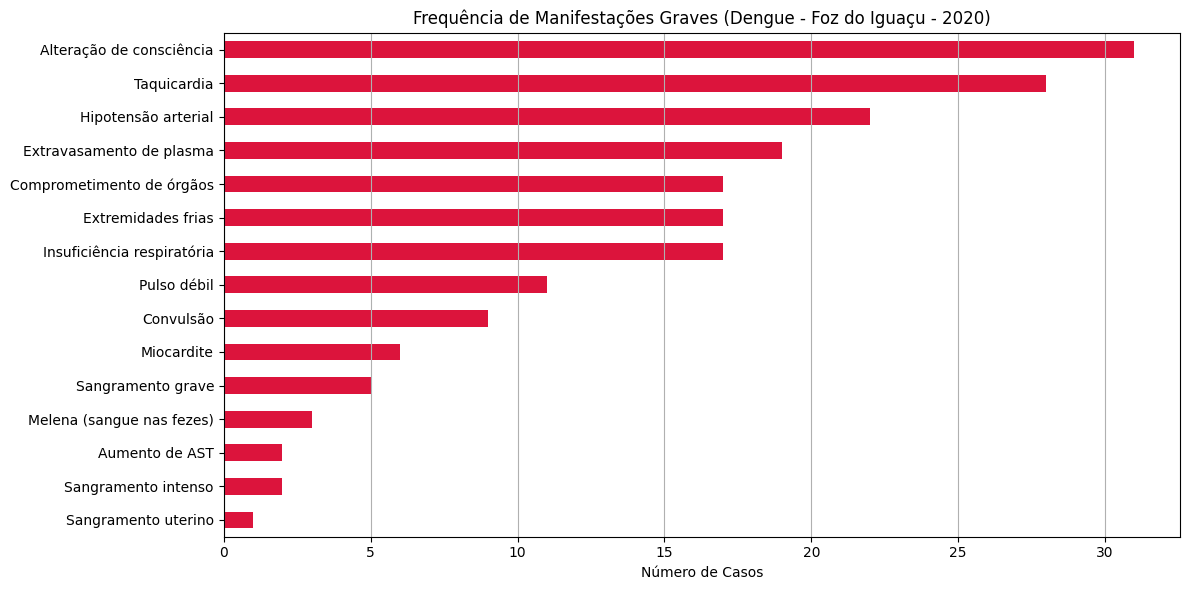

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra dados de Foz do Iguaçu
df_foz = df[
    (df['SG_UF'] == '41') &
    (df['MUNICIPIO'].astype(str).str.zfill(6) == '410830')
].copy()

# 2. Identifica colunas de manifestações graves
graves = [col for col in df_foz.columns if col.startswith("GRAV_")]

# 3. Conta presença de manifestações graves (valor '1')
graves_freq = df_foz[graves].apply(
    lambda x: x.fillna('').astype(str).str.strip().eq('1').sum()
).sort_values()

# 4. Dicionário de rótulos legíveis
labels_legiveis = {
    'GRAV_PULSO': 'Pulso débil',
    'GRAV_CONV': 'Convulsão',
    'GRAV_ENCH': 'Extravasamento de plasma',
    'GRAV_INSUF': 'Insuficiência respiratória',
    'GRAV_TAQUI': 'Taquicardia',
    'GRAV_EXTRE': 'Extremidades frias',
    'GRAV_HIPOT': 'Hipotensão arterial',
    'GRAV_HEMAT': 'Sangramento grave',
    'GRAV_MELEN': 'Melena (sangue nas fezes)',
    'GRAV_METRO': 'Sangramento uterino',
    'GRAV_SANG': 'Sangramento intenso',
    'GRAV_AST': 'Aumento de AST',
    'GRAV_MIOC': 'Miocardite',
    'GRAV_CONSC': 'Alteração de consciência',
    'GRAV_ORGAO': 'Comprometimento de órgãos'
}

# 5. Aplica legenda nos índices
graves_freq_legenda = graves_freq.copy()
graves_freq_legenda.index = graves_freq_legenda.index.map(lambda x: labels_legiveis.get(x, x))

# 6. Gera o gráfico
graves_freq_legenda.plot(kind='barh', figsize=(12,6), color='crimson')
plt.title("Frequência de Manifestações Graves (Dengue - Foz do Iguaçu - 2020)")
plt.xlabel("Número de Casos")
plt.tight_layout()
plt.grid(axis='x')
plt.show()


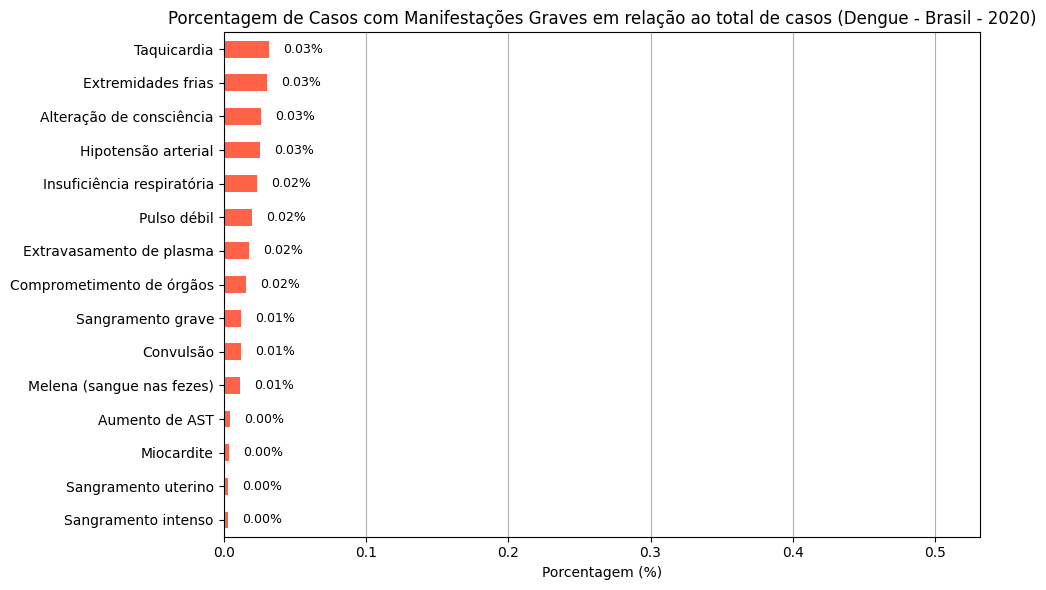

In [52]:
# Frequência percentual de manifestações graves
graves_percent = df[graves].apply(lambda x: x.fillna('').eq('1').mean() * 100).sort_values()
graves_percent.index = graves_percent.index.map(lambda x: labels_legiveis.get(x, x))

# Cria gráfico horizontal
fig, ax = plt.subplots(figsize=(10, 6))
bars = graves_percent.plot(kind='barh', color='tomato', ax=ax)

plt.title("Porcentagem de Casos com Manifestações Graves em relação ao total de casos (Dengue - Brasil - 2020)")
plt.xlabel("Porcentagem (%)")
plt.grid(axis='x')

# Corrige eixo X com margem razoável (adiciona 0.5 ponto percentual de folga)
max_val = graves_percent.max()
plt.xlim(0, max_val + 0.5)

# Anota os valores ao lado das barras
for i, v in enumerate(graves_percent):
    ax.text(v + 0.01, i, f"{v:.2f}%", va='center', fontsize=9)

plt.tight_layout()
plt.show()




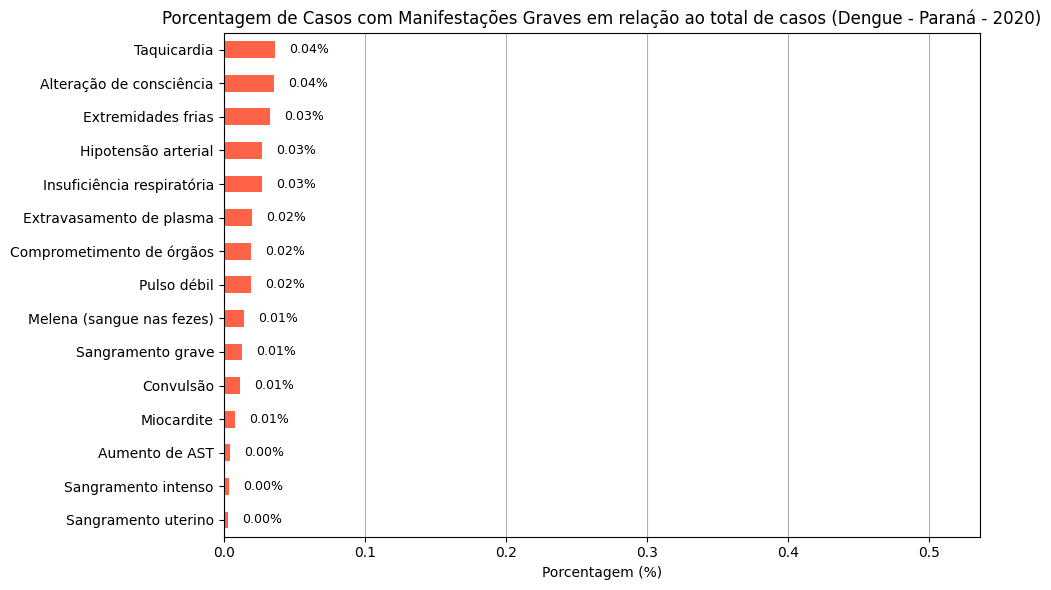

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtra os dados para o estado do Paraná (SG_UF = '41')
df_parana = df[df['SG_UF'] == '41'].copy()

# Seleciona colunas de manifestações graves
graves = [col for col in df_parana.columns if col.startswith("GRAV_")]

# Dicionário de rótulos legíveis
labels_legiveis = {
    'GRAV_PULSO': 'Pulso débil',
    'GRAV_CONV': 'Convulsão',
    'GRAV_ENCH': 'Extravasamento de plasma',
    'GRAV_INSUF': 'Insuficiência respiratória',
    'GRAV_TAQUI': 'Taquicardia',
    'GRAV_EXTRE': 'Extremidades frias',
    'GRAV_HIPOT': 'Hipotensão arterial',
    'GRAV_HEMAT': 'Sangramento grave',
    'GRAV_MELEN': 'Melena (sangue nas fezes)',
    'GRAV_METRO': 'Sangramento uterino',
    'GRAV_SANG': 'Sangramento intenso',
    'GRAV_AST': 'Aumento de AST',
    'GRAV_MIOC': 'Miocardite',
    'GRAV_CONSC': 'Alteração de consciência',
    'GRAV_ORGAO': 'Comprometimento de órgãos'
}

# Frequência percentual em relação ao total de casos no Paraná
graves_percent = df_parana[graves].apply(lambda x: x.fillna('').eq('1').mean() * 100).sort_values()
graves_percent.index = graves_percent.index.map(lambda x: labels_legiveis.get(x, x))

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
graves_percent.plot(kind='barh', color='tomato', ax=ax)

plt.title("Porcentagem de Casos com Manifestações Graves em relação ao total de casos (Dengue - Paraná - 2020)")
plt.xlabel("Porcentagem (%)")
plt.grid(axis='x')

# Margem de 0.5 para o valor máximo
max_val = graves_percent.max()
plt.xlim(0, max_val + 0.5)

# Rótulos ao lado das barras
for i, v in enumerate(graves_percent):
    ax.text(v + 0.01, i, f"{v:.2f}%", va='center', fontsize=9)

plt.tight_layout()
plt.show()


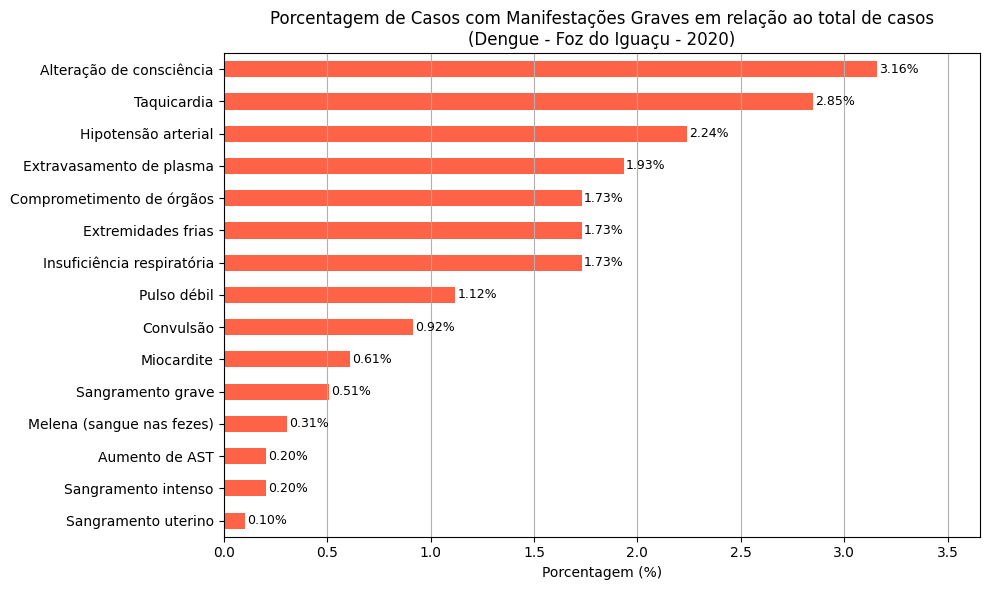

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra os dados para Foz do Iguaçu (SG_UF = '41' e código do município = 410830)
df_foz = df[
    (df['SG_UF'] == '41') &
    (df['MUNICIPIO'].astype(str).str.zfill(6) == '410830')
].copy()

# 2. Seleciona colunas de manifestações graves
graves = [col for col in df_foz.columns if col.startswith("GRAV_")]

# 3. Dicionário de rótulos legíveis
labels_legiveis = {
    'GRAV_PULSO': 'Pulso débil',
    'GRAV_CONV': 'Convulsão',
    'GRAV_ENCH': 'Extravasamento de plasma',
    'GRAV_INSUF': 'Insuficiência respiratória',
    'GRAV_TAQUI': 'Taquicardia',
    'GRAV_EXTRE': 'Extremidades frias',
    'GRAV_HIPOT': 'Hipotensão arterial',
    'GRAV_HEMAT': 'Sangramento grave',
    'GRAV_MELEN': 'Melena (sangue nas fezes)',
    'GRAV_METRO': 'Sangramento uterino',
    'GRAV_SANG': 'Sangramento intenso',
    'GRAV_AST': 'Aumento de AST',
    'GRAV_MIOC': 'Miocardite',
    'GRAV_CONSC': 'Alteração de consciência',
    'GRAV_ORGAO': 'Comprometimento de órgãos'
}

# 4. Frequência percentual por manifestação grave
graves_percent = df_foz[graves].apply(lambda x: x.fillna('').eq('1').mean() * 100).sort_values()
graves_percent.index = graves_percent.index.map(lambda x: labels_legiveis.get(x, x))

# 5. Gráfico com percentuais visíveis
fig, ax = plt.subplots(figsize=(10, 6))
bars = graves_percent.plot(kind='barh', color='tomato', ax=ax)

plt.title("Porcentagem de Casos com Manifestações Graves em relação ao total de casos\n(Dengue - Foz do Iguaçu - 2020)")
plt.xlabel("Porcentagem (%)")
plt.grid(axis='x')

# Margem extra no eixo x
max_val = graves_percent.max()
plt.xlim(0, max_val + 0.5)

# Percentuais ao lado das barras
for i, v in enumerate(graves_percent):
    ax.text(v + 0.01, i, f"{v:.2f}%", va='center', fontsize=9)

plt.tight_layout()
plt.show()


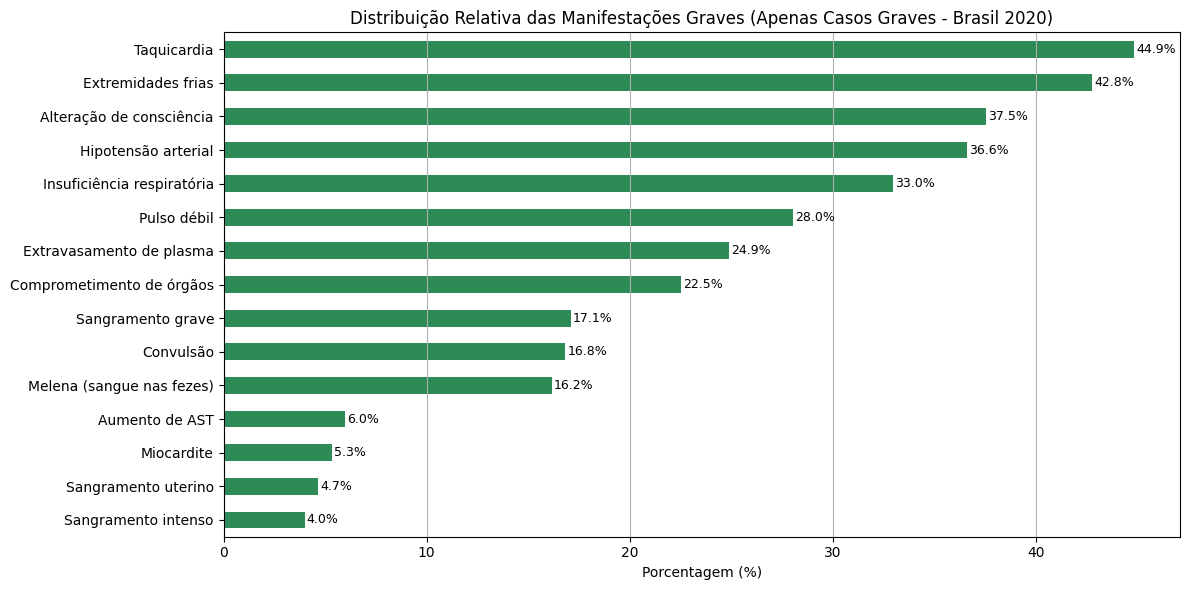

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Seleciona colunas de manifestações graves
graves = [col for col in df.columns if col.startswith("GRAV_")]

# 2. Filtra registros com pelo menos uma manifestação grave
casos_graves = df[graves].fillna('').astype(str).apply(lambda x: x.eq('1')).any(axis=1)
df_graves = df[casos_graves].copy()

# 3. Calcula percentual relativo
graves_percent_relativo = df_graves[graves].apply(
    lambda x: x.fillna('').astype(str).str.strip().eq('1').mean() * 100
).sort_values()

# 4. Rótulos legíveis
labels_legiveis = {
    'GRAV_PULSO': 'Pulso débil',
    'GRAV_CONV': 'Convulsão',
    'GRAV_ENCH': 'Extravasamento de plasma',
    'GRAV_INSUF': 'Insuficiência respiratória',
    'GRAV_TAQUI': 'Taquicardia',
    'GRAV_EXTRE': 'Extremidades frias',
    'GRAV_HIPOT': 'Hipotensão arterial',
    'GRAV_HEMAT': 'Sangramento grave',
    'GRAV_MELEN': 'Melena (sangue nas fezes)',
    'GRAV_METRO': 'Sangramento uterino',
    'GRAV_SANG': 'Sangramento intenso',
    'GRAV_AST': 'Aumento de AST',
    'GRAV_MIOC': 'Miocardite',
    'GRAV_CONSC': 'Alteração de consciência',
    'GRAV_ORGAO': 'Comprometimento de órgãos'
}
graves_percent_relativo.index = graves_percent_relativo.index.map(lambda x: labels_legiveis.get(x, x))

# 5. Gráfico com percentuais ao lado
ax = graves_percent_relativo.plot(kind='barh', figsize=(12,6), color='seagreen')
plt.title("Distribuição Relativa das Manifestações Graves (Apenas Casos Graves - Brasil 2020)")
plt.xlabel("Porcentagem (%)")
plt.grid(axis='x')
plt.tight_layout()

# 6. Adiciona os valores ao lado das barras
for i, v in enumerate(graves_percent_relativo):
    plt.text(v + 0.1, i, f"{v:.1f}%", va='center', fontsize=9)

plt.show()



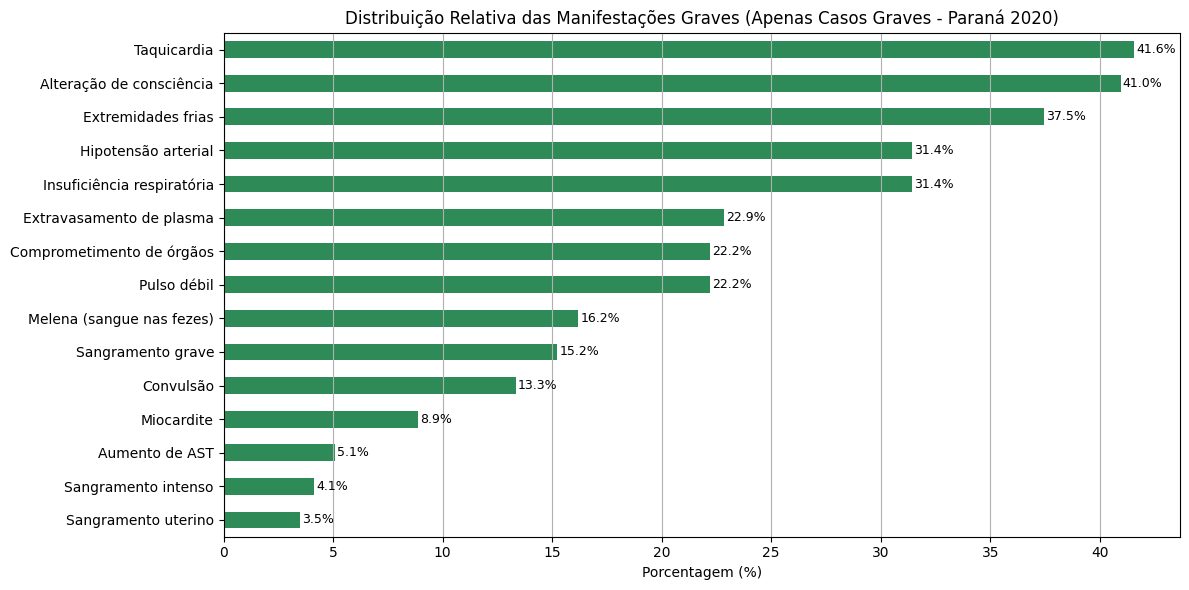

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra o DataFrame original para o Paraná (SG_UF = '41')
df_pr = df[df['SG_UF'] == '41'].copy()

# 2. Seleciona colunas de manifestações graves
graves = [col for col in df_pr.columns if col.startswith("GRAV_")]

# 3. Filtra apenas registros com pelo menos uma manifestação grave
casos_graves = df_pr[graves].fillna('').astype(str).apply(lambda x: x.eq('1')).any(axis=1)
df_graves_pr = df_pr[casos_graves].copy()

# 4. Calcula o percentual relativo por tipo de manifestação grave (dentro dos casos graves)
graves_percent_relativo = df_graves_pr[graves].apply(
    lambda x: x.fillna('').astype(str).str.strip().eq('1').mean() * 100
).sort_values()

# 5. Rótulos legíveis para cada coluna
labels_legiveis = {
    'GRAV_PULSO': 'Pulso débil',
    'GRAV_CONV': 'Convulsão',
    'GRAV_ENCH': 'Extravasamento de plasma',
    'GRAV_INSUF': 'Insuficiência respiratória',
    'GRAV_TAQUI': 'Taquicardia',
    'GRAV_EXTRE': 'Extremidades frias',
    'GRAV_HIPOT': 'Hipotensão arterial',
    'GRAV_HEMAT': 'Sangramento grave',
    'GRAV_MELEN': 'Melena (sangue nas fezes)',
    'GRAV_METRO': 'Sangramento uterino',
    'GRAV_SANG': 'Sangramento intenso',
    'GRAV_AST': 'Aumento de AST',
    'GRAV_MIOC': 'Miocardite',
    'GRAV_CONSC': 'Alteração de consciência',
    'GRAV_ORGAO': 'Comprometimento de órgãos'
}
graves_percent_relativo.index = graves_percent_relativo.index.map(lambda x: labels_legiveis.get(x, x))

# 6. Gráfico com rótulos percentuais ao lado das barras
ax = graves_percent_relativo.plot(kind='barh', figsize=(12,6), color='seagreen')
plt.title("Distribuição Relativa das Manifestações Graves (Apenas Casos Graves - Paraná 2020)")
plt.xlabel("Porcentagem (%)")
plt.grid(axis='x')
plt.tight_layout()

# 7. Adiciona rótulos de valores
for i, v in enumerate(graves_percent_relativo):
    plt.text(v + 0.1, i, f"{v:.1f}%", va='center', fontsize=9)

plt.show()


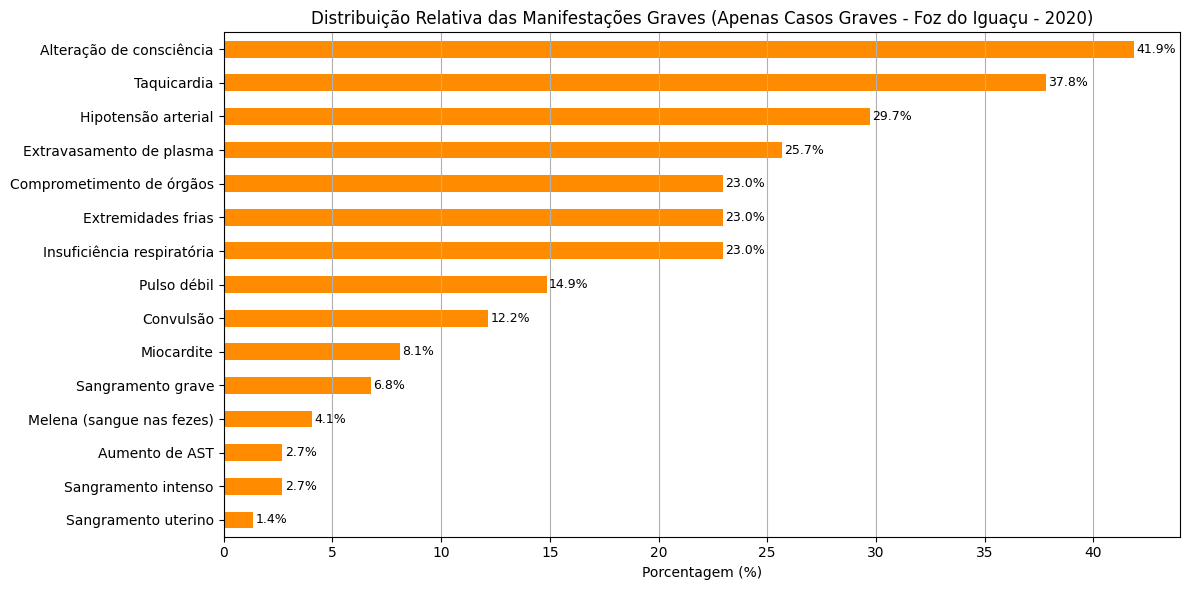

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra os dados para Foz do Iguaçu
df_foz = df[
    (df['SG_UF'] == '41') &
    (df['MUNICIPIO'].astype(str).str.zfill(6) == '410830')
].copy()

# 2. Seleciona colunas de manifestações graves
graves = [col for col in df_foz.columns if col.startswith("GRAV_")]

# 3. Filtra registros com pelo menos uma manifestação grave
casos_graves_foz = df_foz[graves].fillna('').astype(str).apply(lambda x: x.eq('1')).any(axis=1)
df_graves_foz = df_foz[casos_graves_foz].copy()

# 4. Calcula o percentual relativo dentro dos casos graves
graves_percent_relativo = df_graves_foz[graves].apply(
    lambda x: x.fillna('').astype(str).str.strip().eq('1').mean() * 100
).sort_values()

# 5. Rótulos legíveis
labels_legiveis = {
    'GRAV_PULSO': 'Pulso débil',
    'GRAV_CONV': 'Convulsão',
    'GRAV_ENCH': 'Extravasamento de plasma',
    'GRAV_INSUF': 'Insuficiência respiratória',
    'GRAV_TAQUI': 'Taquicardia',
    'GRAV_EXTRE': 'Extremidades frias',
    'GRAV_HIPOT': 'Hipotensão arterial',
    'GRAV_HEMAT': 'Sangramento grave',
    'GRAV_MELEN': 'Melena (sangue nas fezes)',
    'GRAV_METRO': 'Sangramento uterino',
    'GRAV_SANG': 'Sangramento intenso',
    'GRAV_AST': 'Aumento de AST',
    'GRAV_MIOC': 'Miocardite',
    'GRAV_CONSC': 'Alteração de consciência',
    'GRAV_ORGAO': 'Comprometimento de órgãos'
}
graves_percent_relativo.index = graves_percent_relativo.index.map(lambda x: labels_legiveis.get(x, x))

# 6. Gráfico com percentuais ao lado
ax = graves_percent_relativo.plot(kind='barh', figsize=(12,6), color='darkorange')
plt.title("Distribuição Relativa das Manifestações Graves (Apenas Casos Graves - Foz do Iguaçu - 2020)")
plt.xlabel("Porcentagem (%)")
plt.grid(axis='x')
plt.tight_layout()

# 7. Adiciona rótulos com valores
for i, v in enumerate(graves_percent_relativo):
    plt.text(v + 0.1, i, f"{v:.1f}%", va='center', fontsize=9)

plt.show()


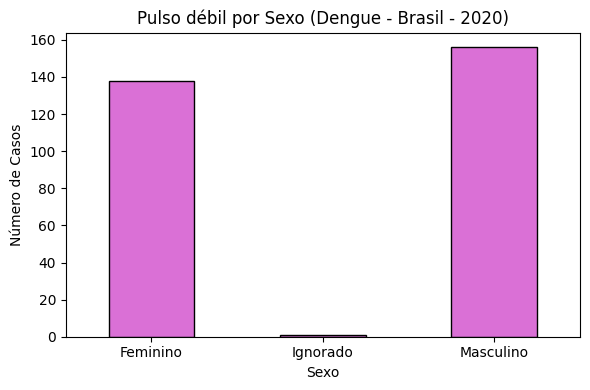

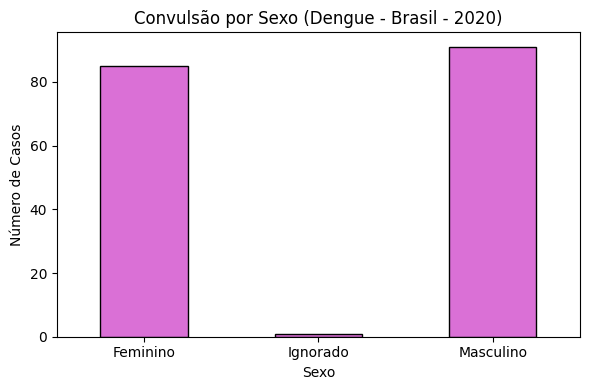

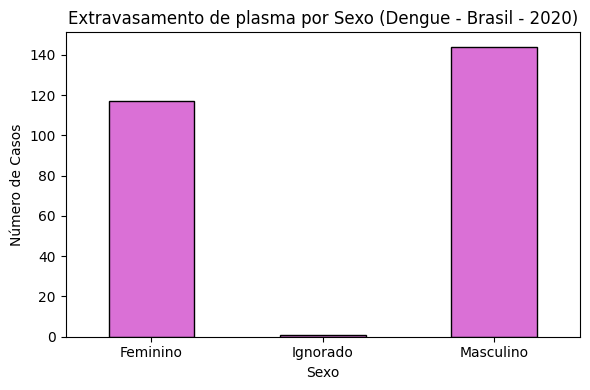

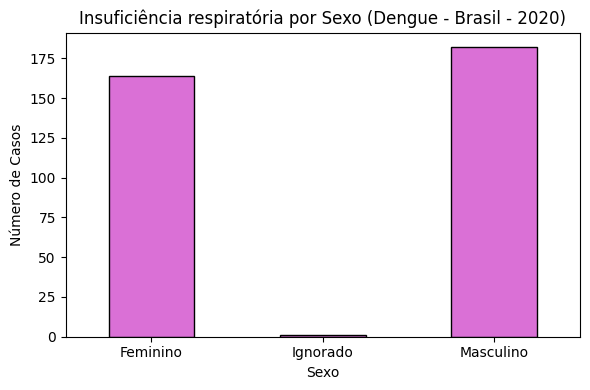

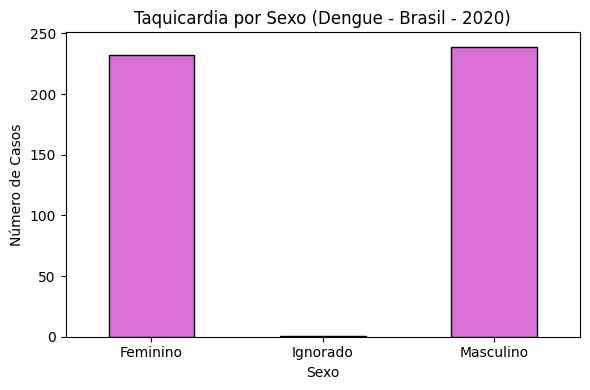

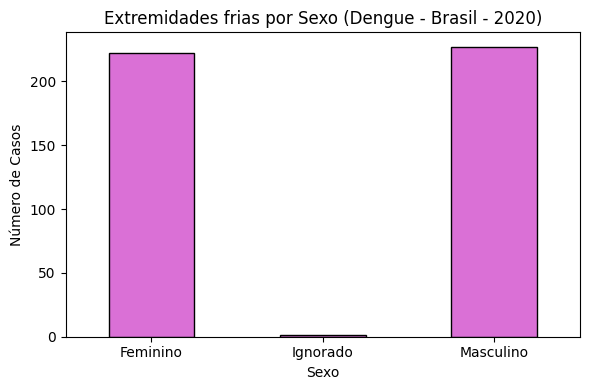

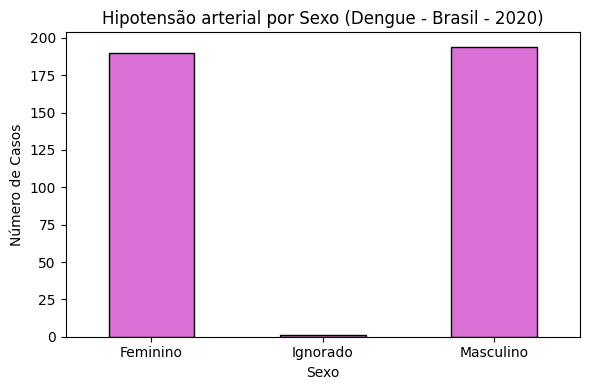

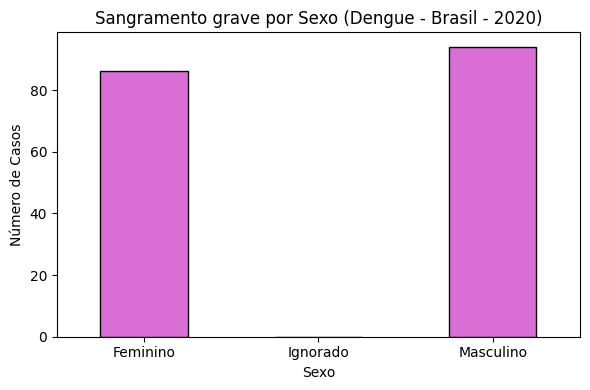

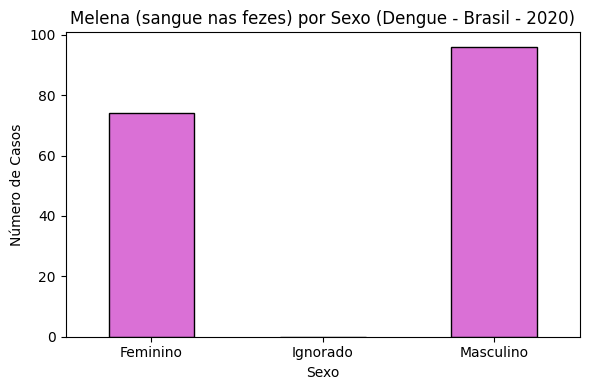

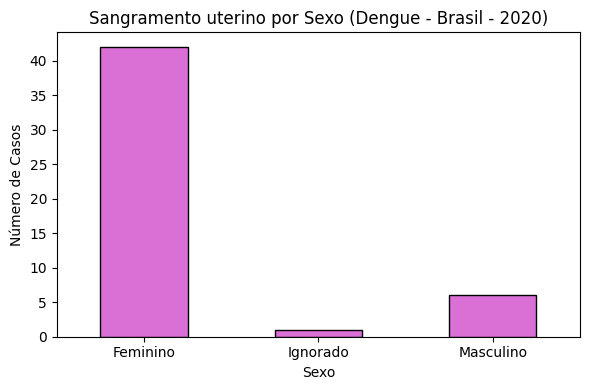

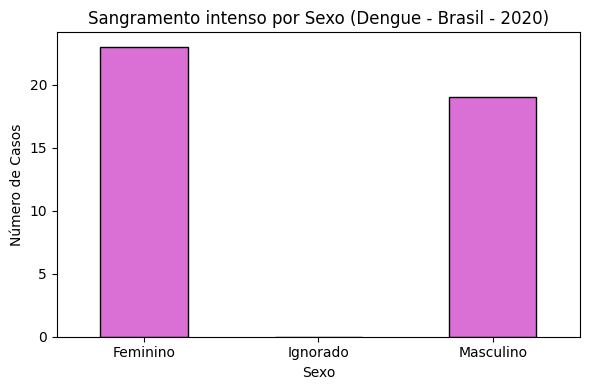

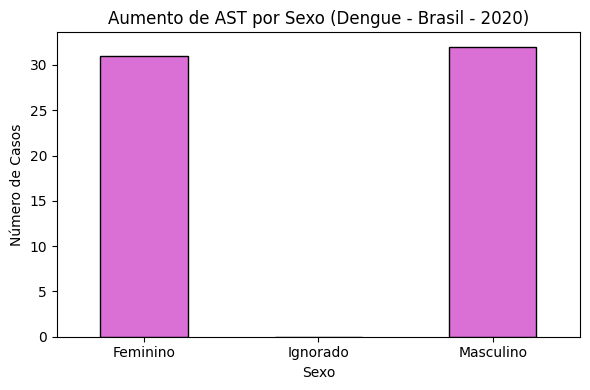

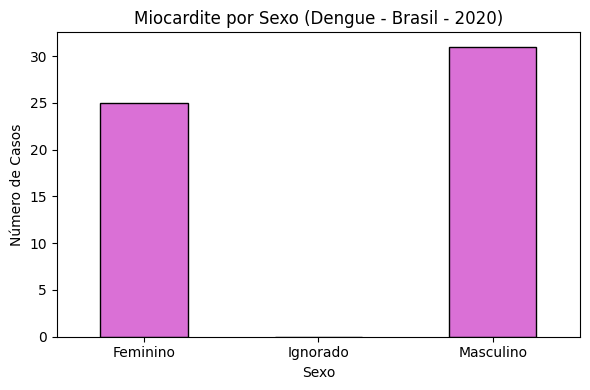

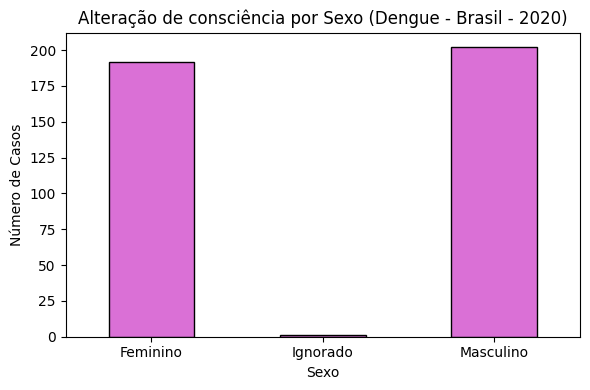

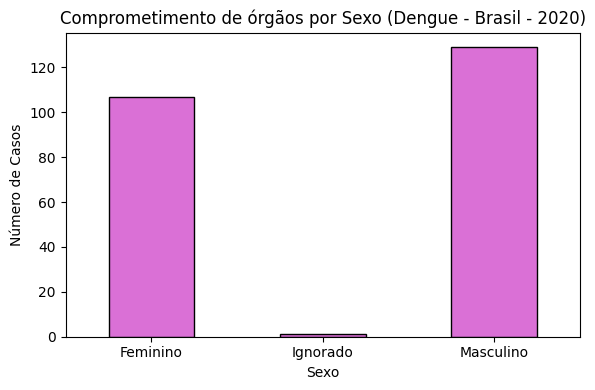

In [57]:
# Filtrar colunas GRAV_* com pelo menos um valor '1'
graves_com_1 = [col for col in graves if df[col].fillna('').eq('1').sum() > 0]
# Garantir coluna de sexo legível
df['CS_SEXO_LIMPO'] = df['CS_SEXO'].map({'M': 'Masculino', 'F': 'Feminino', 'I': 'Ignorado'})

# Gerar gráficos cruzados apenas para colunas com pelo menos um valor '1'
for col in graves_com_1:
    crosstab = pd.crosstab(df['CS_SEXO_LIMPO'], df[col].fillna(''))
    serie = crosstab.get('1', pd.Series(0, index=crosstab.index))

    plt.figure(figsize=(6,4))
    serie.plot(kind='bar', color='orchid', edgecolor='black')
    plt.title(f"{labels_legiveis.get(col, col)} por Sexo (Dengue - Brasil - 2020)")
    plt.xlabel("Sexo")
    plt.ylabel("Número de Casos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()




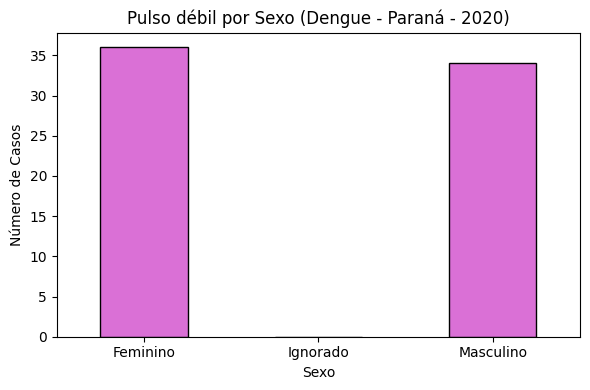

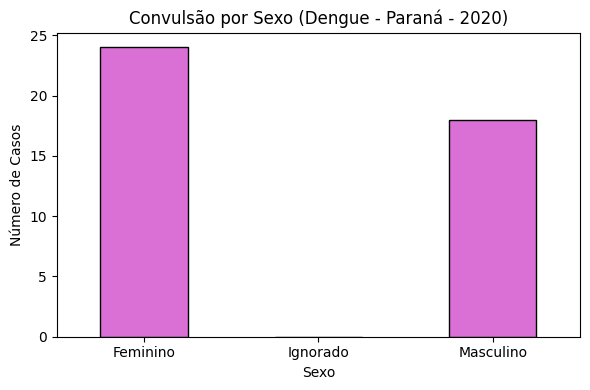

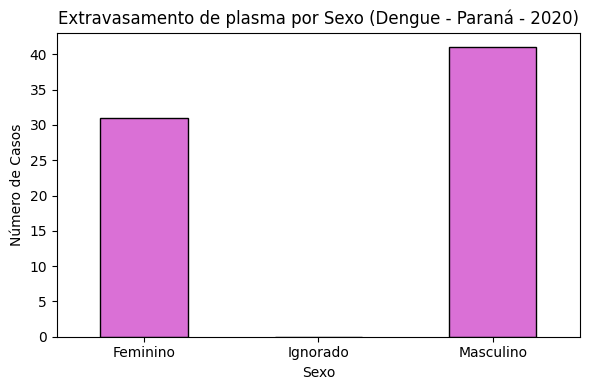

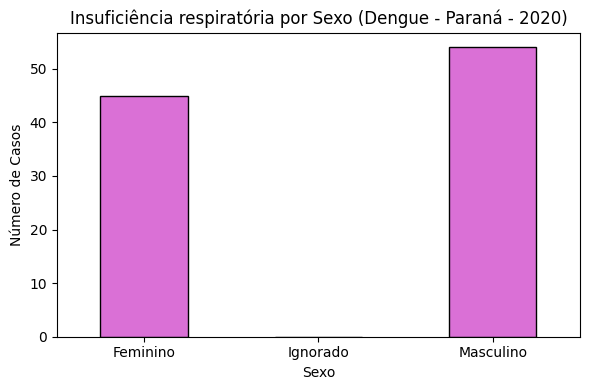

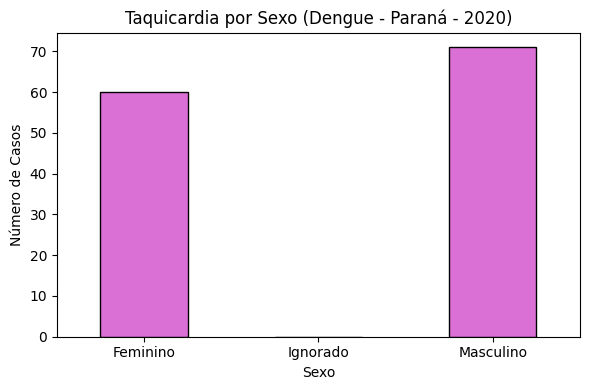

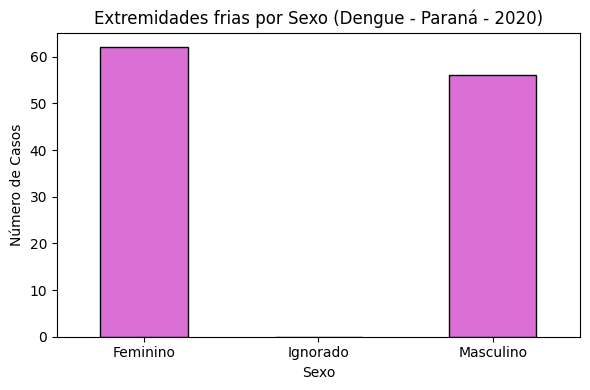

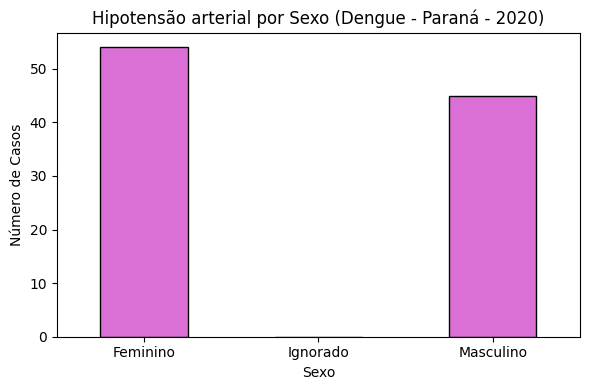

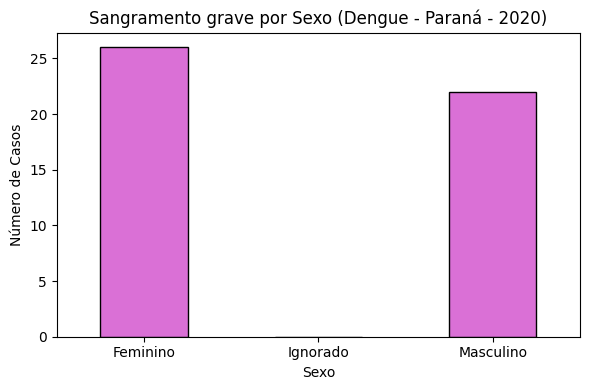

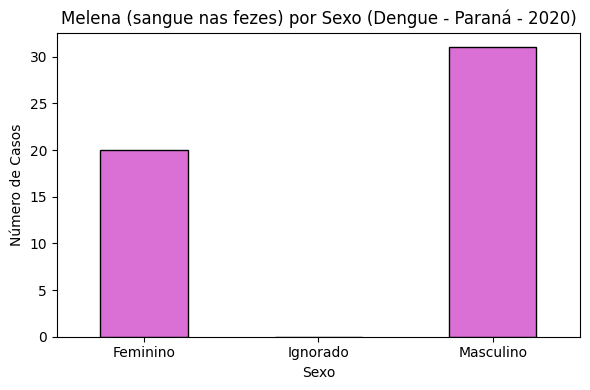

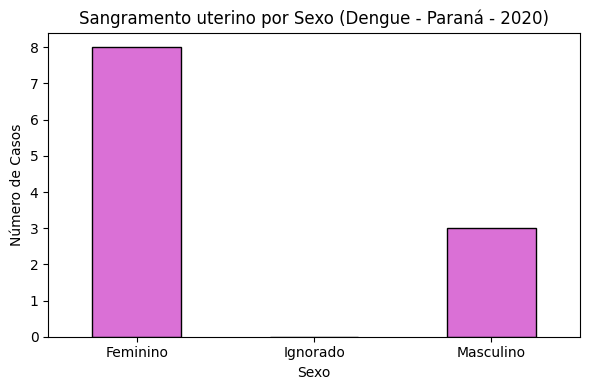

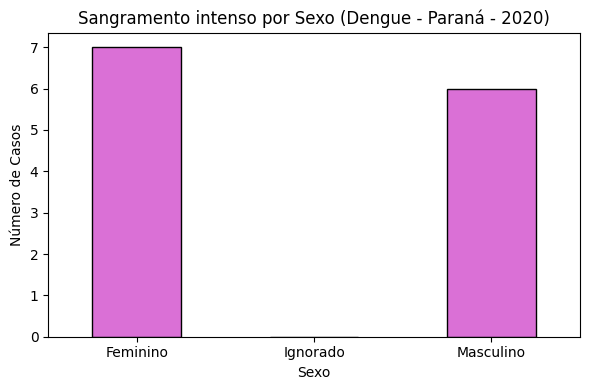

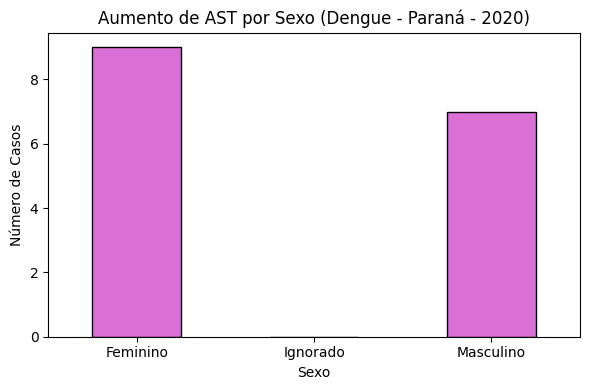

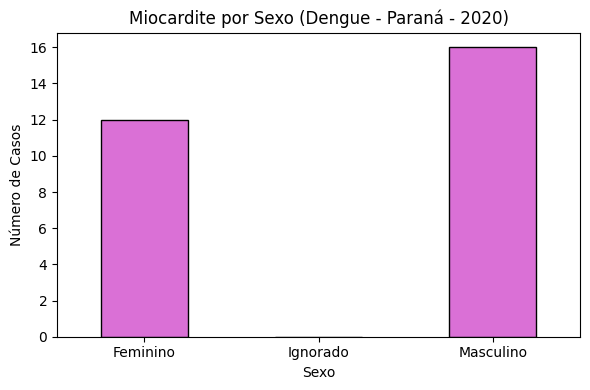

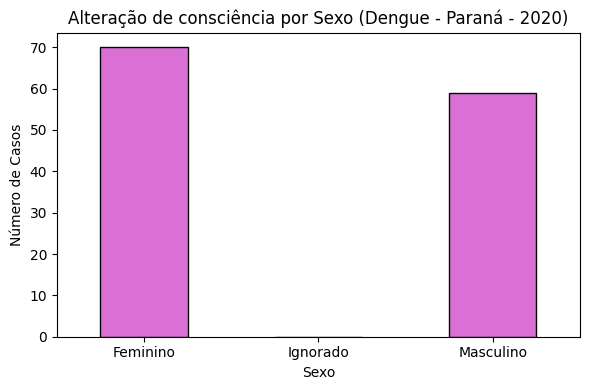

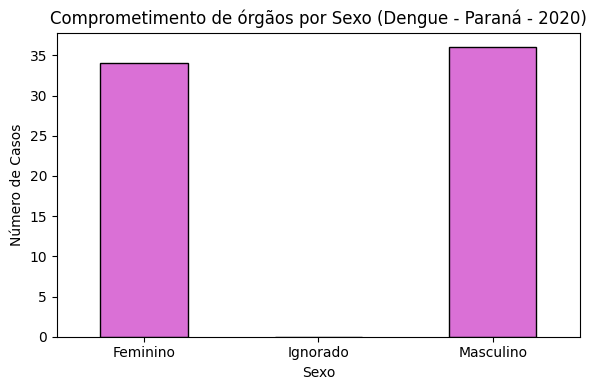

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtrar registros apenas do Paraná (SG_UF = '41')
df_pr = df[df['SG_UF'] == '41'].copy()

# 2. Seleciona colunas GRAV_* com ao menos um caso '1'
graves = [col for col in df_pr.columns if col.startswith("GRAV_")]
graves_com_1 = [col for col in graves if df_pr[col].fillna('').eq('1').sum() > 0]

# 3. Rótulos legíveis
labels_legiveis = {
    'GRAV_PULSO': 'Pulso débil',
    'GRAV_CONV': 'Convulsão',
    'GRAV_ENCH': 'Extravasamento de plasma',
    'GRAV_INSUF': 'Insuficiência respiratória',
    'GRAV_TAQUI': 'Taquicardia',
    'GRAV_EXTRE': 'Extremidades frias',
    'GRAV_HIPOT': 'Hipotensão arterial',
    'GRAV_HEMAT': 'Sangramento grave',
    'GRAV_MELEN': 'Melena (sangue nas fezes)',
    'GRAV_METRO': 'Sangramento uterino',
    'GRAV_SANG': 'Sangramento intenso',
    'GRAV_AST': 'Aumento de AST',
    'GRAV_MIOC': 'Miocardite',
    'GRAV_CONSC': 'Alteração de consciência',
    'GRAV_ORGAO': 'Comprometimento de órgãos'
}

# 4. Mapeia sexo legível
df_pr['CS_SEXO_LIMPO'] = df_pr['CS_SEXO'].map({
    'M': 'Masculino',
    'F': 'Feminino',
    'I': 'Ignorado'
})

# 5. Gera gráficos apenas para colunas com pelo menos um '1'
for col in graves_com_1:
    crosstab = pd.crosstab(df_pr['CS_SEXO_LIMPO'], df_pr[col].fillna(''))
    serie = crosstab.get('1', pd.Series(0, index=crosstab.index))

    plt.figure(figsize=(6,4))
    serie.plot(kind='bar', color='orchid', edgecolor='black')
    plt.title(f"{labels_legiveis.get(col, col)} por Sexo (Dengue - Paraná - 2020)")
    plt.xlabel("Sexo")
    plt.ylabel("Número de Casos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


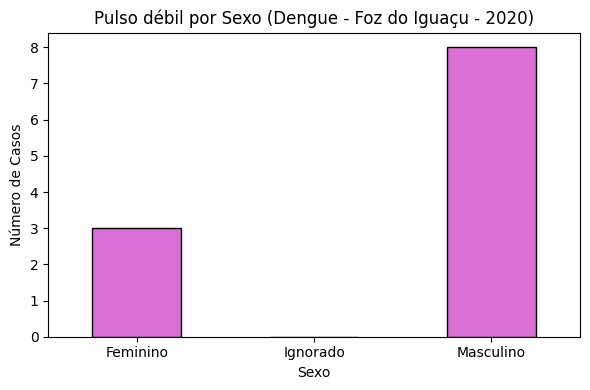

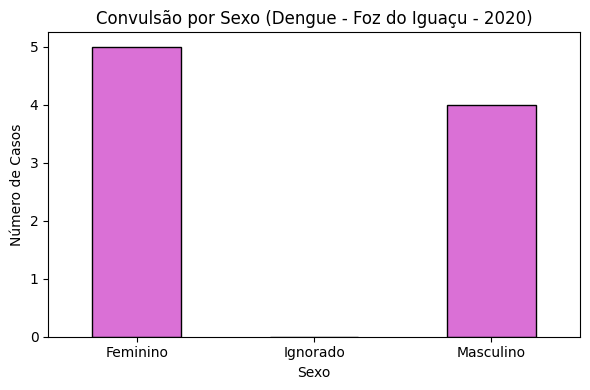

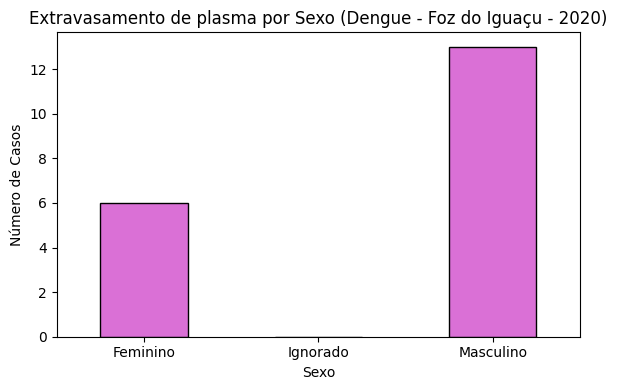

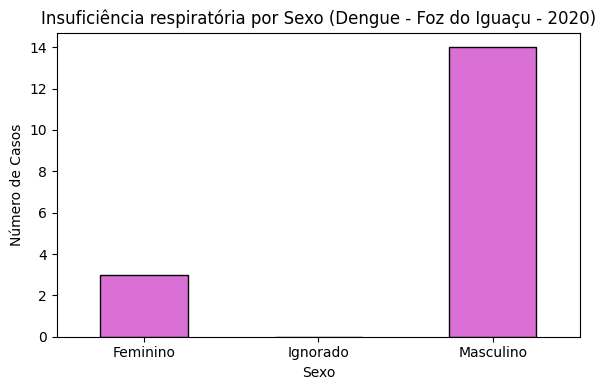

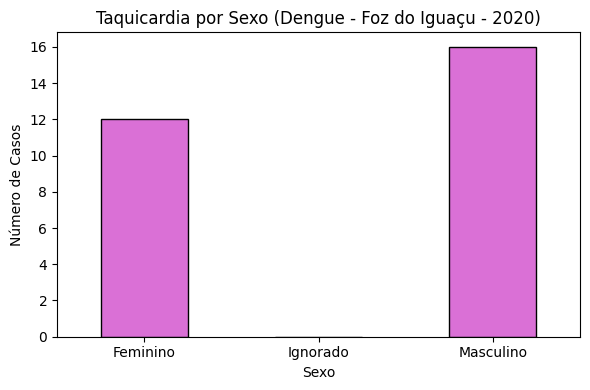

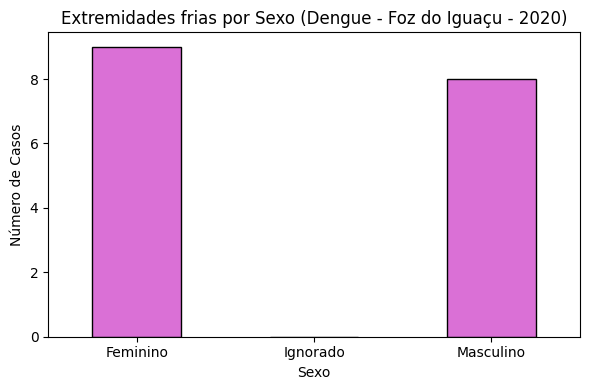

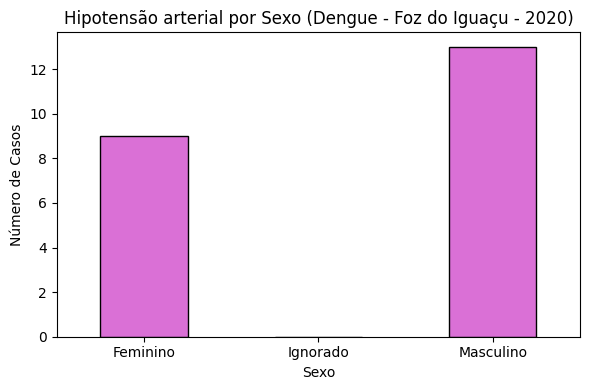

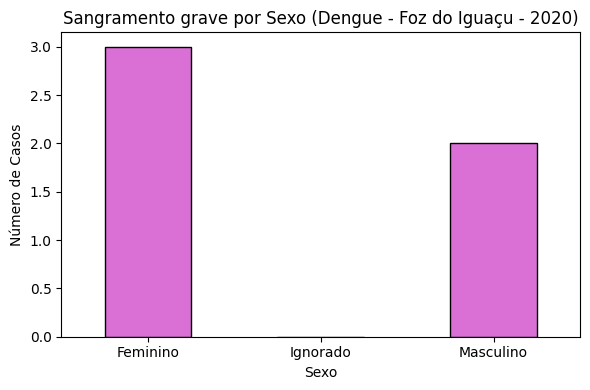

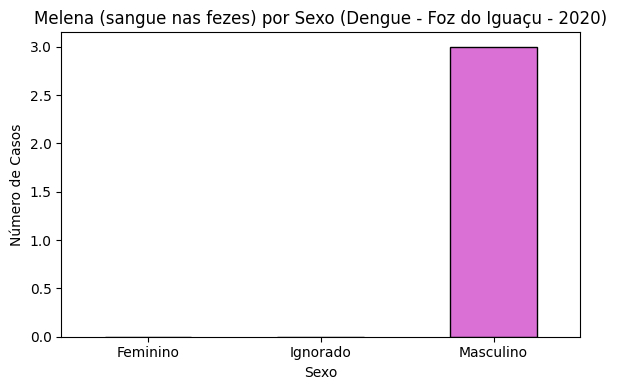

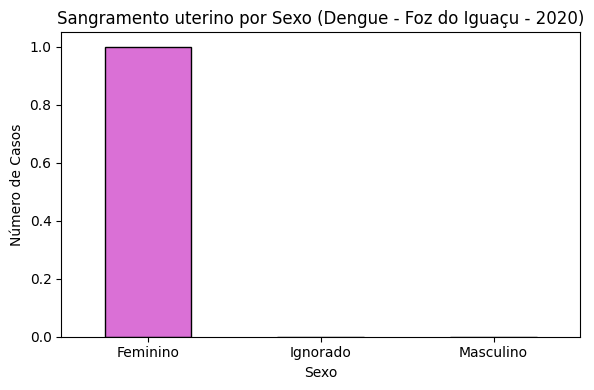

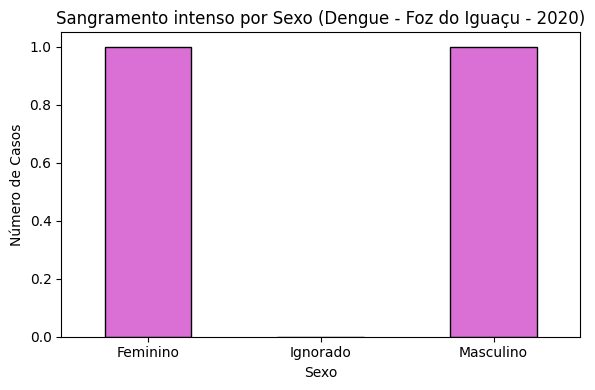

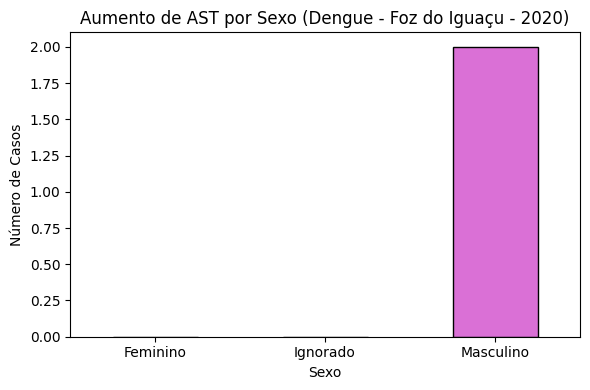

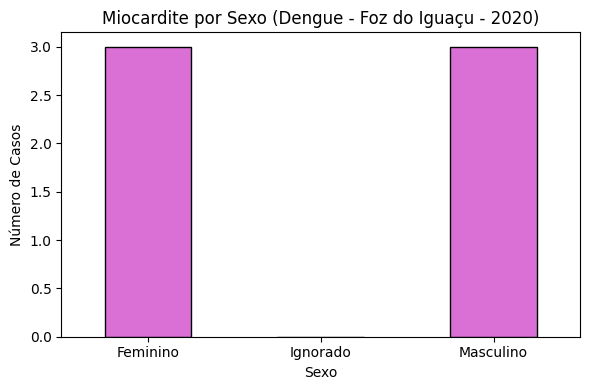

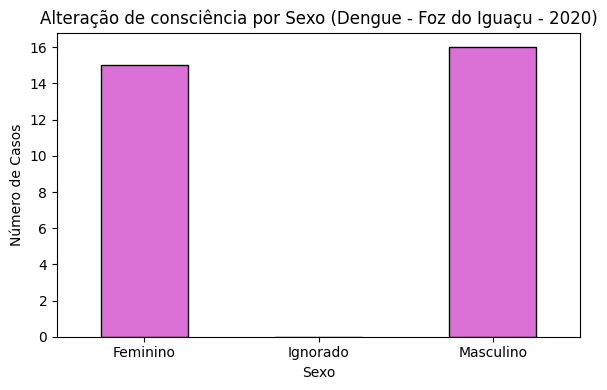

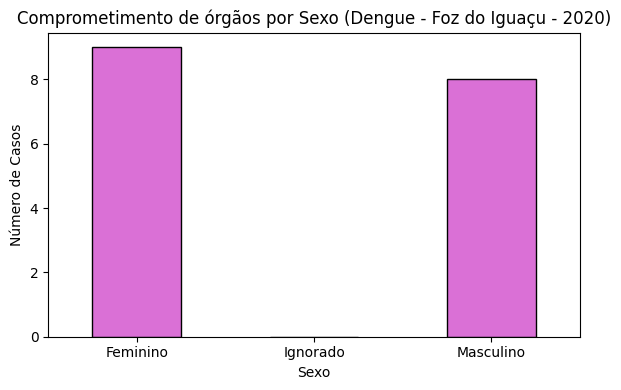

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra registros de Foz do Iguaçu (SG_UF = '41', MUNICIPIO = '410830')
df_foz = df[
    (df['SG_UF'] == '41') &
    (df['MUNICIPIO'].astype(str).str.zfill(6) == '410830')
].copy()

# 2. Seleciona colunas GRAV_* com ao menos um caso '1'
graves = [col for col in df_foz.columns if col.startswith("GRAV_")]
graves_com_1 = [col for col in graves if df_foz[col].fillna('').eq('1').sum() > 0]

# 3. Rótulos legíveis
labels_legiveis = {
    'GRAV_PULSO': 'Pulso débil',
    'GRAV_CONV': 'Convulsão',
    'GRAV_ENCH': 'Extravasamento de plasma',
    'GRAV_INSUF': 'Insuficiência respiratória',
    'GRAV_TAQUI': 'Taquicardia',
    'GRAV_EXTRE': 'Extremidades frias',
    'GRAV_HIPOT': 'Hipotensão arterial',
    'GRAV_HEMAT': 'Sangramento grave',
    'GRAV_MELEN': 'Melena (sangue nas fezes)',
    'GRAV_METRO': 'Sangramento uterino',
    'GRAV_SANG': 'Sangramento intenso',
    'GRAV_AST': 'Aumento de AST',
    'GRAV_MIOC': 'Miocardite',
    'GRAV_CONSC': 'Alteração de consciência',
    'GRAV_ORGAO': 'Comprometimento de órgãos'
}

# 4. Mapeia sexo legível
df_foz['CS_SEXO_LIMPO'] = df_foz['CS_SEXO'].map({
    'M': 'Masculino',
    'F': 'Feminino',
    'I': 'Ignorado'
})

# 5. Gera gráficos apenas para colunas com pelo menos um '1'
for col in graves_com_1:
    crosstab = pd.crosstab(df_foz['CS_SEXO_LIMPO'], df_foz[col].fillna(''))
    serie = crosstab.get('1', pd.Series(0, index=crosstab.index))

    plt.figure(figsize=(6,4))
    serie.plot(kind='bar', color='orchid', edgecolor='black')
    plt.title(f"{labels_legiveis.get(col, col)} por Sexo (Dengue - Foz do Iguaçu - 2020)")
    plt.xlabel("Sexo")
    plt.ylabel("Número de Casos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


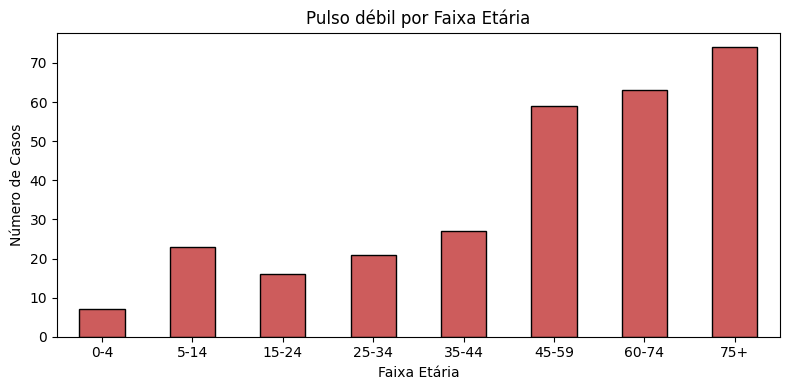

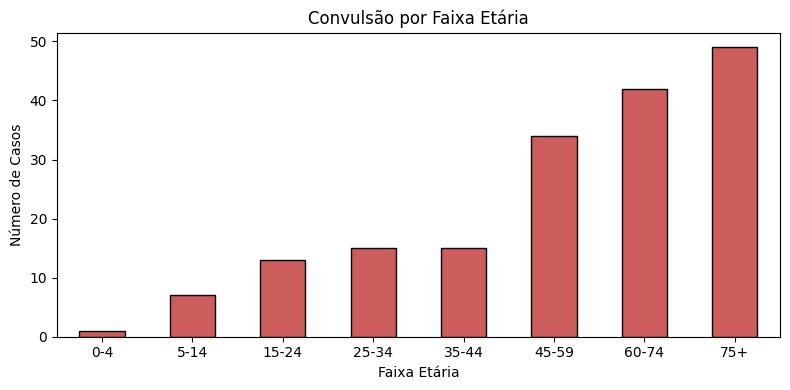

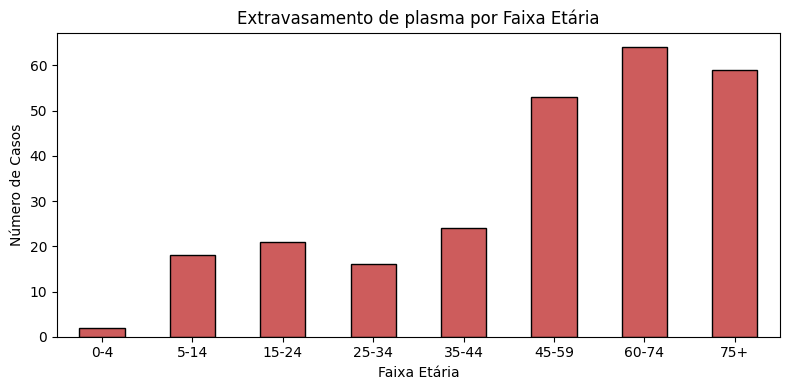

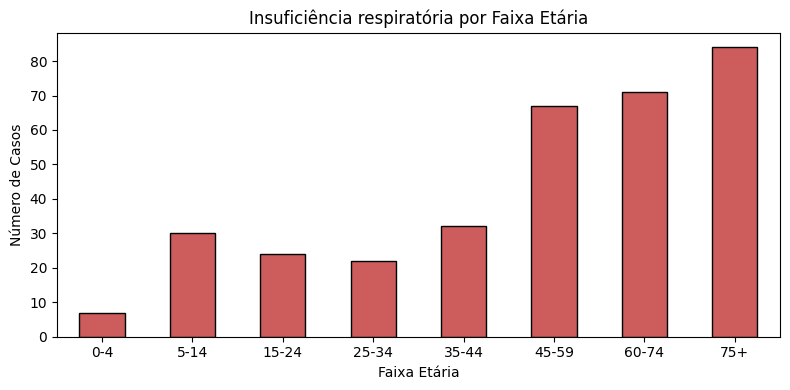

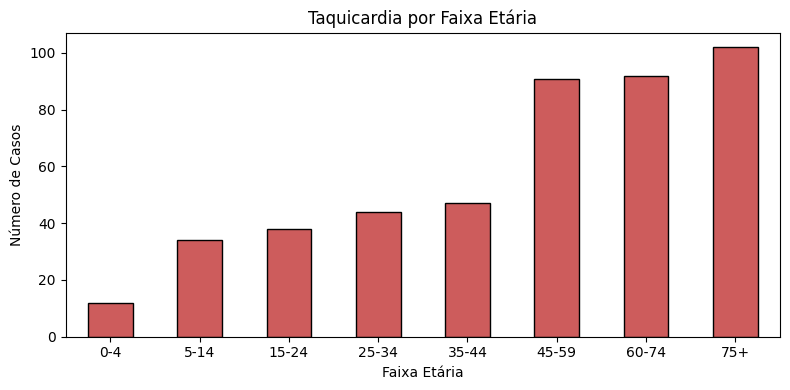

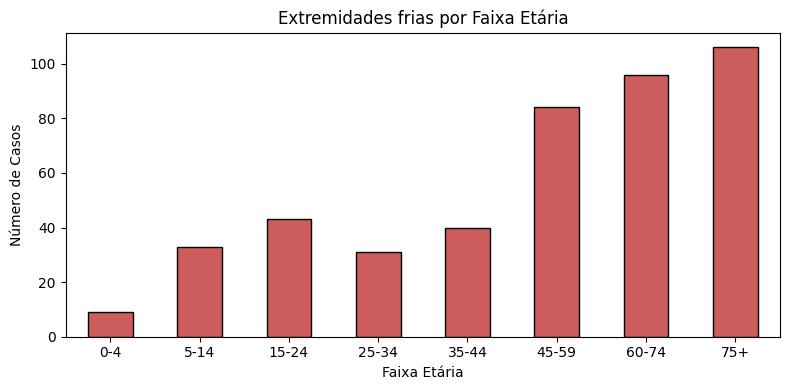

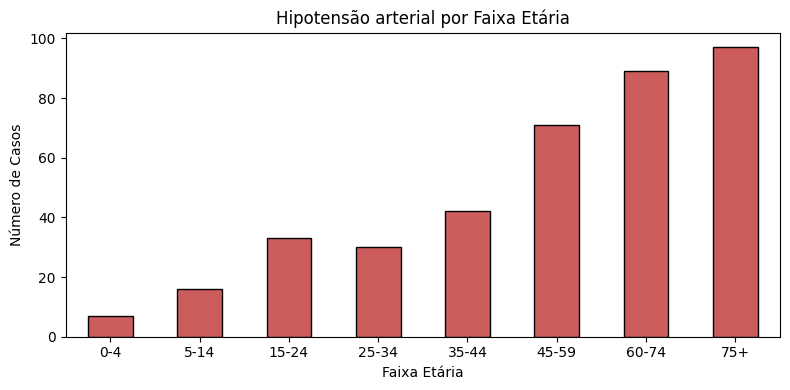

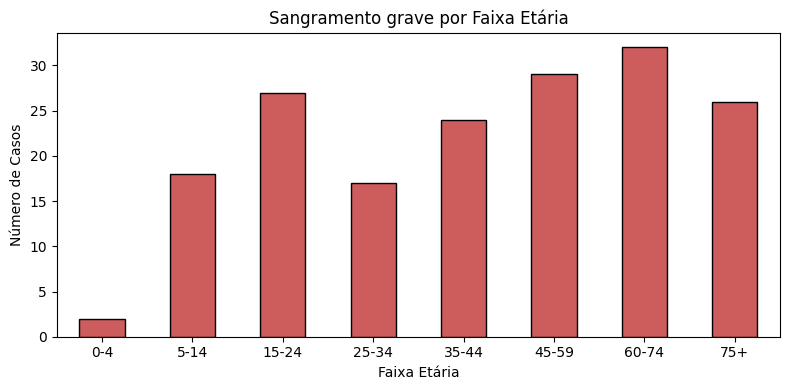

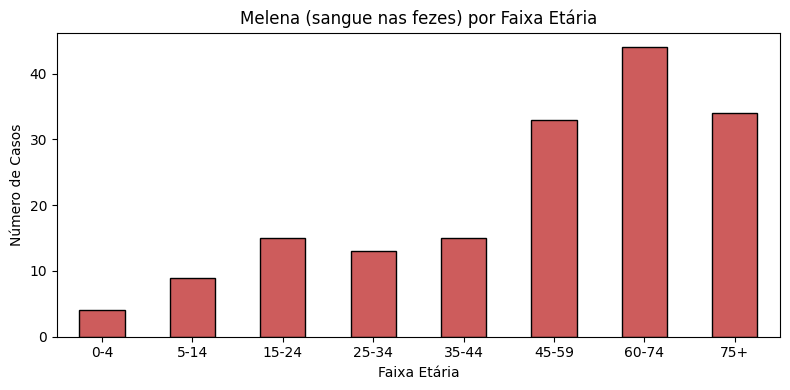

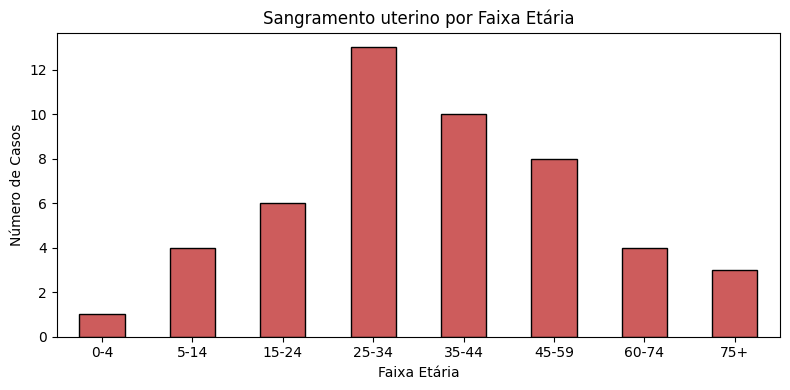

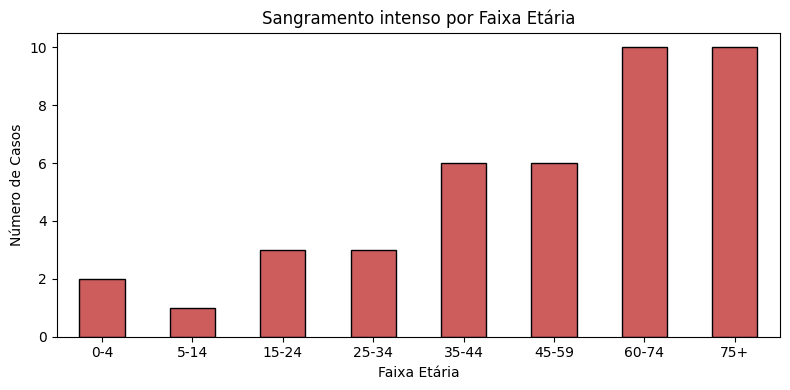

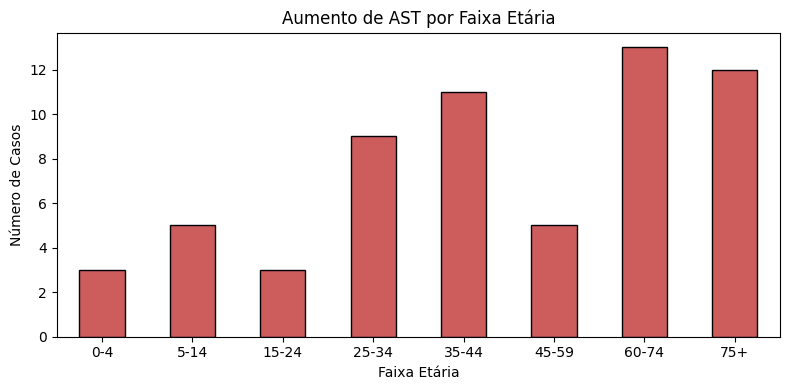

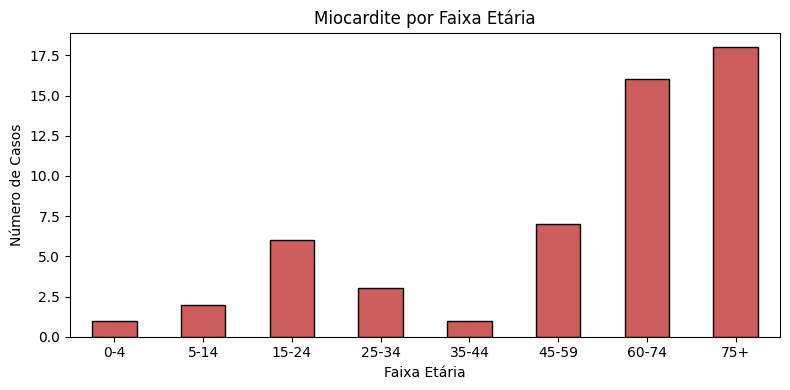

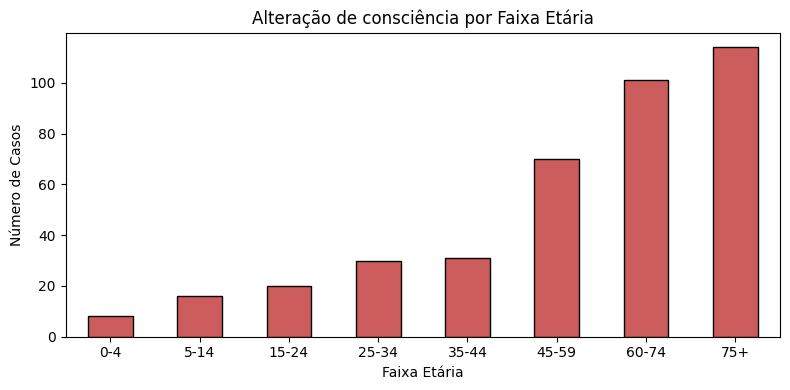

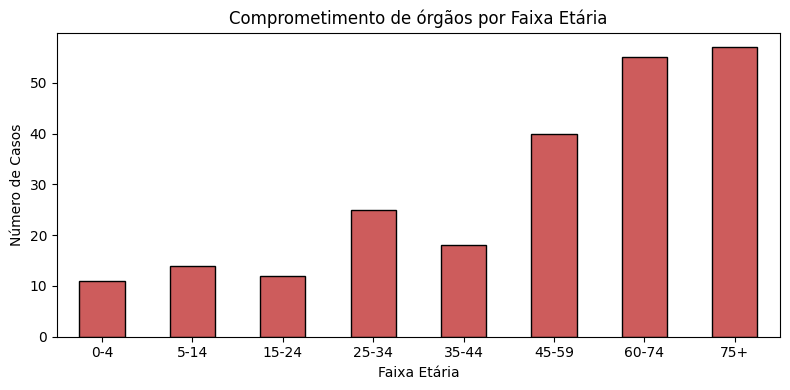

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Corrige datas e calcula idade
df['DT_NASC'] = pd.to_datetime(df['DT_NASC'], errors='coerce')
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce')

def calcular_idade(linha):
    if pd.isna(linha['DT_NASC']) or pd.isna(linha['DT_NOTIFIC']):
        return pd.NA
    idade = linha['DT_NOTIFIC'].year - linha['DT_NASC'].year
    if (linha['DT_NOTIFIC'].month, linha['DT_NOTIFIC'].day) < (linha['DT_NASC'].month, linha['DT_NASC'].day):
        idade -= 1
    return idade

df['IDADE_CALCULADA'] = df.apply(calcular_idade, axis=1)

# 2. Remove linhas sem idade válida
df_validos = df.dropna(subset=['IDADE_CALCULADA']).copy()

# 3. Cria faixa etária
df_validos['faixa_etaria'] = pd.cut(
    df_validos['IDADE_CALCULADA'],
    bins=[0, 4, 14, 24, 34, 44, 59, 74, 120],
    labels=['0-4', '5-14', '15-24', '25-34', '35-44', '45-59', '60-74', '75+']
)

# 4. Lista de variáveis GRAV_
graves = [col for col in df.columns if col.startswith("GRAV_")]

# 5. Rótulos legíveis
labels_legiveis = {
    'GRAV_PULSO': 'Pulso débil',
    'GRAV_CONV': 'Convulsão',
    'GRAV_ENCH': 'Extravasamento de plasma',
    'GRAV_INSUF': 'Insuficiência respiratória',
    'GRAV_TAQUI': 'Taquicardia',
    'GRAV_EXTRE': 'Extremidades frias',
    'GRAV_HIPOT': 'Hipotensão arterial',
    'GRAV_HEMAT': 'Sangramento grave',
    'GRAV_MELEN': 'Melena (sangue nas fezes)',
    'GRAV_METRO': 'Sangramento uterino',
    'GRAV_SANG': 'Sangramento intenso',
    'GRAV_AST': 'Aumento de AST',
    'GRAV_MIOC': 'Miocardite',
    'GRAV_CONSC': 'Alteração de consciência',
    'GRAV_ORGAO': 'Comprometimento de órgãos'
}

# 6. Gera gráficos por faixa etária para cada GRAV_*
for col in graves:
    df_validos[col + '_BIN'] = df_validos[col].fillna('').astype(str).str.strip().eq('1').astype(int)
    cruzada = df_validos.groupby('faixa_etaria', observed=True)[col + '_BIN'].sum()

    if cruzada.sum() == 0:
        continue

    plt.figure(figsize=(8,4))
    cruzada.plot(kind='bar', color='indianred', edgecolor='black')
    plt.title(f"{labels_legiveis.get(col, col)} por Faixa Etária")
    plt.xlabel("Faixa Etária")
    plt.ylabel("Número de Casos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()




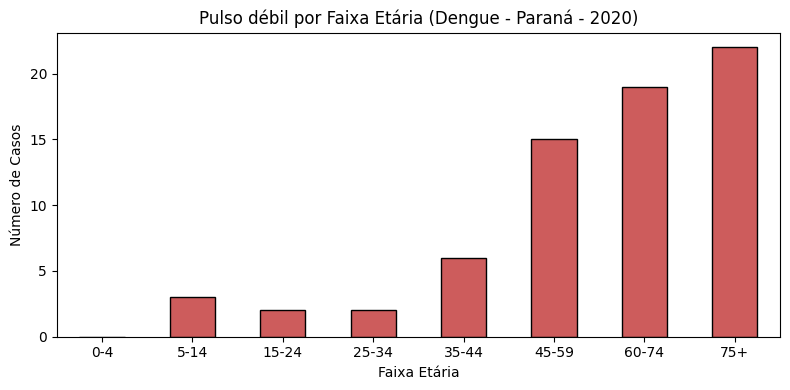

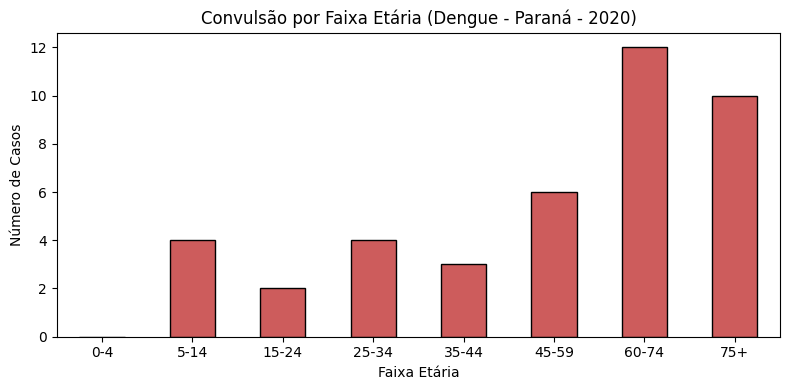

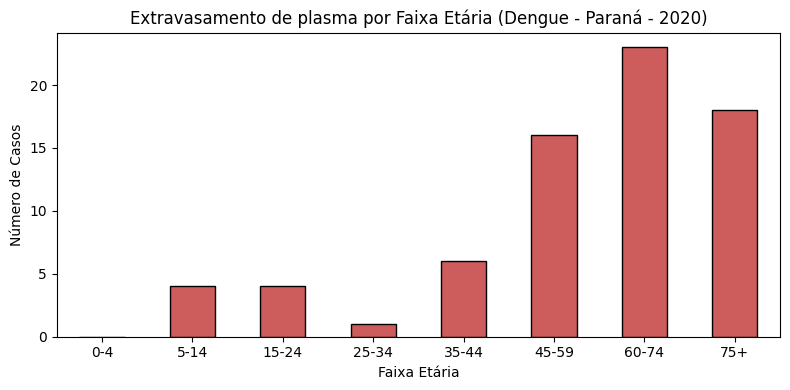

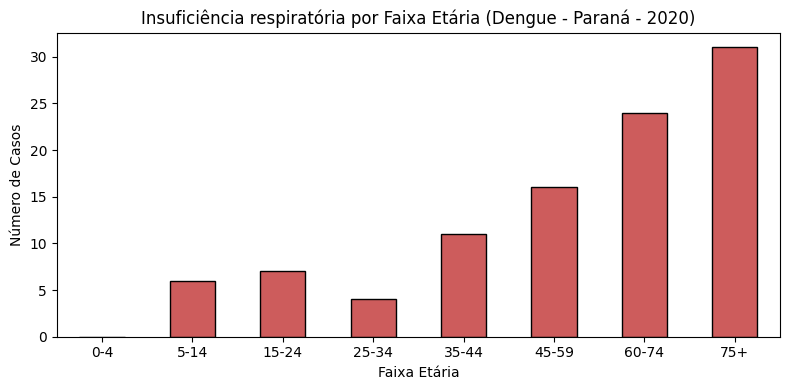

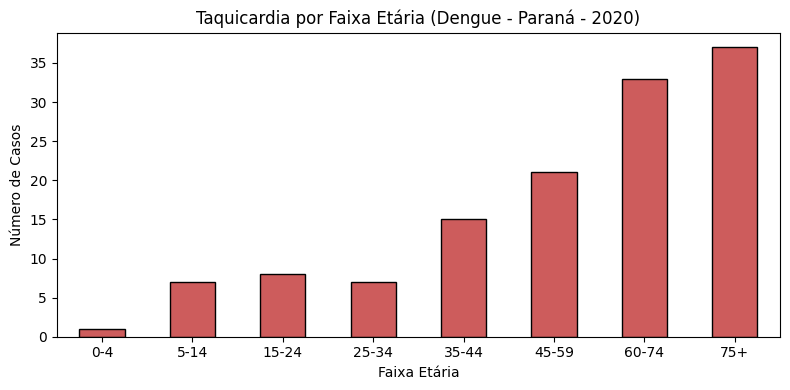

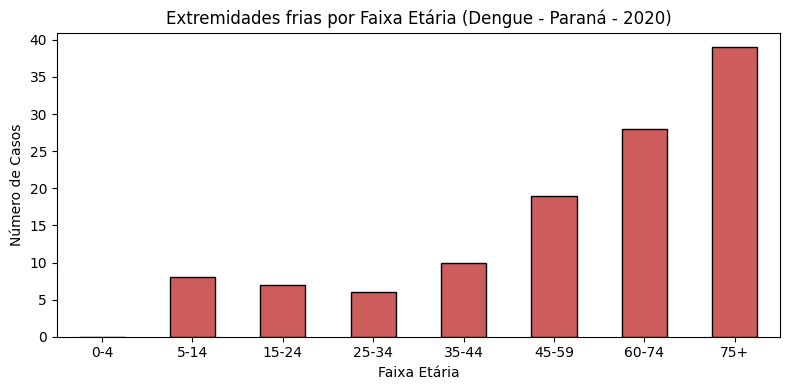

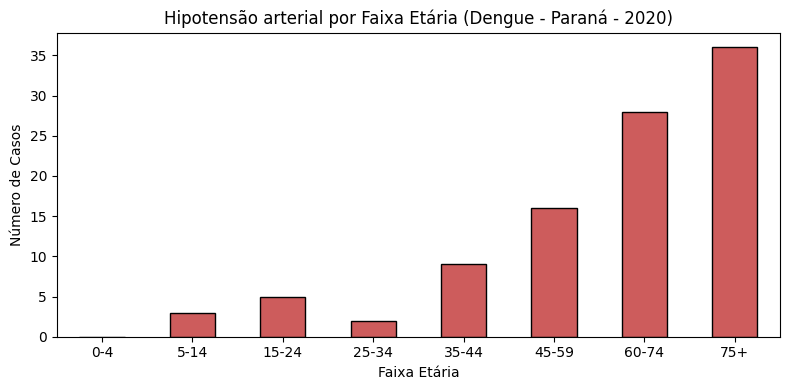

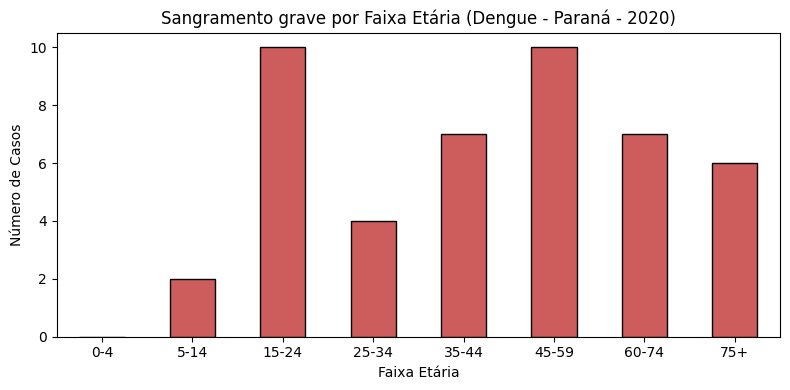

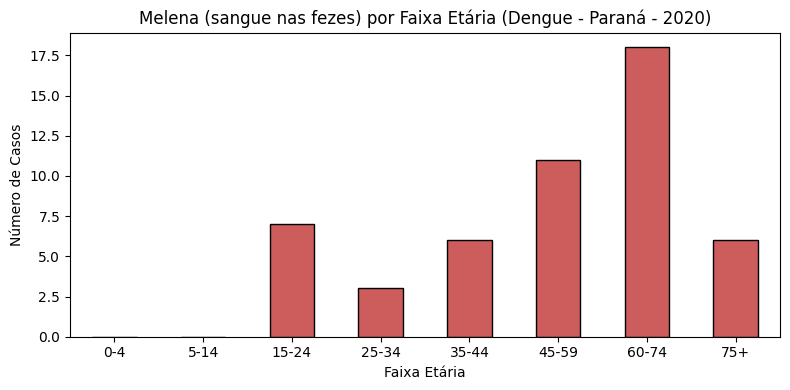

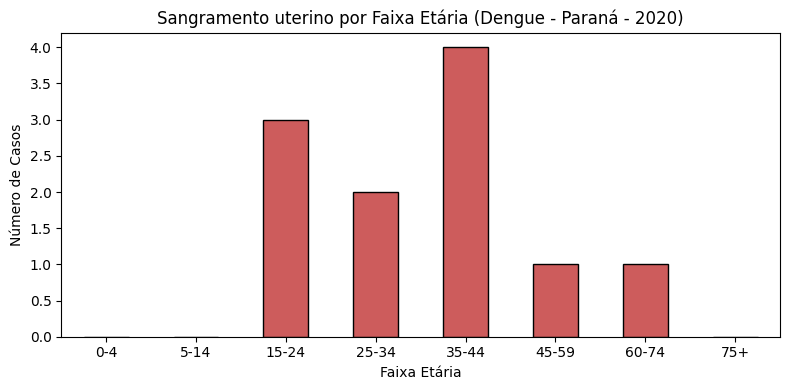

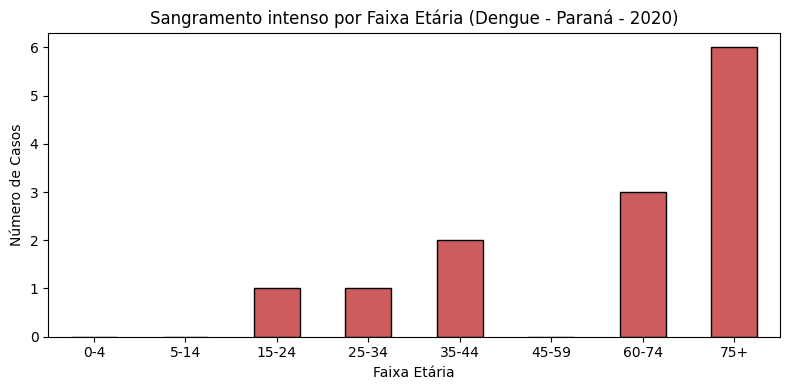

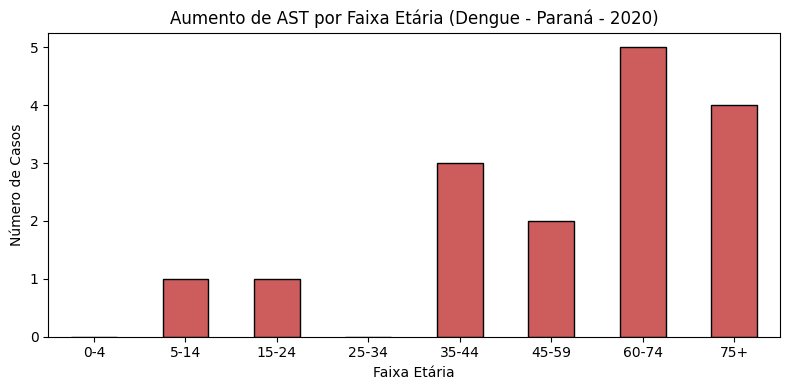

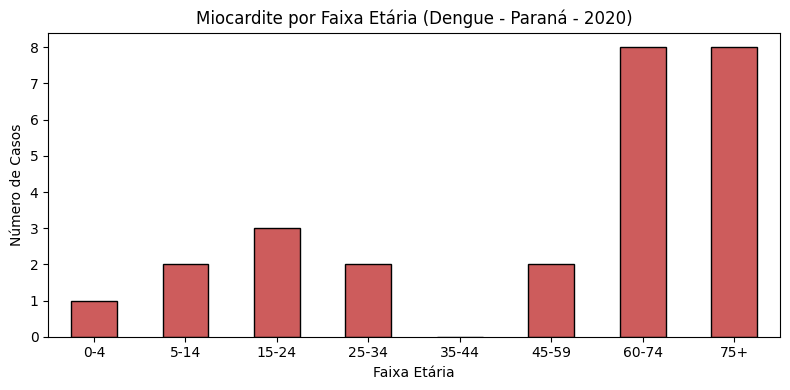

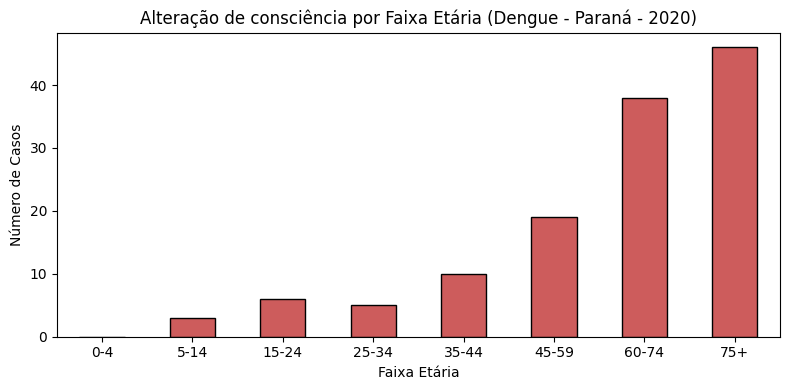

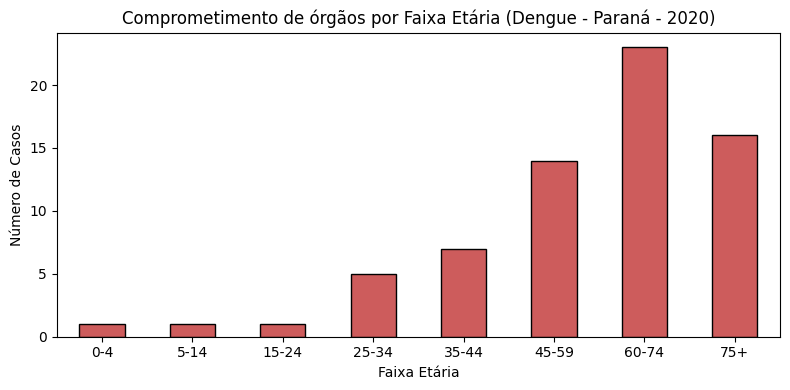

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra apenas registros do Paraná
df_parana = df[df['SG_UF'] == '41'].copy()

# 2. Corrige datas e calcula idade
df_parana['DT_NASC'] = pd.to_datetime(df_parana['DT_NASC'], errors='coerce')
df_parana['DT_NOTIFIC'] = pd.to_datetime(df_parana['DT_NOTIFIC'], errors='coerce')

def calcular_idade(linha):
    if pd.isna(linha['DT_NASC']) or pd.isna(linha['DT_NOTIFIC']):
        return pd.NA
    idade = linha['DT_NOTIFIC'].year - linha['DT_NASC'].year
    if (linha['DT_NOTIFIC'].month, linha['DT_NOTIFIC'].day) < (linha['DT_NASC'].month, linha['DT_NASC'].day):
        idade -= 1
    return idade

df_parana['IDADE_CALCULADA'] = df_parana.apply(calcular_idade, axis=1)

# 3. Remove registros sem idade válida
df_validos = df_parana.dropna(subset=['IDADE_CALCULADA']).copy()

# 4. Cria faixa etária
df_validos['faixa_etaria'] = pd.cut(
    df_validos['IDADE_CALCULADA'],
    bins=[0, 4, 14, 24, 34, 44, 59, 74, 120],
    labels=['0-4', '5-14', '15-24', '25-34', '35-44', '45-59', '60-74', '75+']
)

# 5. Lista de variáveis GRAV_
graves = [col for col in df_validos.columns if col.startswith("GRAV_")]

# 6. Rótulos legíveis
labels_legiveis = {
    'GRAV_PULSO': 'Pulso débil',
    'GRAV_CONV': 'Convulsão',
    'GRAV_ENCH': 'Extravasamento de plasma',
    'GRAV_INSUF': 'Insuficiência respiratória',
    'GRAV_TAQUI': 'Taquicardia',
    'GRAV_EXTRE': 'Extremidades frias',
    'GRAV_HIPOT': 'Hipotensão arterial',
    'GRAV_HEMAT': 'Sangramento grave',
    'GRAV_MELEN': 'Melena (sangue nas fezes)',
    'GRAV_METRO': 'Sangramento uterino',
    'GRAV_SANG': 'Sangramento intenso',
    'GRAV_AST': 'Aumento de AST',
    'GRAV_MIOC': 'Miocardite',
    'GRAV_CONSC': 'Alteração de consciência',
    'GRAV_ORGAO': 'Comprometimento de órgãos'
}

# 7. Gera gráficos para cada variável GRAV_ por faixa etária
for col in graves:
    df_validos[col + '_BIN'] = df_validos[col].fillna('').astype(str).str.strip().eq('1').astype(int)
    cruzada = df_validos.groupby('faixa_etaria', observed=True)[col + '_BIN'].sum()

    if cruzada.sum() == 0:
        continue

    plt.figure(figsize=(8, 4))
    cruzada.plot(kind='bar', color='indianred', edgecolor='black')
    plt.title(f"{labels_legiveis.get(col, col)} por Faixa Etária (Dengue - Paraná - 2020)")
    plt.xlabel("Faixa Etária")
    plt.ylabel("Número de Casos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


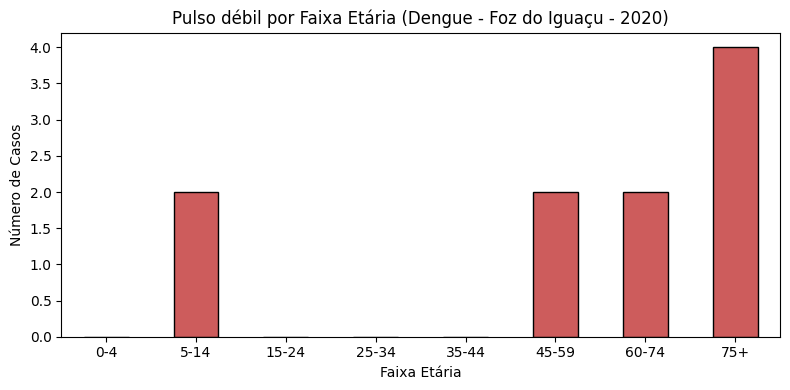

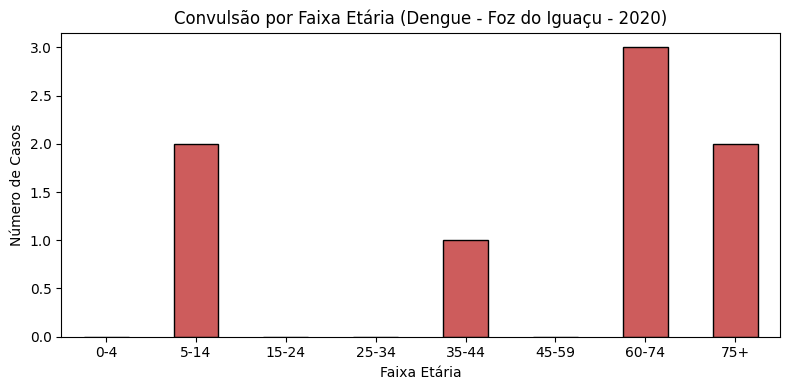

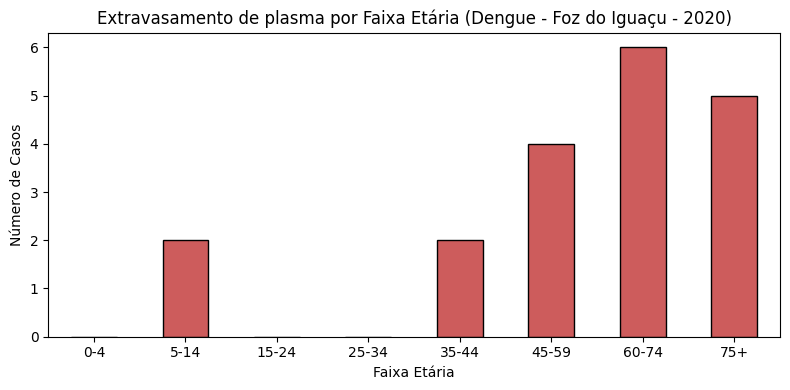

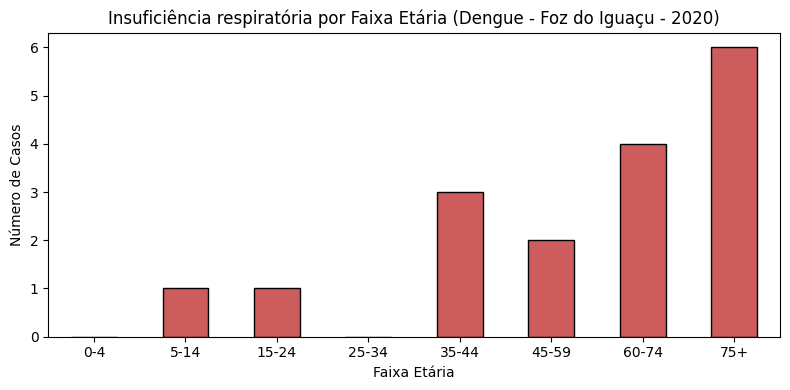

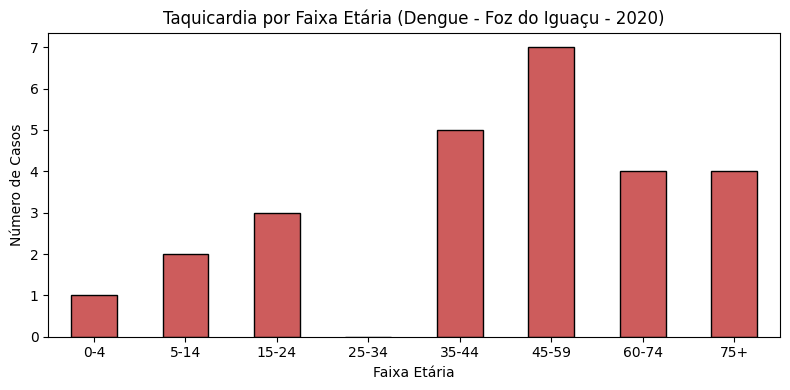

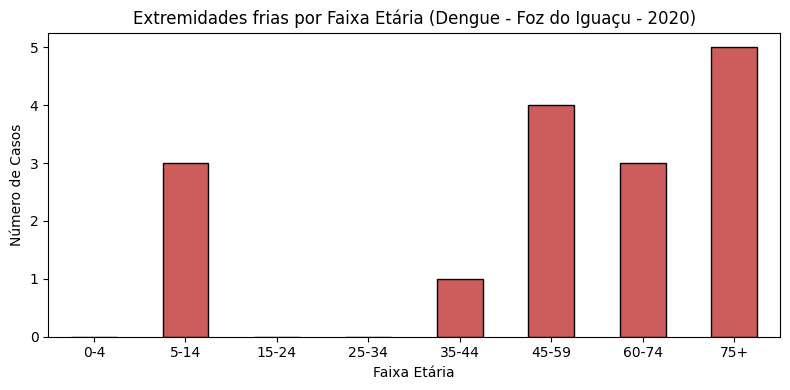

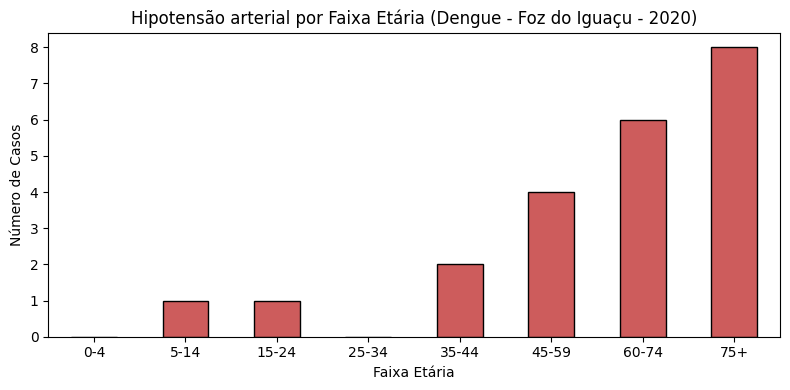

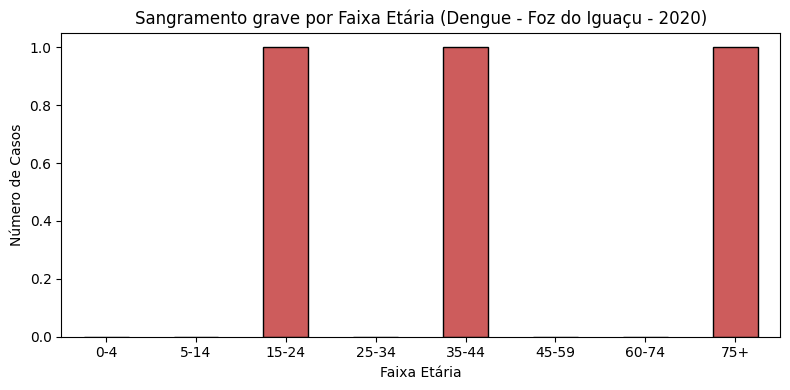

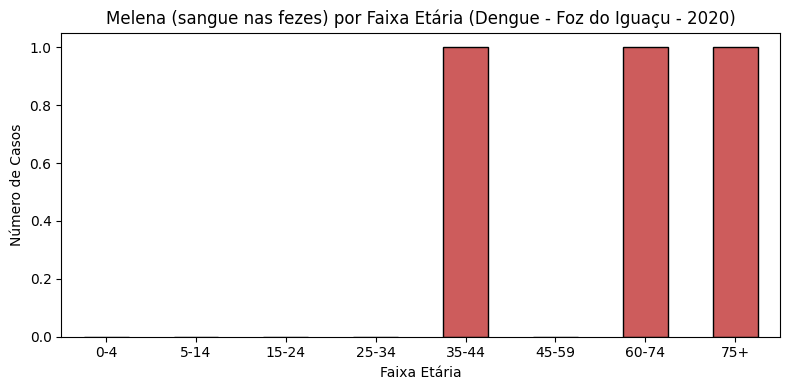

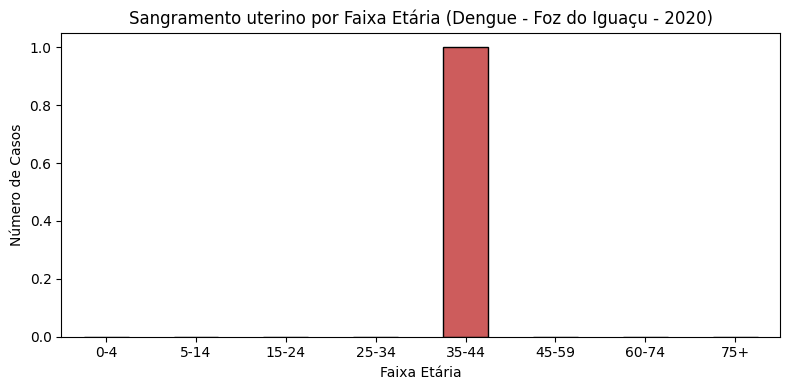

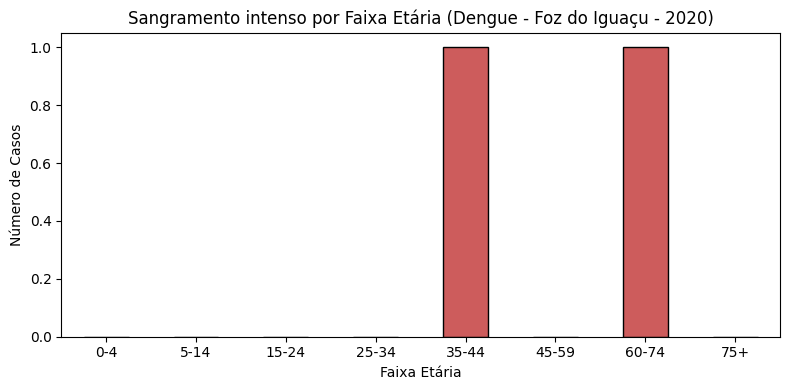

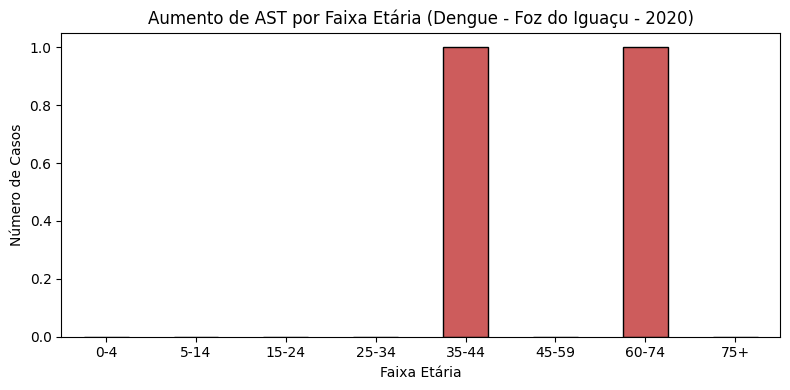

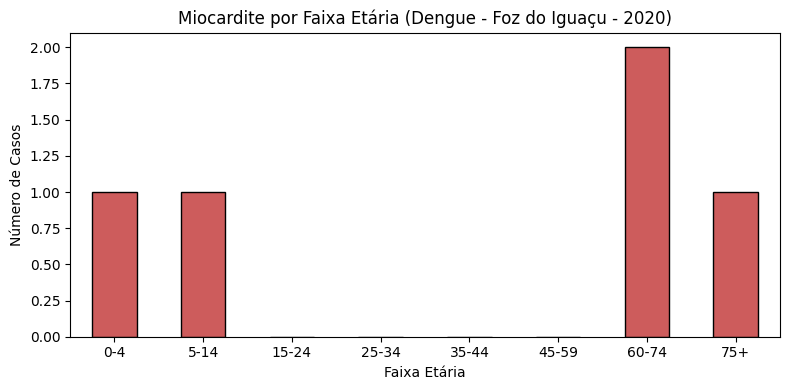

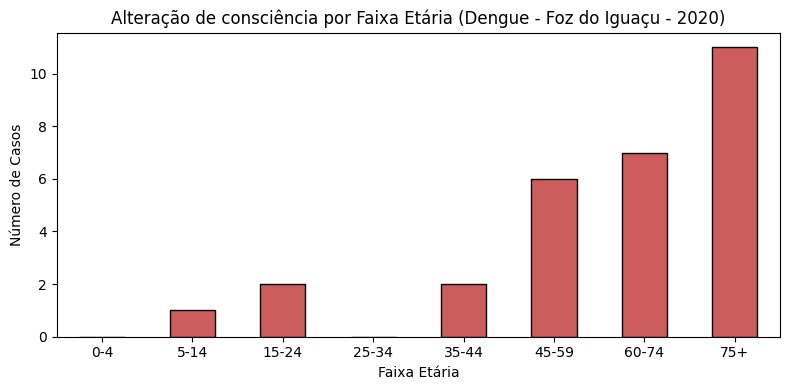

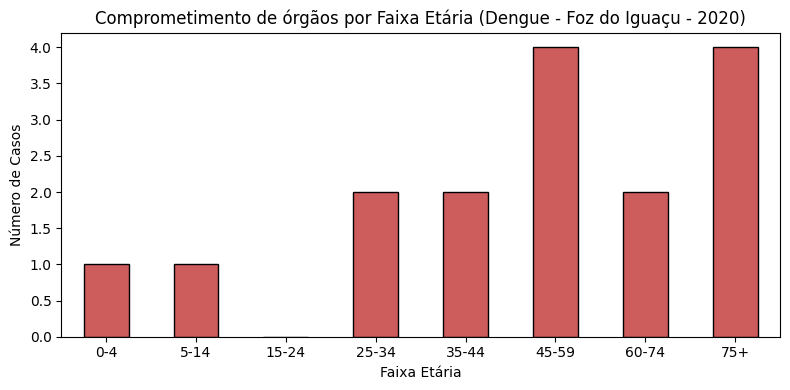

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra registros de Foz do Iguaçu
df_foz = df[
    (df['SG_UF'] == '41') &
    (df['MUNICIPIO'].astype(str).str.zfill(6) == '410830')
].copy()

# 2. Corrige datas e calcula idade
df_foz['DT_NASC'] = pd.to_datetime(df_foz['DT_NASC'], errors='coerce')
df_foz['DT_NOTIFIC'] = pd.to_datetime(df_foz['DT_NOTIFIC'], errors='coerce')

def calcular_idade(linha):
    if pd.isna(linha['DT_NASC']) or pd.isna(linha['DT_NOTIFIC']):
        return pd.NA
    idade = linha['DT_NOTIFIC'].year - linha['DT_NASC'].year
    if (linha['DT_NOTIFIC'].month, linha['DT_NOTIFIC'].day) < (linha['DT_NASC'].month, linha['DT_NASC'].day):
        idade -= 1
    return idade

df_foz['IDADE_CALCULADA'] = df_foz.apply(calcular_idade, axis=1)

# 3. Remove registros sem idade válida
df_validos = df_foz.dropna(subset=['IDADE_CALCULADA']).copy()

# 4. Cria faixa etária
df_validos['faixa_etaria'] = pd.cut(
    df_validos['IDADE_CALCULADA'],
    bins=[0, 4, 14, 24, 34, 44, 59, 74, 120],
    labels=['0-4', '5-14', '15-24', '25-34', '35-44', '45-59', '60-74', '75+']
)

# 5. Lista de variáveis GRAV_
graves = [col for col in df_validos.columns if col.startswith("GRAV_")]

# 6. Rótulos legíveis
labels_legiveis = {
    'GRAV_PULSO': 'Pulso débil',
    'GRAV_CONV': 'Convulsão',
    'GRAV_ENCH': 'Extravasamento de plasma',
    'GRAV_INSUF': 'Insuficiência respiratória',
    'GRAV_TAQUI': 'Taquicardia',
    'GRAV_EXTRE': 'Extremidades frias',
    'GRAV_HIPOT': 'Hipotensão arterial',
    'GRAV_HEMAT': 'Sangramento grave',
    'GRAV_MELEN': 'Melena (sangue nas fezes)',
    'GRAV_METRO': 'Sangramento uterino',
    'GRAV_SANG': 'Sangramento intenso',
    'GRAV_AST': 'Aumento de AST',
    'GRAV_MIOC': 'Miocardite',
    'GRAV_CONSC': 'Alteração de consciência',
    'GRAV_ORGAO': 'Comprometimento de órgãos'
}

# 7. Gera gráficos para cada variável GRAV_ por faixa etária
for col in graves:
    df_validos[col + '_BIN'] = df_validos[col].fillna('').astype(str).str.strip().eq('1').astype(int)
    cruzada = df_validos.groupby('faixa_etaria', observed=True)[col + '_BIN'].sum()

    if cruzada.sum() == 0:
        continue

    plt.figure(figsize=(8, 4))
    cruzada.plot(kind='bar', color='indianred', edgecolor='black')
    plt.title(f"{labels_legiveis.get(col, col)} por Faixa Etária (Dengue - Foz do Iguaçu - 2020)")
    plt.xlabel("Faixa Etária")
    plt.ylabel("Número de Casos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


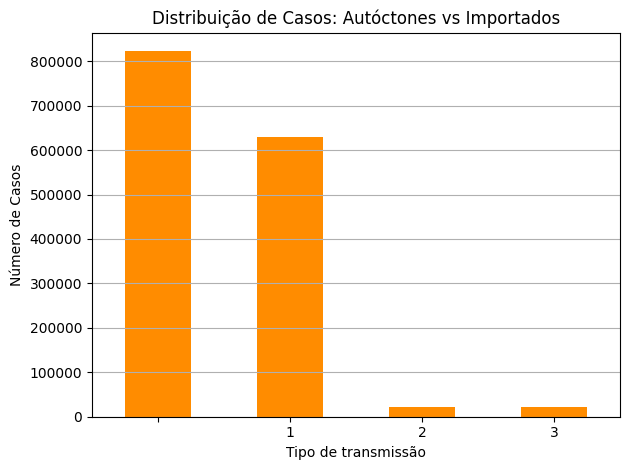

In [66]:
df['TPAUTOCTO'].value_counts(dropna=False).plot(kind='bar', color='darkorange')
plt.title("Distribuição de Casos: Autóctones vs Importados")
plt.xlabel("Tipo de transmissão")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

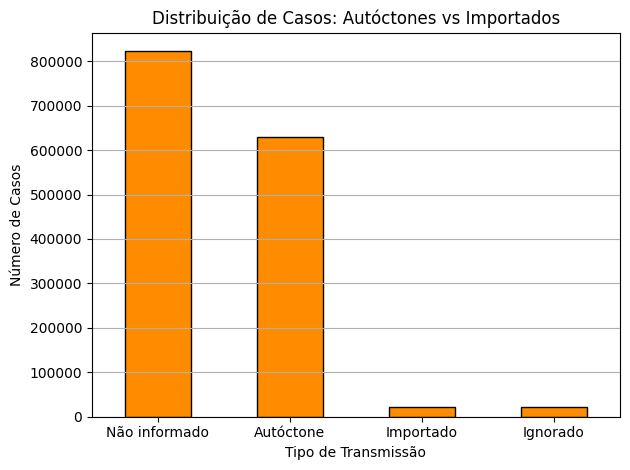

In [67]:
# Dicionário de rótulos para os códigos
mapa_tpautocto = {
    1: 'Autóctone',
    2: 'Importado',
    3: 'Ignorado',
    0: 'Não informado'
}

# Preparar os dados (tratando strings e valores faltantes)
df['TPAUTOCTO_LIMPO'] = pd.to_numeric(df['TPAUTOCTO'], errors='coerce').fillna(0).astype(int)
tpautocto_freq = df['TPAUTOCTO_LIMPO'].value_counts().sort_index()
tpautocto_freq.index = tpautocto_freq.index.map(lambda x: mapa_tpautocto.get(x, f'Cód {x}'))

# Gráfico
tpautocto_freq.plot(kind='bar', color='darkorange', edgecolor='black')
plt.title("Distribuição de Casos: Autóctones vs Importados")
plt.xlabel("Tipo de Transmissão")
plt.ylabel("Número de Casos")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


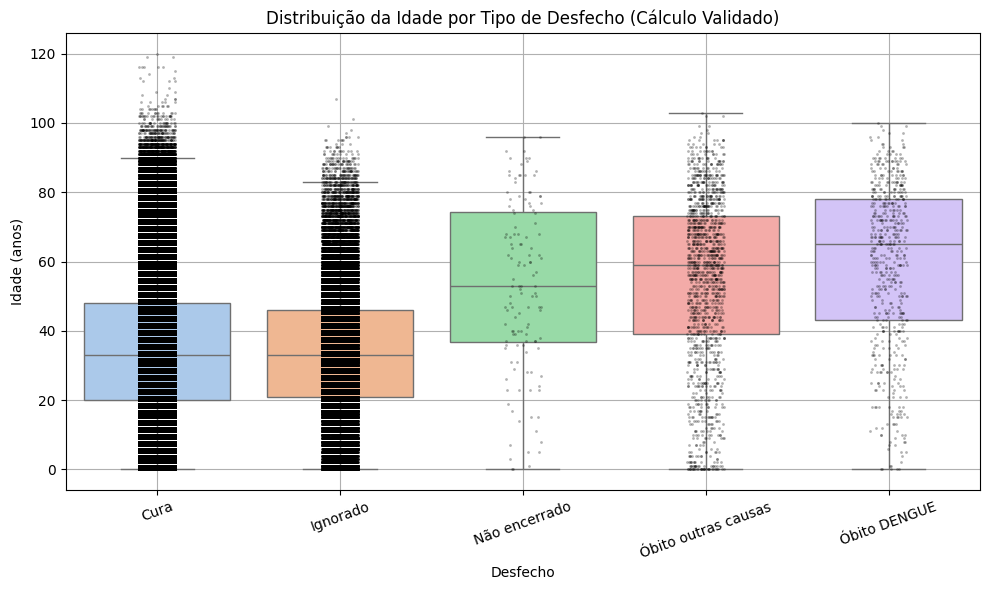

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Mapeamento legível dos códigos de evolução
evolucao_labels = {
    1: 'Cura',
    2: 'Óbito DENGUE',
    3: 'Óbito outras causas',
    4: 'Não encerrado',
    9: 'Ignorado'
}

# 2. Corrige datas
df['DT_NASC'] = pd.to_datetime(df['DT_NASC'], errors='coerce')
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce')

# 3. Calcula idade corretamente
def calcular_idade(linha):
    if pd.isna(linha['DT_NASC']) or pd.isna(linha['DT_NOTIFIC']):
        return pd.NA
    idade = linha['DT_NOTIFIC'].year - linha['DT_NASC'].year
    if (linha['DT_NOTIFIC'].month, linha['DT_NOTIFIC'].day) < (linha['DT_NASC'].month, linha['DT_NASC'].day):
        idade -= 1
    return idade

df['IDADE_CALCULADA'] = df.apply(calcular_idade, axis=1)

# 4. Filtra valores plausíveis
df_filtrado = df[df['IDADE_CALCULADA'].between(0, 120)].copy()

# 5. Aplica mapeamento de evolução
df_filtrado['EVOLUCAO_NOME'] = pd.to_numeric(df_filtrado['EVOLUCAO'], errors='coerce').map(evolucao_labels)

# 6. Gráfico aprimorado
plt.figure(figsize=(10,6))
sns.boxplot(
    x='EVOLUCAO_NOME', y='IDADE_CALCULADA', data=df_filtrado,
    showfliers=False, palette='pastel', hue='EVOLUCAO_NOME', legend=False
)
sns.stripplot(x='EVOLUCAO_NOME', y='IDADE_CALCULADA', data=df_filtrado, color='black', size=2, alpha=0.3)
plt.title("Distribuição da Idade por Tipo de Desfecho (Cálculo Validado)")
plt.xlabel("Desfecho")
plt.ylabel("Idade (anos)")
plt.xticks(rotation=20)
plt.grid(True)
plt.tight_layout()
plt.show()



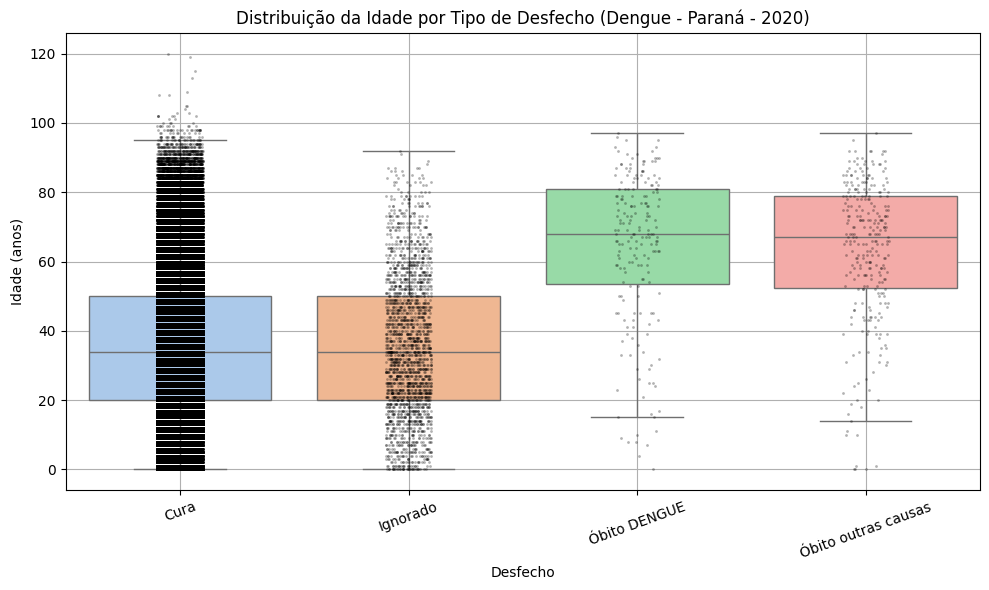

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filtra dados do Paraná
df_parana = df[df['SG_UF'] == '41'].copy()

# 2. Corrige datas
df_parana['DT_NASC'] = pd.to_datetime(df_parana['DT_NASC'], errors='coerce')
df_parana['DT_NOTIFIC'] = pd.to_datetime(df_parana['DT_NOTIFIC'], errors='coerce')

# 3. Calcula idade corretamente
def calcular_idade(linha):
    if pd.isna(linha['DT_NASC']) or pd.isna(linha['DT_NOTIFIC']):
        return pd.NA
    idade = linha['DT_NOTIFIC'].year - linha['DT_NASC'].year
    if (linha['DT_NOTIFIC'].month, linha['DT_NOTIFIC'].day) < (linha['DT_NASC'].month, linha['DT_NASC'].day):
        idade -= 1
    return idade

df_parana['IDADE_CALCULADA'] = df_parana.apply(calcular_idade, axis=1)

# 4. Filtra idades plausíveis
df_filtrado = df_parana[df_parana['IDADE_CALCULADA'].between(0, 120)].copy()

# 5. Mapeia a variável EVOLUCAO
evolucao_labels = {
    1: 'Cura',
    2: 'Óbito DENGUE',
    3: 'Óbito outras causas',
    4: 'Não encerrado',
    9: 'Ignorado'
}
df_filtrado['EVOLUCAO_NOME'] = pd.to_numeric(df_filtrado['EVOLUCAO'], errors='coerce').map(evolucao_labels)

# 6. Gráfico de boxplot + dispersão
plt.figure(figsize=(10,6))
sns.boxplot(
    x='EVOLUCAO_NOME', y='IDADE_CALCULADA', data=df_filtrado,
    showfliers=False, palette='pastel', hue='EVOLUCAO_NOME', legend=False
)
sns.stripplot(x='EVOLUCAO_NOME', y='IDADE_CALCULADA', data=df_filtrado, color='black', size=2, alpha=0.3)
plt.title("Distribuição da Idade por Tipo de Desfecho (Dengue - Paraná - 2020)")
plt.xlabel("Desfecho")
plt.ylabel("Idade (anos)")
plt.xticks(rotation=20)
plt.grid(True)
plt.tight_layout()
plt.show()


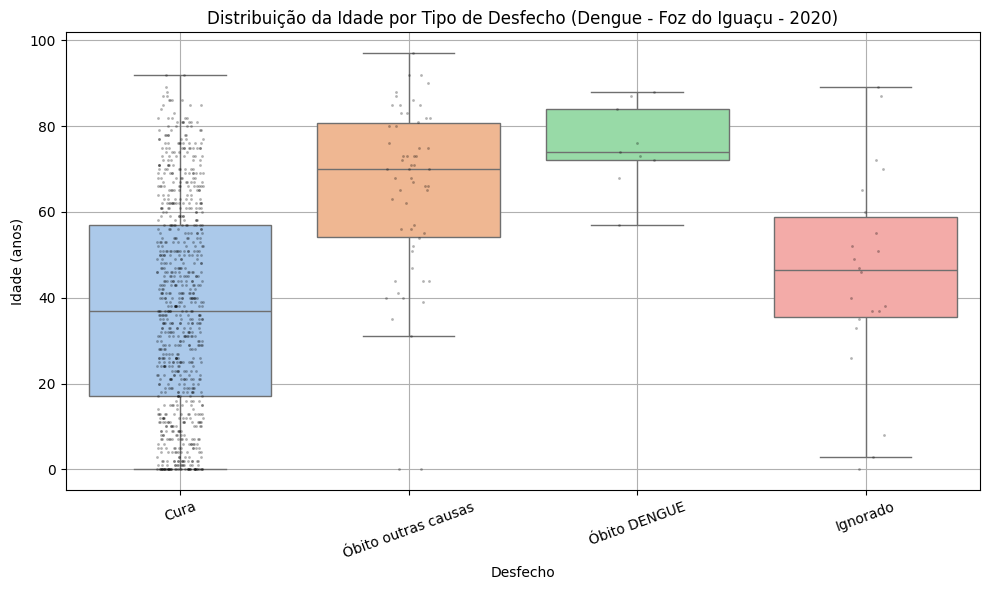

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filtra dados de Foz do Iguaçu (SG_UF = '41' e MUNICIPIO = '410830')
df_foz = df[
    (df['SG_UF'] == '41') &
    (df['MUNICIPIO'].astype(str).str.zfill(6) == '410830')
].copy()

# 2. Corrige datas
df_foz['DT_NASC'] = pd.to_datetime(df_foz['DT_NASC'], errors='coerce')
df_foz['DT_NOTIFIC'] = pd.to_datetime(df_foz['DT_NOTIFIC'], errors='coerce')

# 3. Cálculo validado da idade
def calcular_idade(linha):
    if pd.isna(linha['DT_NASC']) or pd.isna(linha['DT_NOTIFIC']):
        return pd.NA
    idade = linha['DT_NOTIFIC'].year - linha['DT_NASC'].year
    if (linha['DT_NOTIFIC'].month, linha['DT_NOTIFIC'].day) < (linha['DT_NASC'].month, linha['DT_NASC'].day):
        idade -= 1
    return idade

df_foz['IDADE_CALCULADA'] = df_foz.apply(calcular_idade, axis=1)

# 4. Filtra idades plausíveis
df_foz = df_foz[df_foz['IDADE_CALCULADA'].between(0, 120)].copy()

# 5. Mapeia EVOLUCAO para rótulos compreensíveis
evolucao_labels = {
    1: 'Cura',
    2: 'Óbito DENGUE',
    3: 'Óbito outras causas',
    4: 'Não encerrado',
    9: 'Ignorado'
}
df_foz['EVOLUCAO_NOME'] = pd.to_numeric(df_foz['EVOLUCAO'], errors='coerce').map(evolucao_labels)

# 6. Gráfico: Boxplot + Stripplot
plt.figure(figsize=(10,6))
sns.boxplot(
    x='EVOLUCAO_NOME', y='IDADE_CALCULADA', data=df_foz,
    showfliers=False, palette='pastel', hue='EVOLUCAO_NOME', legend=False
)
sns.stripplot(x='EVOLUCAO_NOME', y='IDADE_CALCULADA', data=df_foz, color='black', size=2, alpha=0.3)
plt.title("Distribuição da Idade por Tipo de Desfecho (Dengue - Foz do Iguaçu - 2020)")
plt.xlabel("Desfecho")
plt.ylabel("Idade (anos)")
plt.xticks(rotation=20)
plt.grid(True)
plt.tight_layout()
plt.show()


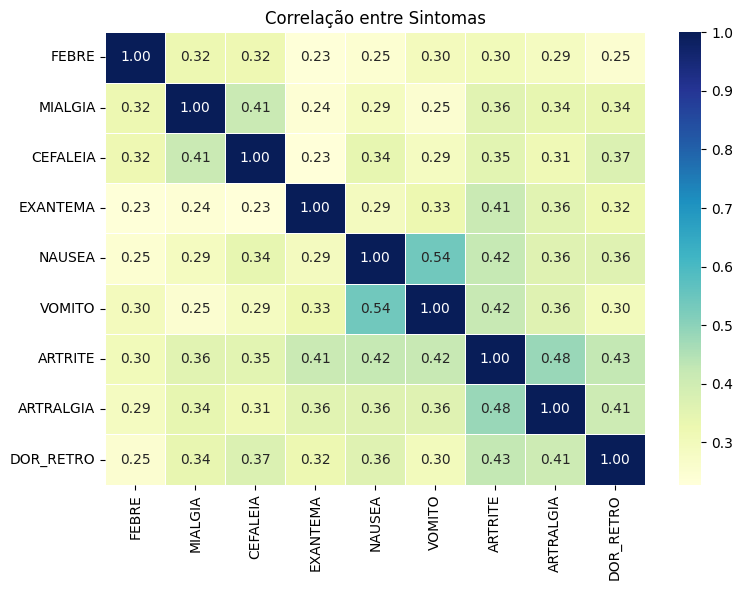

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Lista de sintomas binários
sintomas = ['FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'NAUSEA', 'VOMITO', 'ARTRITE', 'ARTRALGIA', 'DOR_RETRO']

# Substitui strings vazias por NaN e converte para inteiro (0 ou 1)
df_sint = df[sintomas].replace('', pd.NA).astype('Int64').fillna(0)

# Matriz de correlação
corr = df_sint.corr()

# Mapa de calor
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title("Correlação entre Sintomas")
plt.tight_layout()
plt.show()



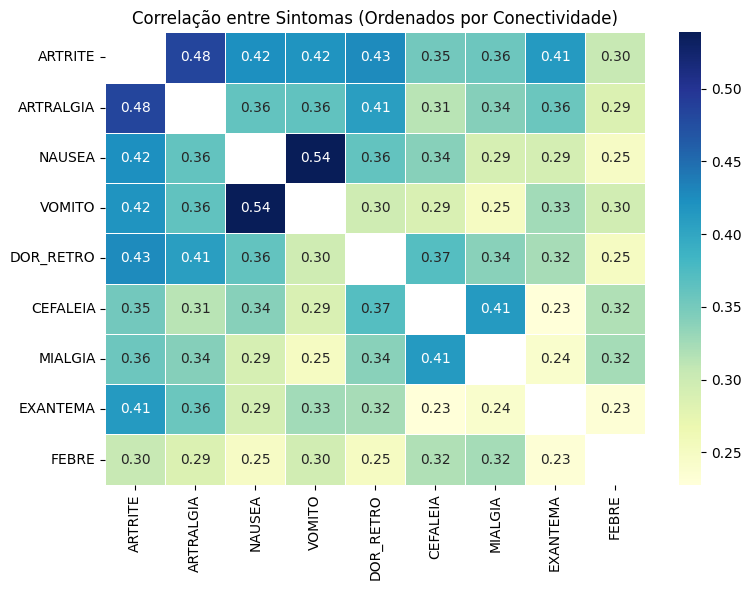

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular correlação entre sintomas binários
df_sint = df[sintomas].replace('', pd.NA).astype('Int64').fillna(0)
corr = df_sint.corr()

# Remover a diagonal (1.0) para cálculo da média real de correlação
np.fill_diagonal(corr.values, np.nan)
mean_corr = corr.mean(axis=1)

# Ordenar os sintomas com base na média de correlação
ordem = mean_corr.sort_values(ascending=False).index.tolist()

# Reordenar a matriz de correlação
corr_ordenada = corr.loc[ordem, ordem]

# Replotar o heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_ordenada, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title("Correlação entre Sintomas (Ordenados por Conectividade)")
plt.tight_layout()
plt.show()


In [ ]:
# 1. Corrigir dados e calcular correlação
df_sint = df[sintomas].replace('', pd.NA).astype('Int64').fillna(0)
corr = df_sint.corr()

# 2. Transformar em série e remover duplicados
corr_series = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # parte superior da matriz
corr_series = corr_series.unstack().dropna()

# 3. Ordenar e extrair os top 3 pares
top3_pares = corr_series.sort_values(ascending=False).head(3)

# 4. Mostrar
print("🔝 Top 3 pares de sintomas mais correlacionados:")
for (s1, s2), valor in top3_pares.items():
    print(f"• {s1} ↔ {s2} → correlação = {valor:.2f}")


🔝 Top 3 pares de sintomas mais correlacionados:
• VOMITO ↔ NAUSEA → correlação = 0.54
• ARTRALGIA ↔ ARTRITE → correlação = 0.48
• DOR_RETRO ↔ ARTRITE → correlação = 0.43


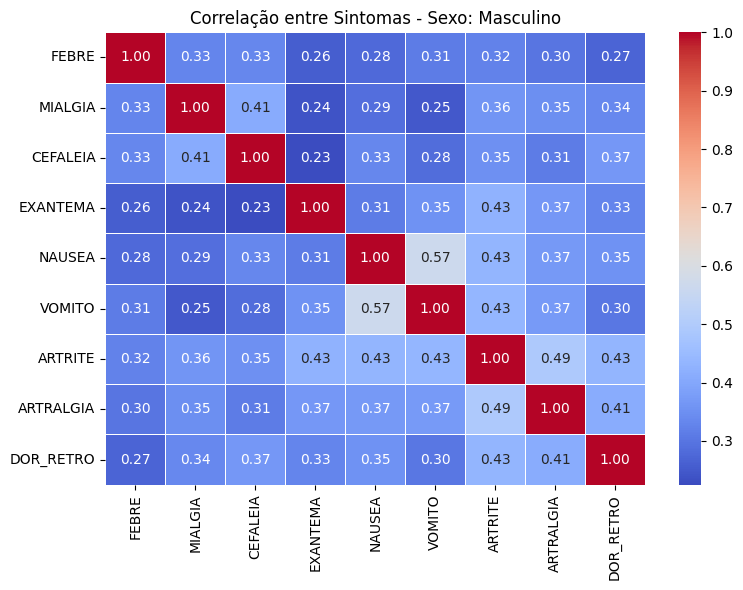

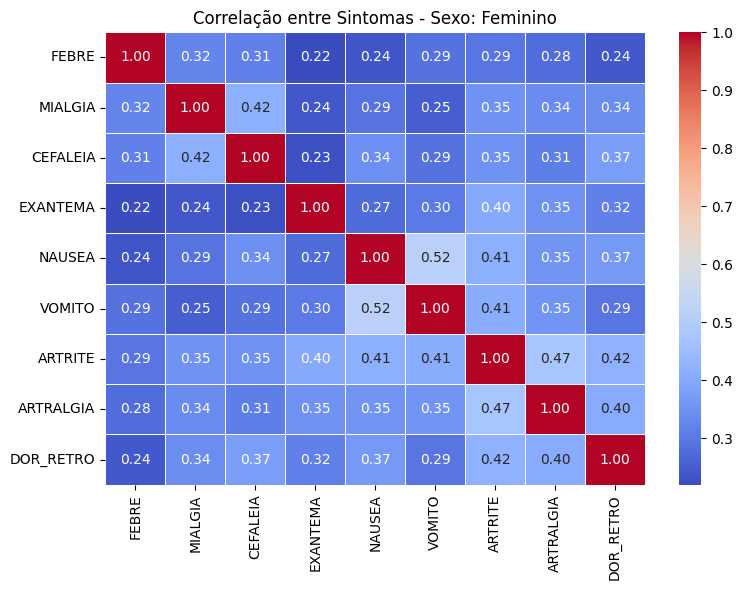

In [ ]:
sintomas = ['FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'NAUSEA',
            'VOMITO', 'ARTRITE', 'ARTRALGIA', 'DOR_RETRO']
df_sint = df[sintomas].replace('', pd.NA).astype('Int64').fillna(0)

df['CS_SEXO_LIMPO'] = df['CS_SEXO'].map({'M': 'Masculino', 'F': 'Feminino', 'I': 'Ignorado'})

for sexo in ['Masculino', 'Feminino']:
    subset = df[df['CS_SEXO_LIMPO'] == sexo]
    subset_sint = subset[sintomas].replace('', pd.NA).astype('Int64').fillna(0)
    corr = subset_sint.corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f"Correlação entre Sintomas - Sexo: {sexo}")
    plt.tight_layout()
    plt.show()



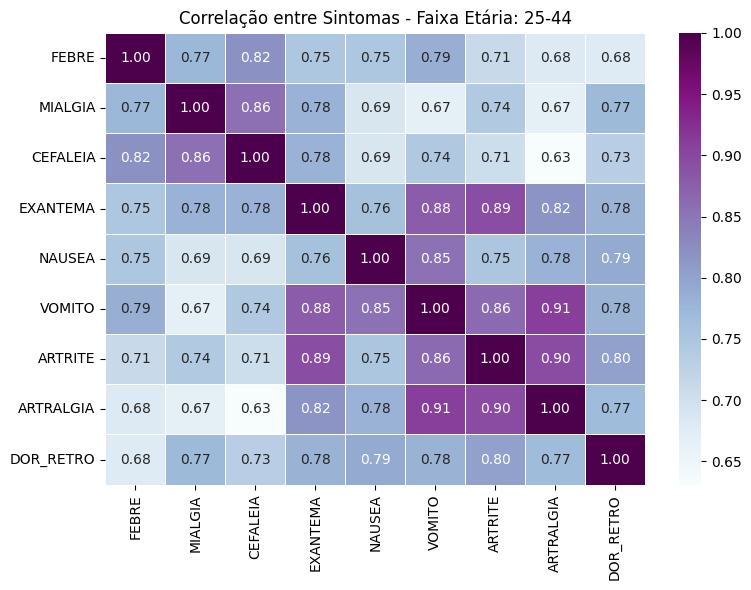

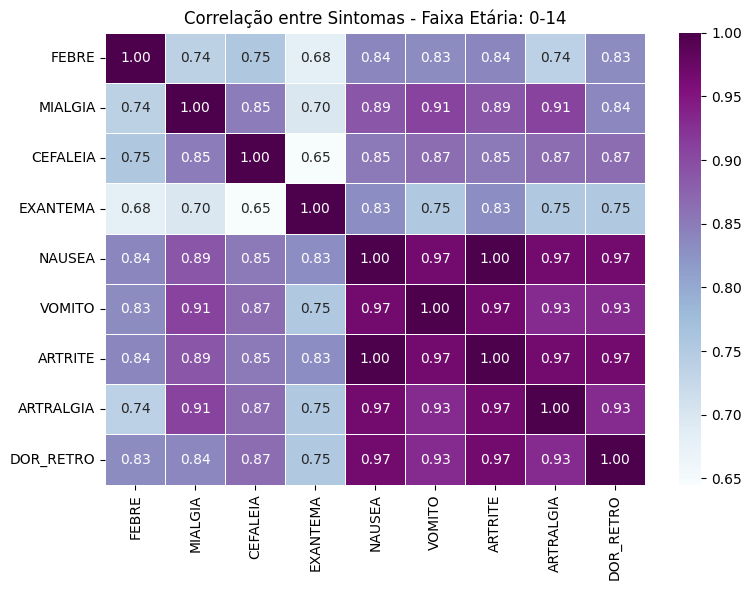

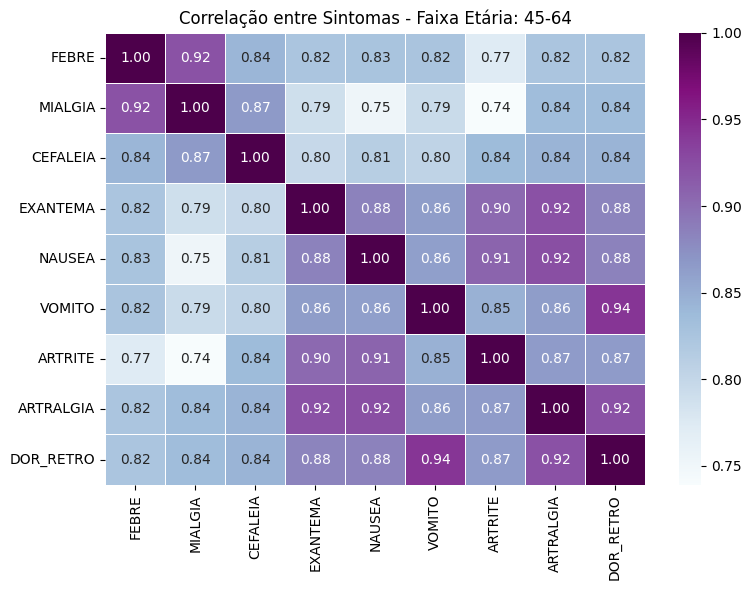

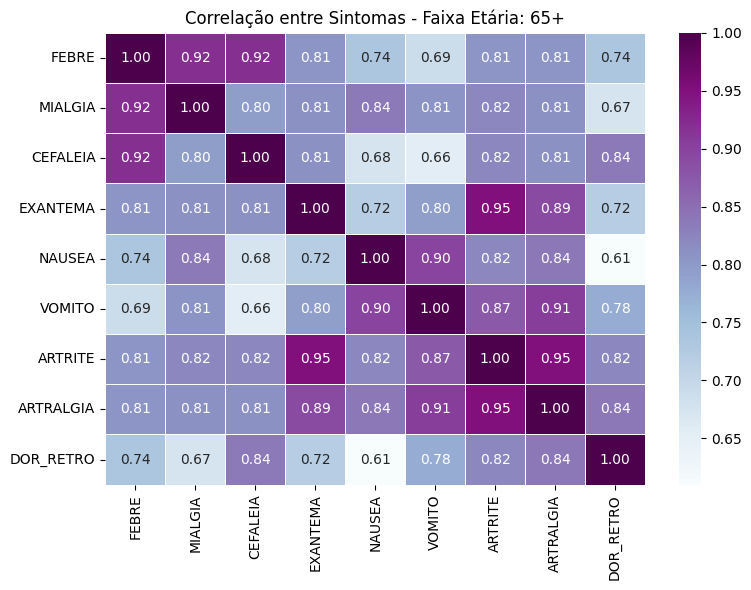

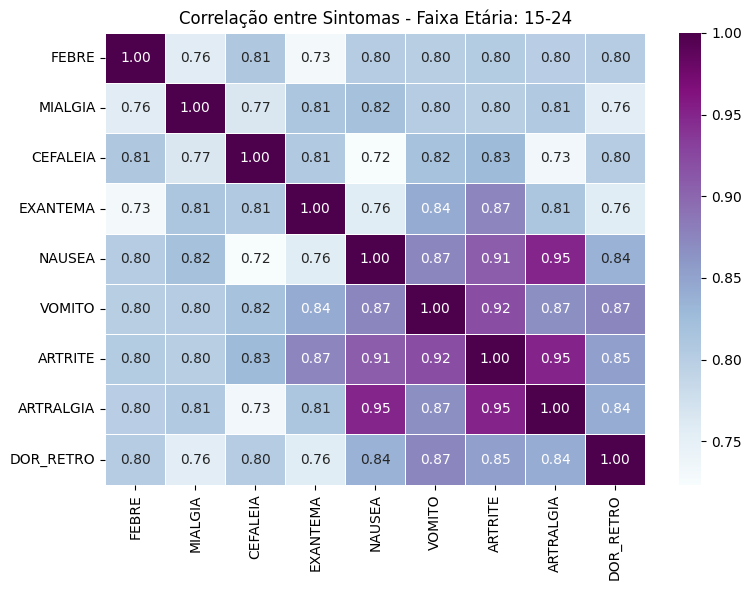

In [ ]:
sintomas = ['FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'NAUSEA',
            'VOMITO', 'ARTRITE', 'ARTRALGIA', 'DOR_RETRO']
df_sint = df[sintomas].replace('', pd.NA).astype('Int64').fillna(0)

# Categoriza faixa etária
df['NU_IDADE_N'] = pd.to_numeric(df['NU_IDADE_N'], errors='coerce')
df['faixa_etaria'] = pd.cut(
    df['NU_IDADE_N'],
    bins=[0, 14, 24, 44, 64, 120],
    labels=['0-14', '15-24', '25-44', '45-64', '65+']
)

for faixa in df['faixa_etaria'].dropna().unique():
    subset = df[df['faixa_etaria'] == faixa]
    subset_sint = subset[sintomas].replace('', pd.NA).astype('Int64').fillna(0)
    corr = subset_sint.corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='BuPu', fmt='.2f', linewidths=0.5)
    plt.title(f"Correlação entre Sintomas - Faixa Etária: {faixa}")
    plt.tight_layout()
    plt.show()


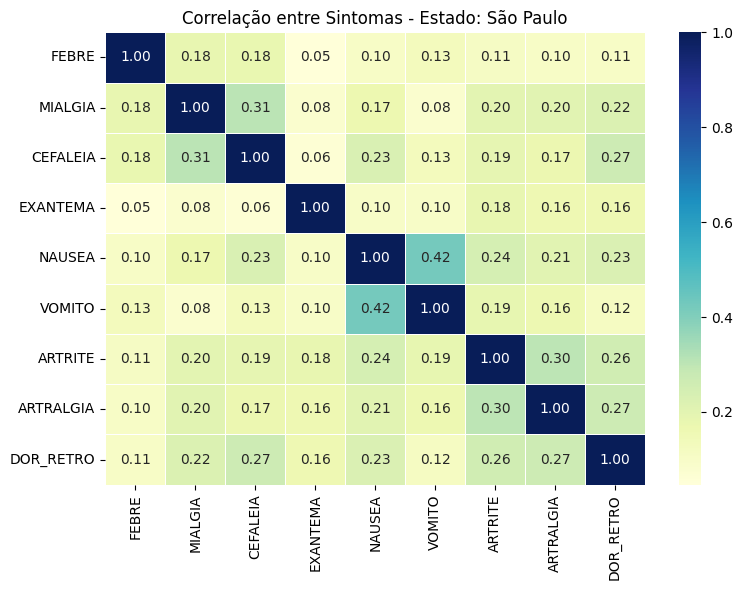

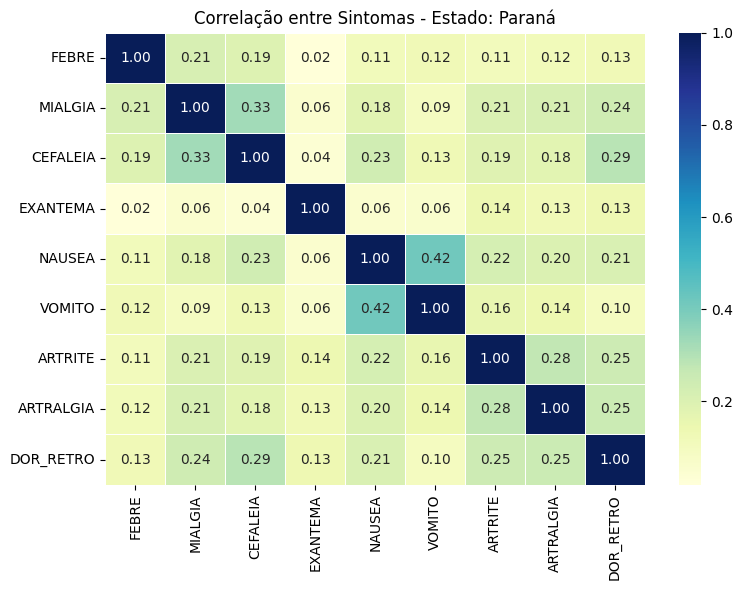

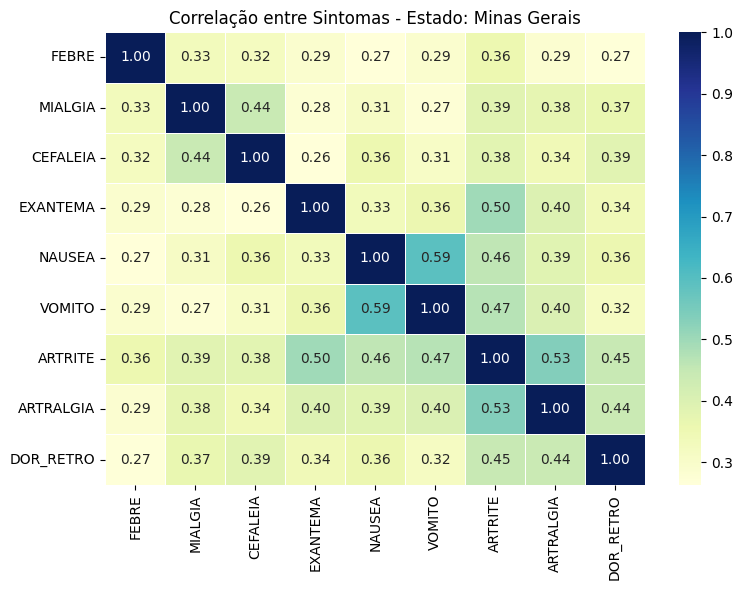

In [ ]:
# Mapa com chaves como string (garante compatibilidade total)
mapa_uf_ibge = {
    '11': 'Rondônia',
    '12': 'Acre',
    '13': 'Amazonas',
    '14': 'Roraima',
    '15': 'Pará',
    '16': 'Amapá',
    '17': 'Tocantins',
    '21': 'Maranhão',
    '22': 'Piauí',
    '23': 'Ceará',
    '24': 'Rio Grande do Norte',
    '25': 'Paraíba',
    '26': 'Pernambuco',
    '27': 'Alagoas',
    '28': 'Sergipe',
    '29': 'Bahia',
    '31': 'Minas Gerais',
    '32': 'Espírito Santo',
    '33': 'Rio de Janeiro',
    '35': 'São Paulo',
    '41': 'Paraná',
    '42': 'Santa Catarina',
    '43': 'Rio Grande do Sul',
    '50': 'Mato Grosso do Sul',
    '51': 'Mato Grosso',
    '52': 'Goiás',
    '53': 'Distrito Federal'
}



sintomas = ['FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'NAUSEA',
            'VOMITO', 'ARTRITE', 'ARTRALGIA', 'DOR_RETRO']
df_sint = df[sintomas].replace('', pd.NA).astype('Int64').fillna(0)

ufs_mais_frequentes = df['SG_UF_NOT'].value_counts().head(3).index.tolist()  # 3 UFs mais comuns

for uf in ufs_mais_frequentes:
    subset = df[df['SG_UF_NOT'] == uf]
    subset_sint = subset[sintomas].replace('', pd.NA).astype('Int64').fillna(0)
    corr = subset_sint.corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
    # Garante que o código IBGE seja interpretado corretamente como string
    codigo_uf = str(int(float(uf)))  # ex: '31.0' → '31'
    plt.title(f"Correlação entre Sintomas - Estado: {mapa_uf_ibge.get(codigo_uf, uf)}")
    plt.tight_layout()
    plt.show()


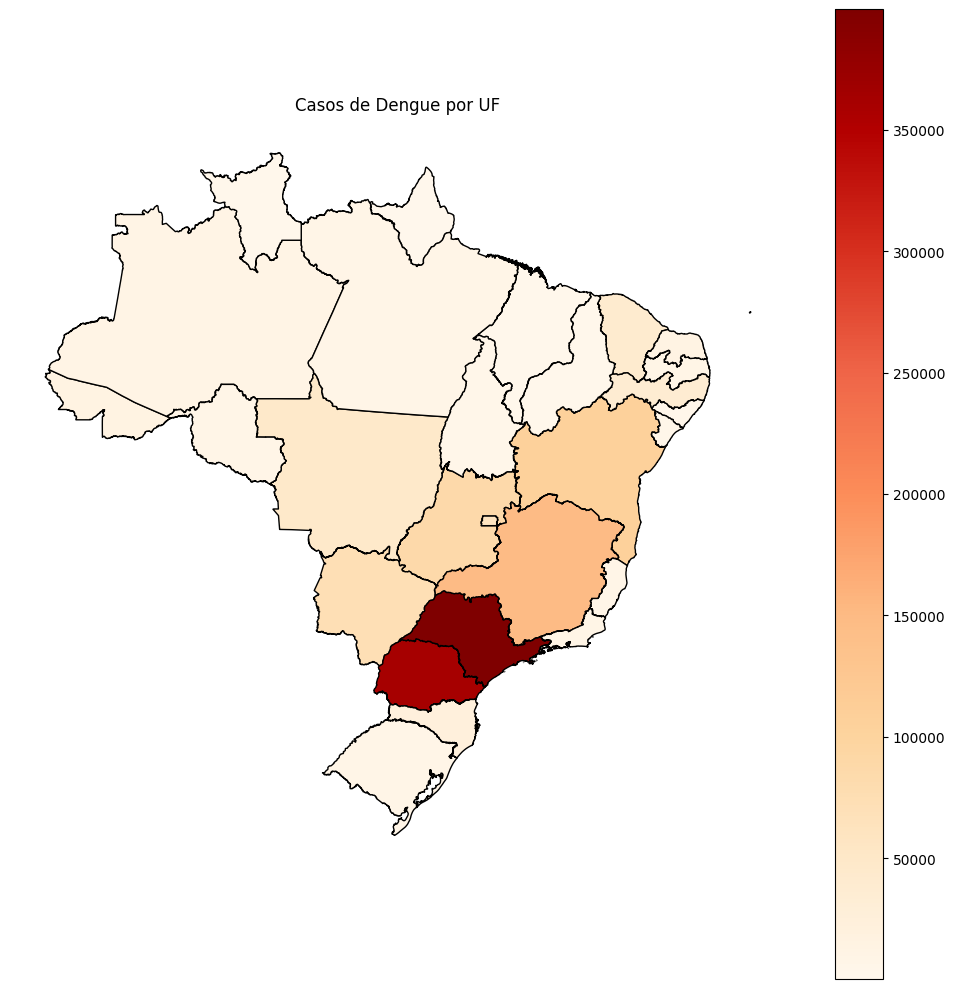

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# 1. Contar casos por código IBGE da UF
casos_uf = df['SG_UF'].value_counts().reset_index()
casos_uf.columns = ['codigo_ibge', 'n_casos']
casos_uf['codigo_ibge'] = casos_uf['codigo_ibge'].astype(int)

# 2. Mapeamento: código IBGE → sigla UF
ibge_para_sigla = {
    12: 'AC', 27: 'AL', 13: 'AM', 16: 'AP', 29: 'BA', 23: 'CE', 53: 'DF',
    32: 'ES', 52: 'GO', 21: 'MA', 31: 'MG', 50: 'MS', 51: 'MT', 15: 'PA',
    25: 'PB', 26: 'PE', 22: 'PI', 41: 'PR', 33: 'RJ', 24: 'RN', 43: 'RS',
    11: 'RO', 14: 'RR', 42: 'SC', 28: 'SE', 35: 'SP', 17: 'TO'
}
casos_uf['sigla'] = casos_uf['codigo_ibge'].map(ibge_para_sigla)

# 3. Carrega o GeoJSON (estados brasileiros com 'sigla')
br_ufs = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")

# ⚠️ Verifica que a coluna de UF no shapefile é string
br_ufs['sigla'] = br_ufs['sigla'].astype(str)

# 4. Merge por 'sigla'
geo = br_ufs.merge(casos_uf, on='sigla', how='left')

# 5. Remove geometrias nulas (caso merge falhe para algum estado)
geo = geo[geo.geometry.notnull()]

# 6. Plotagem
geo.plot(column='n_casos', cmap='OrRd', legend=True, figsize=(10, 10), edgecolor='black')
plt.title("Casos de Dengue por UF")
plt.axis('off')
plt.tight_layout()
plt.show()




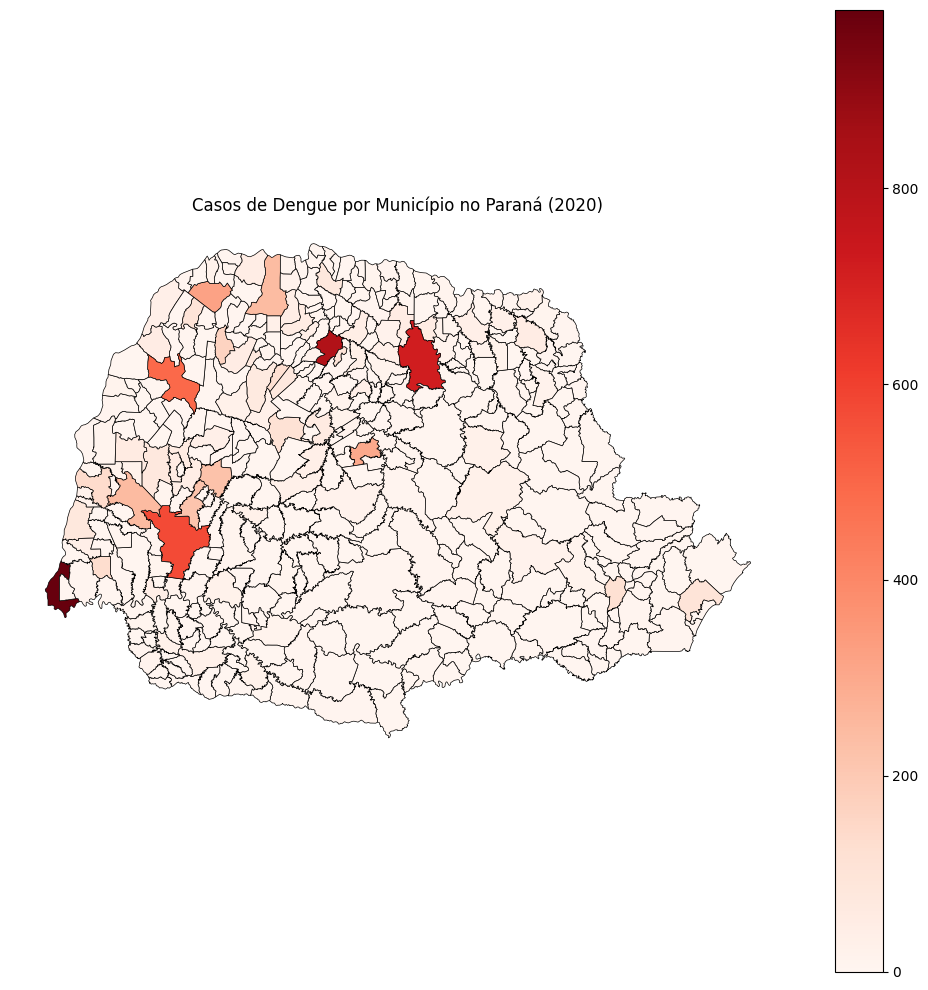

In [74]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filtra casos apenas do Paraná
df_parana = df[df['SG_UF'] == '41'].copy()

# 2. Garante MUNICIPIO como código IBGE com 6 dígitos
df_parana['MUNICIPIO'] = df_parana['MUNICIPIO'].astype(str).str.zfill(6)

# 3. Conta número de casos por município
casos_por_mun = df_parana['MUNICIPIO'].value_counts().reset_index()
casos_por_mun.columns = ['CD_MUN', 'n_casos']

# 4. Carrega o GeoJSON com todos os municípios brasileiros
url_geojson = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"
gdf_municipios = gpd.read_file(url_geojson)

# 5. Filtra apenas os municípios do Paraná (códigos que começam com '41')
gdf_pr = gdf_municipios[gdf_municipios['id'].str.startswith('41')].copy()
gdf_pr['CD_MUN'] = gdf_pr['id'].str[:6]

# 6. Merge com dados de casos
gdf_pr = gdf_pr.merge(casos_por_mun, on='CD_MUN', how='left')
gdf_pr['n_casos'] = gdf_pr['n_casos'].fillna(0)

# 7. Plota o mapa de calor
fig, ax = plt.subplots(figsize=(10, 10))
gdf_pr.plot(column='n_casos', cmap='Reds', linewidth=0.5, ax=ax, edgecolor='black', legend=True)
plt.title("Casos de Dengue por Município no Paraná (2020)")
plt.axis('off')
plt.tight_layout()
plt.show()



In [89]:
!pip install xlrd

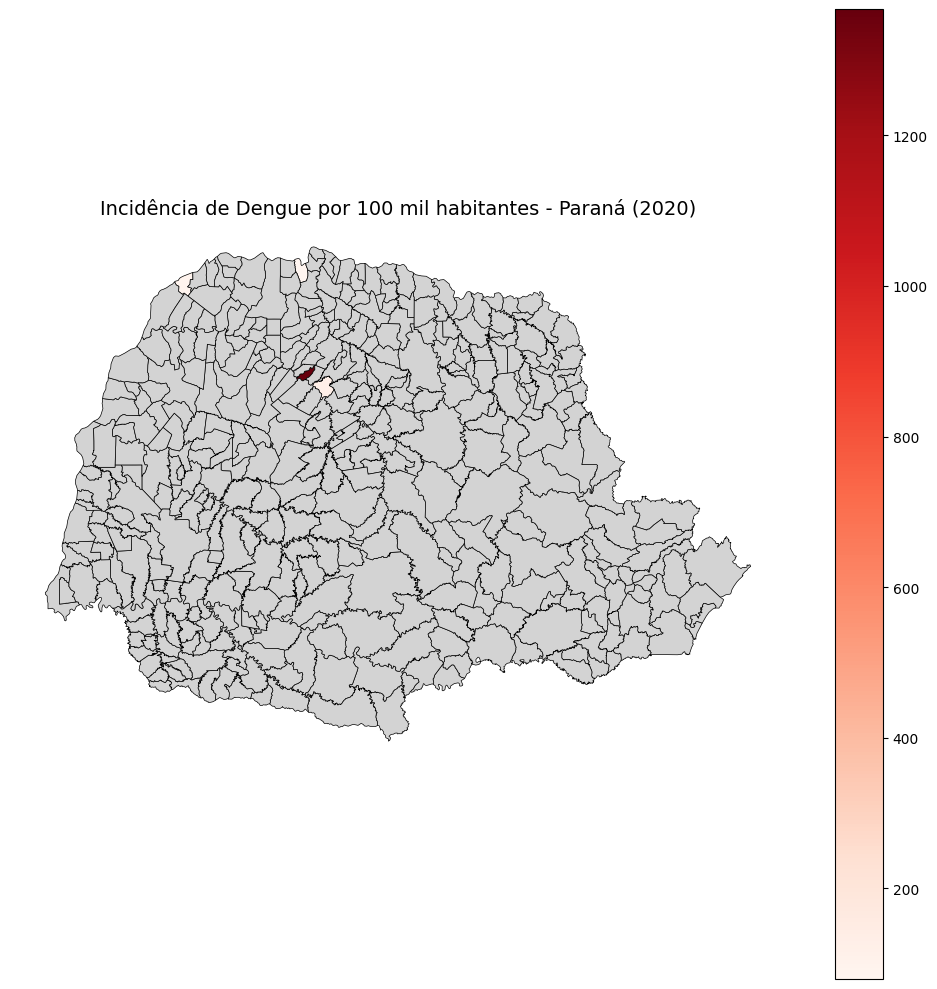

In [137]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Carrega geometria dos municípios do Paraná
url_geojson = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-41-mun.json"
gdf_municipios = gpd.read_file(url_geojson)
gdf_municipios['CD_GEOCMU'] = gdf_municipios['id'].astype(str).str.zfill(7)

# 2. Casos de dengue no Paraná
df_pr = df[df['SG_UF'] == '41'].copy()
df_pr['MUNICIPIO'] = df_pr['MUNICIPIO'].astype(str).str.zfill(6)

casos_por_municipio = df_pr['MUNICIPIO'].value_counts().reset_index()
casos_por_municipio.columns = ['MUNICIPIO', 'n_casos']

# Corrige código para padrão IBGE com 7 dígitos
casos_por_municipio['CD_GEOCMU'] = (
    '41' + casos_por_municipio['MUNICIPIO'].str[-5:]
)

# Remove códigos inválidos
casos_por_municipio = casos_por_municipio[casos_por_municipio['CD_GEOCMU'].str.len() == 7]

# 3. Leitura da população do GitHub - aba correta e nomes manuais
url_pop = "https://github.com/cartaproale/PySUS/raw/refs/heads/main/tabelas/POP2024_20241230.xls"
df_pop = pd.read_excel(
    url_pop,
    sheet_name=1,
    header=None,
    skiprows=3,
    usecols=[0, 1, 2, 3, 4],
    names=['UF', 'COD_UF', 'COD_MUNIC', 'MUNICIPIO', 'POP_ESTIMADA'],
    dtype=str
)

# 4. Filtra só PR e formata código IBGE com 7 dígitos
df_pop_pr = df_pop[df_pop['UF'] == 'PR'].copy()
df_pop_pr['CD_GEOCMU'] = df_pop_pr['COD_UF'].str.zfill(2) + df_pop_pr['COD_MUNIC'].str.zfill(5)
df_pop_pr['POP_ESTIMADA'] = pd.to_numeric(df_pop_pr['POP_ESTIMADA'], errors='coerce')
df_pop_pr = df_pop_pr[['CD_GEOCMU', 'POP_ESTIMADA']]

# 5. Junta casos com população
df_mapa = casos_por_municipio.merge(df_pop_pr, on='CD_GEOCMU', how='left')
df_mapa['tx_100k'] = df_mapa['n_casos'] / df_mapa['POP_ESTIMADA'] * 100000

# 6. Junta com geometria
gdf_mapa = gdf_municipios.merge(df_mapa[['CD_GEOCMU', 'tx_100k']], on='CD_GEOCMU', how='left')

# 7. Mapa final
fig, ax = plt.subplots(figsize=(10, 10))
gdf_mapa.plot(
    column='tx_100k',
    cmap='Reds',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}
)

ax.set_title("Incidência de Dengue por 100 mil habitantes - Paraná (2020)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()






In [ ]:
df['SG_UF'].value_counts().reset_index()


SG_UF   count
0     35  399737
1     41  361123
2     31  148589
3     29  107490
4     52   87481
5     50   73514
6     53   60400
7     51   47627
8     23   40976
9     26   36764
10    42   23106
11    12   15086
12    24   12897
13    13   10714
14    33    8715
15    25    8665
16    32    7852
17    15    7595
18    11    6725
19    43    6605
20    17    5642
21    28    5281
22    27    3670
23    21    3284
24    22    2922
25    14    2413
26    16     244

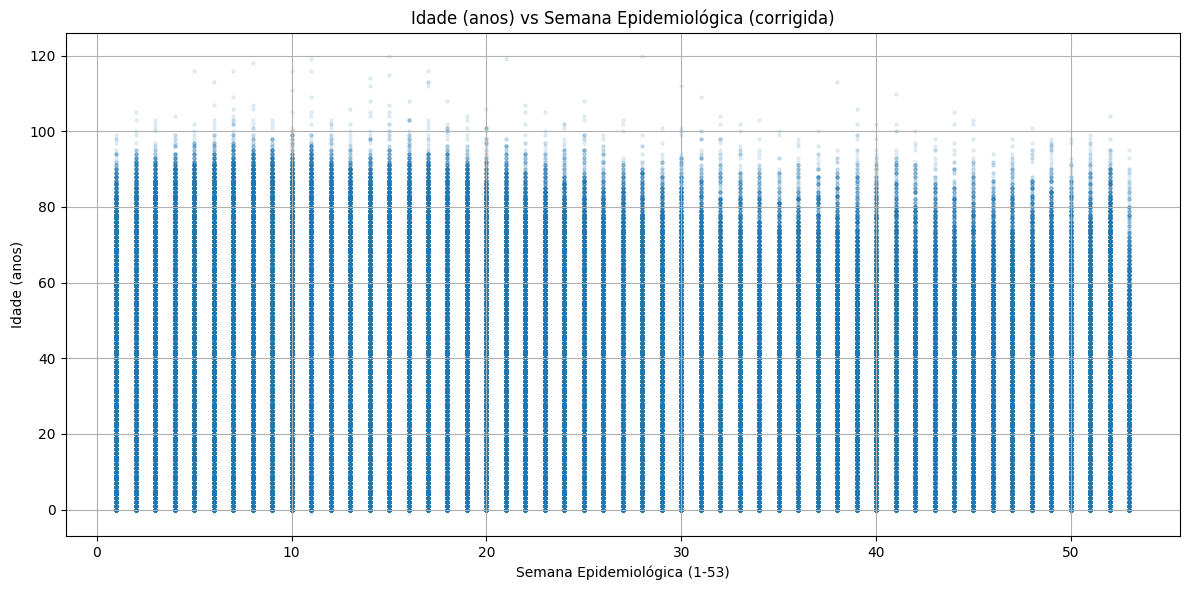

In [139]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Corrige datas e calcula idade de forma validada
df['DT_NASC'] = pd.to_datetime(df['DT_NASC'], errors='coerce')
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce')

def calcular_idade(row):
    if pd.isna(row['DT_NASC']) or pd.isna(row['DT_NOTIFIC']):
        return pd.NA
    idade = row['DT_NOTIFIC'].year - row['DT_NASC'].year
    if (row['DT_NOTIFIC'].month, row['DT_NOTIFIC'].day) < (row['DT_NASC'].month, row['DT_NASC'].day):
        idade -= 1
    return idade

df['IDADE_ANOS'] = df.apply(calcular_idade, axis=1)

# 2. Calcula semana epidemiológica
df['SEM_PRI'] = pd.to_numeric(df['SEM_PRI'], errors='coerce')
df['SEMANA'] = df['SEM_PRI'] % 100

# 3. Filtra dados válidos
df_plot = df[['SEMANA', 'IDADE_ANOS']].dropna()
df_plot = df_plot[df_plot['IDADE_ANOS'] <= 120]
df_plot = df_plot[df_plot['SEMANA'] <= 53]

# 4. Gráfico
plt.figure(figsize=(12,6))
plt.scatter(df_plot['SEMANA'], df_plot['IDADE_ANOS'], alpha=0.1, s=5)
plt.title("Idade (anos) vs Semana Epidemiológica (corrigida)")
plt.xlabel("Semana Epidemiológica (1-53)")
plt.ylabel("Idade (anos)")
plt.grid(True)
plt.tight_layout()
plt.show()



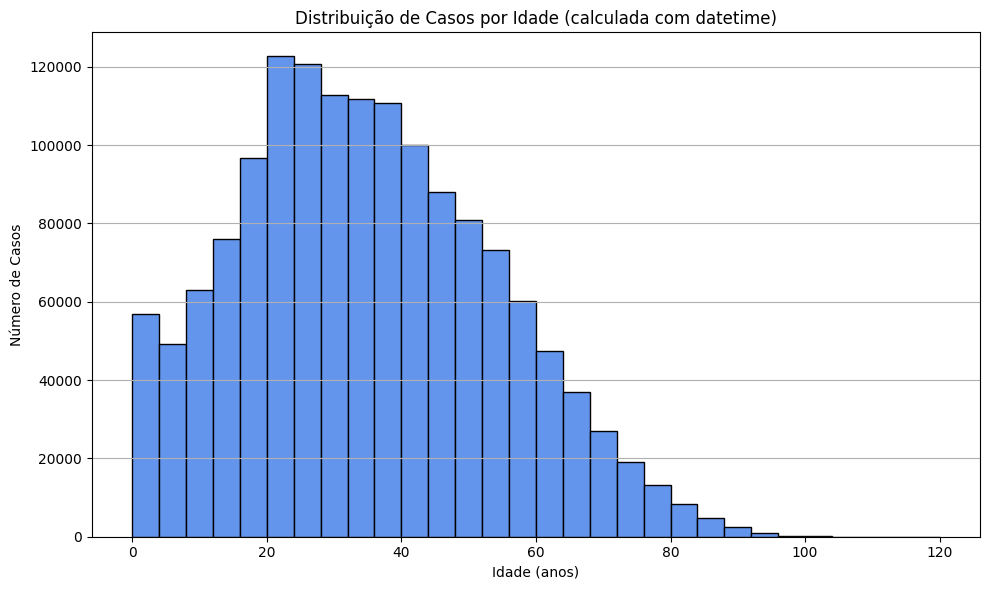

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Converter para datetime
df['DT_NASC'] = pd.to_datetime(df['DT_NASC'], format='%Y%m%d', errors='coerce')
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce')

# 2. Calcular idade com base em datas reais
def calcular_idade(linha):
    try:
        idade = linha['DT_NOTIFIC'].year - linha['DT_NASC'].year
        if (linha['DT_NOTIFIC'].month, linha['DT_NOTIFIC'].day) < (linha['DT_NASC'].month, linha['DT_NASC'].day):
            idade -= 1
        return idade
    except:
        return None

df['IDADE_CALCULADA'] = df.apply(calcular_idade, axis=1)

# 3. Converter e filtrar
df['IDADE_CALCULADA'] = pd.to_numeric(df['IDADE_CALCULADA'], errors='coerce')
df_validos = df[(df['IDADE_CALCULADA'] >= 0) & (df['IDADE_CALCULADA'] <= 120)].copy()

# 4. Plotar histograma
plt.figure(figsize=(10,6))
df_validos['IDADE_CALCULADA'].plot(kind='hist', bins=30, edgecolor='black', color='cornflowerblue')
plt.title('Distribuição de Casos por Idade (calculada com datetime)')
plt.xlabel('Idade (anos)')
plt.ylabel('Número de Casos')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


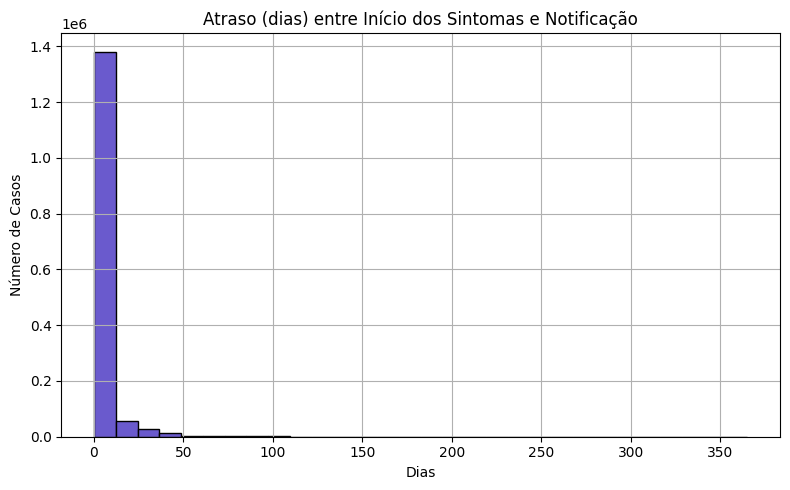

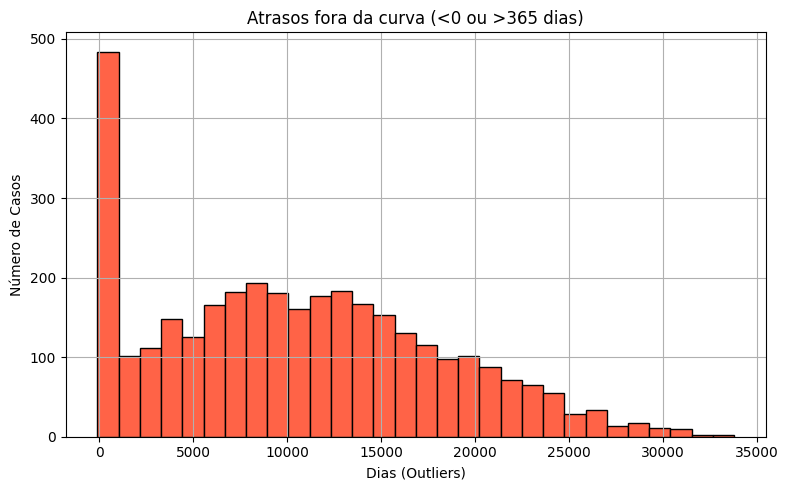

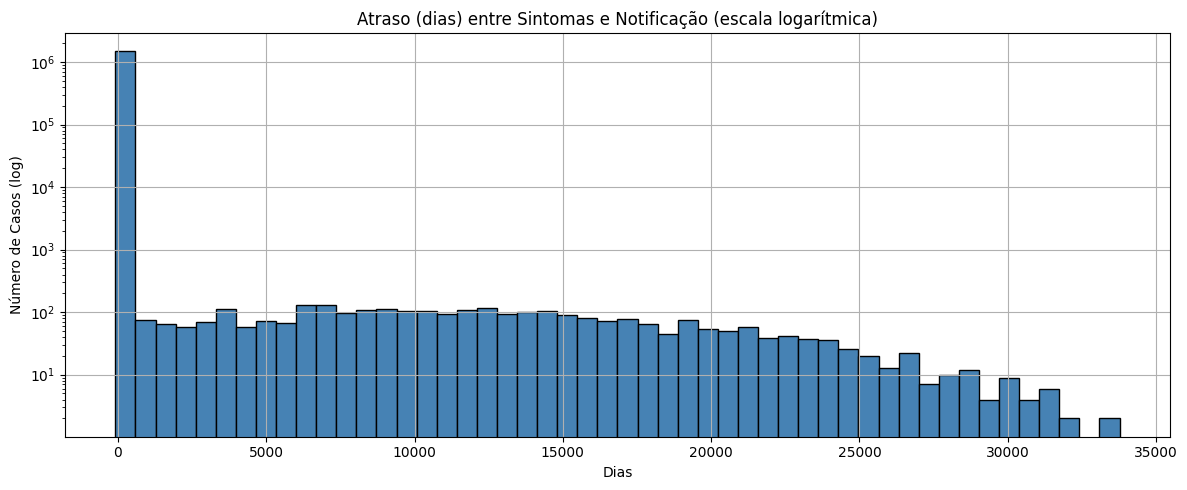

🔎 Amostra de Casos com Atraso fora da Curva:


ATRASO_DIAS
1434157       8557.0
482046       16440.0
1384043      15888.0
54241        24414.0
1429257      17812.0
328439         366.0
1076101      15004.0
24215        11317.0
92424          367.0
1493074       3569.0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Garantir datas no formato datetime
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce')
df['DT_SIN_PRI'] = pd.to_datetime(df['DT_SIN_PRI'], errors='coerce')

# 2. Calcular diferença em dias
dias = (df['DT_NOTIFIC'] - df['DT_SIN_PRI']).dt.days.dropna()

# 3. Filtrar dados válidos e outliers
dias_validos = dias[(dias >= 0) & (dias <= 365)]
dias_outliers = dias[(dias < 0) | (dias > 365)]

# 4. Plotar histograma normal
plt.figure(figsize=(8,5))
plt.hist(dias_validos, bins=30, color='slateblue', edgecolor='black')
plt.title("Atraso (dias) entre Início dos Sintomas e Notificação")
plt.xlabel("Dias")
plt.ylabel("Número de Casos")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Plotar histograma dos outliers
plt.figure(figsize=(8,5))
plt.hist(dias_outliers, bins=30, color='tomato', edgecolor='black')
plt.title("Atrasos fora da curva (<0 ou >365 dias)")
plt.xlabel("Dias (Outliers)")
plt.ylabel("Número de Casos")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Plotar histograma logarítmico com todos os dados
plt.figure(figsize=(12,5))
plt.hist(dias, bins=50, color='steelblue', edgecolor='black', log=True)
plt.title("Atraso (dias) entre Sintomas e Notificação (escala logarítmica)")
plt.xlabel("Dias")
plt.ylabel("Número de Casos (log)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Exibir amostra de outliers
amostra_outliers = dias_outliers.sample(10, random_state=42).to_frame(name='ATRASO_DIAS')
print("🔎 Amostra de Casos com Atraso fora da Curva:")
display(amostra_outliers)



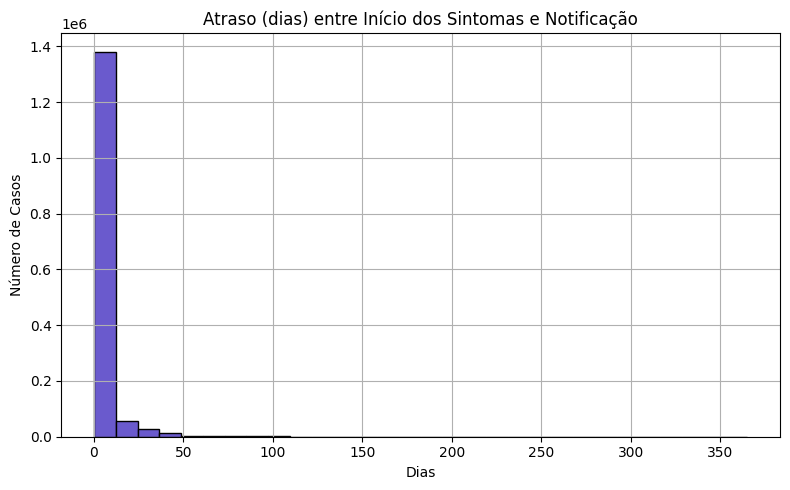

In [ ]:
# 1. Calcula o atraso em dias
dias = (df['DT_NOTIFIC'] - df['DT_SIN_PRI']).dt.days.dropna()

# 2. Filtra intervalos razoáveis
dias_filtrados = dias[(dias >= -30) & (dias <= 365)]

# 3. Plota histograma ajustado
plt.figure(figsize=(8,5))
plt.hist(dias_filtrados, bins=30, color='slateblue', edgecolor='black')
plt.title("Atraso (dias) entre Início dos Sintomas e Notificação")
plt.xlabel("Dias")
plt.ylabel("Número de Casos")
plt.grid(True)
plt.tight_layout()
plt.show()



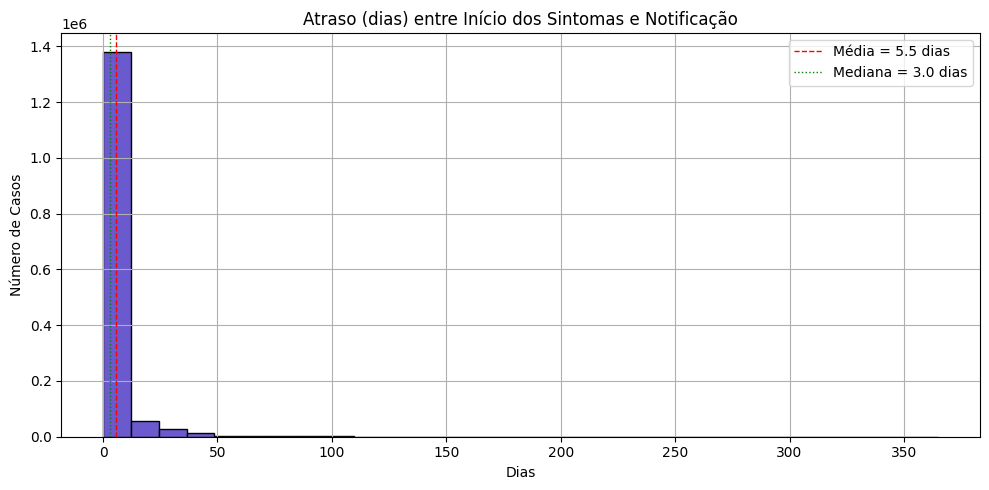

In [ ]:
import numpy as np

media = dias_filtrados.mean()
mediana = dias_filtrados.median()

plt.figure(figsize=(10,5))
plt.hist(dias_filtrados, bins=30, color='slateblue', edgecolor='black')
plt.axvline(media, color='red', linestyle='dashed', linewidth=1, label=f'Média = {media:.1f} dias')
plt.axvline(mediana, color='green', linestyle='dotted', linewidth=1, label=f'Mediana = {mediana:.1f} dias')
plt.title("Atraso (dias) entre Início dos Sintomas e Notificação")
plt.xlabel("Dias")
plt.ylabel("Número de Casos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


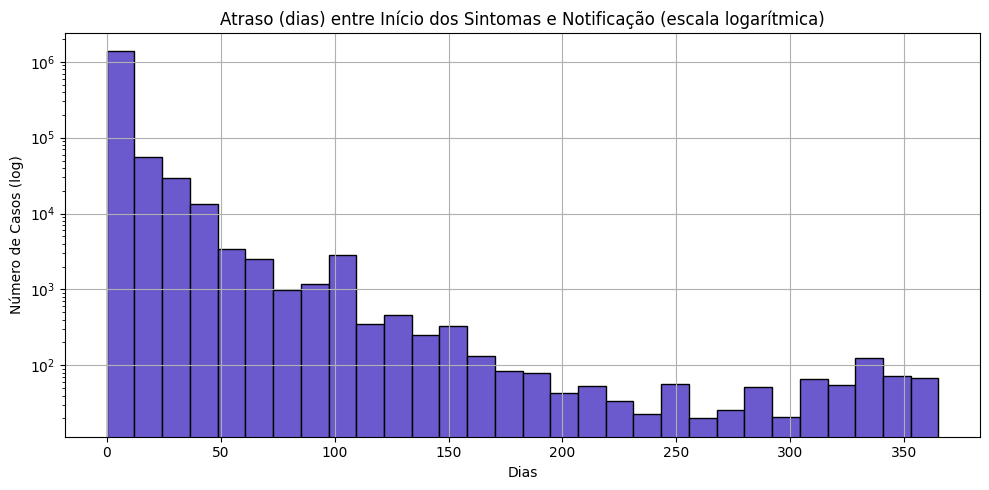

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(dias_filtrados, bins=30, color='slateblue', edgecolor='black')
plt.yscale('log')
plt.title("Atraso (dias) entre Início dos Sintomas e Notificação (escala logarítmica)")
plt.xlabel("Dias")
plt.ylabel("Número de Casos (log)")
plt.grid(True)
plt.tight_layout()
plt.show()


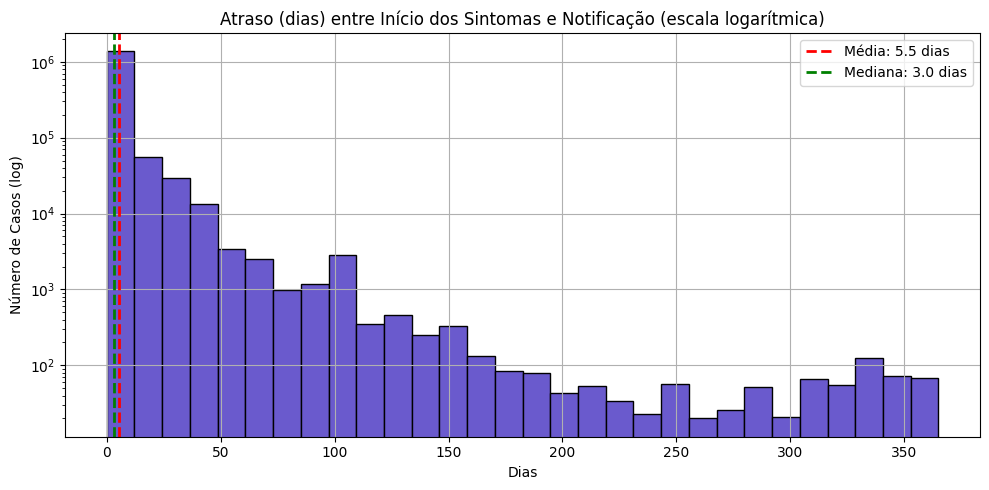

In [ ]:
import matplotlib.pyplot as plt

# Calcula média e mediana
media = dias_filtrados.mean()
mediana = dias_filtrados.median()

# Cria o histograma
plt.figure(figsize=(10,5))
plt.hist(dias_filtrados, bins=30, color='slateblue', edgecolor='black')
plt.yscale('log')

# Linhas verticais para média e mediana
plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Média: {media:.1f} dias')
plt.axvline(mediana, color='green', linestyle='--', linewidth=2, label=f'Mediana: {mediana:.1f} dias')

# Legenda e ajustes
plt.title("Atraso (dias) entre Início dos Sintomas e Notificação (escala logarítmica)")
plt.xlabel("Dias")
plt.ylabel("Número de Casos (log)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


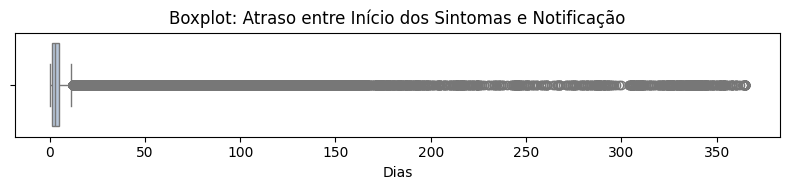

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,2))
sns.boxplot(x=dias_filtrados, color='lightsteelblue')
plt.title("Boxplot: Atraso entre Início dos Sintomas e Notificação")
plt.xlabel("Dias")
plt.tight_layout()
plt.show()


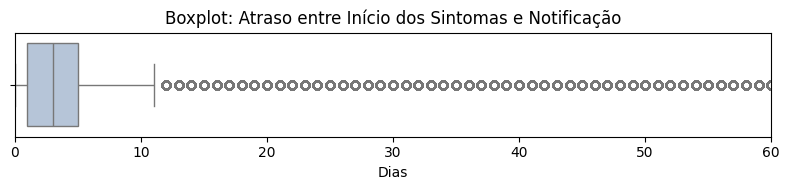

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,2))
sns.boxplot(x=dias_filtrados, color='lightsteelblue')
plt.title("Boxplot: Atraso entre Início dos Sintomas e Notificação")
plt.xlabel("Dias")
plt.xlim(0, 60)  # Ajuste conforme o intervalo que deseja destacar
plt.tight_layout()
plt.show()


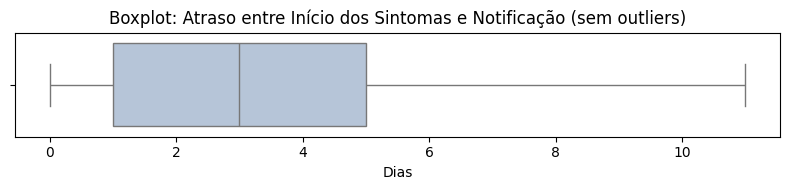

In [ ]:
plt.figure(figsize=(8,2))
sns.boxplot(x=dias_filtrados, color='lightsteelblue', showfliers=False)
plt.title("Boxplot: Atraso entre Início dos Sintomas e Notificação (sem outliers)")
plt.xlabel("Dias")
plt.tight_layout()
plt.show()


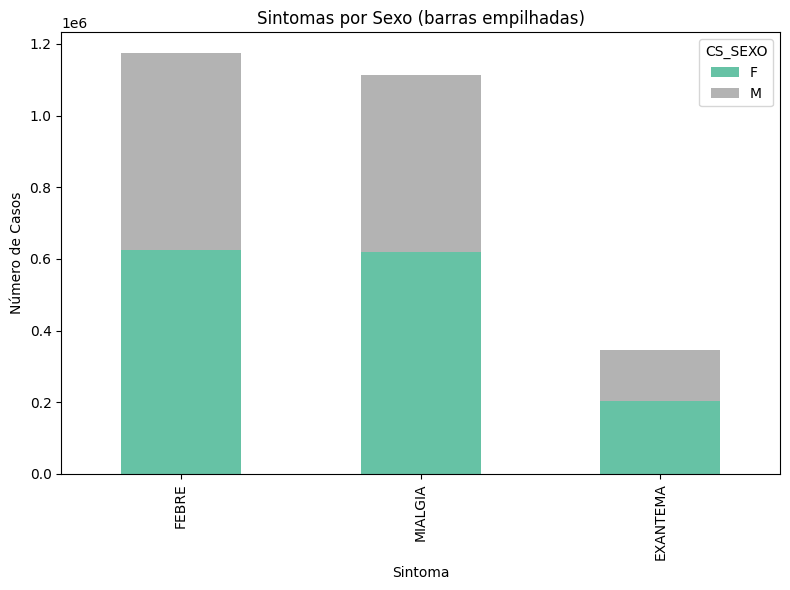

In [ ]:
# Lista de sintomas binários
sintomas_binarios = ['FEBRE', 'MIALGIA', 'EXANTEMA']

# Filtrar apenas dados válidos por sexo
df_tmp = df[df['CS_SEXO'].isin(['M', 'F'])].copy()

# Converte sintomas para 1 (presente) ou 0 (ausente ou inválido)
for sintoma in sintomas_binarios:
    df_tmp[sintoma] = df_tmp[sintoma].astype(str).str.strip().apply(lambda x: 1 if x == '1' else 0)

# Agrupar e somar
tabela = df_tmp.groupby('CS_SEXO')[sintomas_binarios].sum().T

# Plotar gráfico de barras empilhadas
tabela.plot(kind='bar', stacked=True, figsize=(8,6), colormap='Set2')
plt.title("Sintomas por Sexo (barras empilhadas)")
plt.ylabel("Número de Casos")
plt.xlabel("Sintoma")
plt.tight_layout()
plt.show()


